<a href="https://colab.research.google.com/github/deniseiras/BAM1D-Microphysics-Emulation/blob/main/BAM1D_Physics_Emulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BAM1D Physics Emulation

<font size="5">**Objetivo:** Emular a Hugh Morrison Microphysics implementada em BAM1D</font>
 


SUBROUTINE RunMicro_HugMorr(  
  
**ncols** - numero de colunas - fixo = 1  
nCols       , &!INTEGER      , INTENT(IN   ) :: nCols

**kmax** - número de níveis = k_max  
kMax        , &!INTEGER      , INTENT(IN   ) :: kMax 

**si** - kmax+1 removido, sem valores/usado
si          , &!REAL(KIND=r8), INTENT(IN   ) :: si(kMax+1)

**sl**  
sl          , &!REAL(KIND=r8), INTENT(IN   ) :: sl(kMax)

**tc** - Temperature(K)  
tc          , &!REAL(KIND=r8), INTENT(INOUT) :: Tc (1:nCols, 1:kMax)

<font size="5">Q's - Mixing ratio </font>

**QV** - water vapor  
QV          , &!REAL(KIND=r8), INTENT(INOUT) :: qv (1:nCols, 1:kMax)

**QC** - cloud water  
QC          , &!REAL(KIND=r8), INTENT(INOUT) :: qc (1:nCols, 1:kMax)

**QR**  - rain water  
QR          , &!REAL(KIND=r8), INTENT(INOUT) :: qr (1:nCols, 1:kMax)

**QI** - cloud ice  
QI          , &!REAL(KIND=r8), INTENT(INOUT) :: qi (1:nCols, 1:kMax)

**QS** - Snow  
QS          , &!REAL(KIND=r8), INTENT(INOUT) :: qs (1:nCols, 1:kMax)

**QG** - Graupel  
QG          , &!REAL(KIND=r8), INTENT(INOUT) :: qg (1:nCols, 1:kMax)

<font size="5">*N's* - number concentration
</font>  

**NI** - cloud ice  
NI          , &!REAL(KIND=r8), INTENT(INOUT) :: ni (1:nCols, 1:kMax)

**NS** - Snow  
NS          , &!REAL(KIND=r8), INTENT(INOUT) :: ns (1:nCols, 1:kMax)

**NR** - Rain    
NR          , &!REAL(KIND=r8), INTENT(INOUT) :: nr (1:nCols, 1:kMax)

**NG** - Graupel  
NG          , &!REAL(KIND=r8), INTENT(INOUT) :: NG (1:nCols, 1:kMax)   

**NC** - Cloud droplet  
NC          , &!REAL(KIND=r8), INTENT(INOUT) :: NC (1:nCols, 1:kMax)   

**TKE** - turbulence kinetic energy (m^2 s-2), NEEDED FOR DROPLET ACTIVATION  
TKE         , &!REAL(KIND=r8), INTENT(IN   ) :: TKE (1:nCols, 1:kMax)   

**KZH** -  heat eddy diffusion coefficient from YSU scheme (M^2 S-1), NEEDED FOR DROPLET ACTIVATION  
KZH         , &!REAL(KIND=r8), INTENT(IN   ) :: KZH (1:nCols, 1:kMax)   

**gps** - Pressão - removida da entrada da RNA - valor fixo  
gps         , &!gps- AIR PRESSURE (PA)

**DT_IN** - model time step (sec) - Removido da entrada da RNA
DT_IN       , &!REAL(KIND=r8), INTENT(IN   ) :: dt_in

**omega**  
omega       , &!REAL(KIND=r8), INTENT(IN   ) :: omega  ! omega (Pa/s)

**EFFCS** - CLOUD DROPLET EFFECTIVE RADIUS OUTPUT TO RADIATION CODE (micron)  
EFFCS       , &!REAL(KIND=r8), INTENT(OUT  ) :: EFFCS (1:nCols, 1:kMax)   

**EFFIS** - ICE DROPLET EFFECTIVE RADIUS OUTPUT TO RADIATION CODE (micron)  
EFFIS       , &!REAL(KIND=r8), INTENT(OUT  ) :: EFFIS (1:nCols, 1:kMax)   

**LSRAIN** - Large scale Rain  
LSRAIN      , &!REAL(KIND=r8), INTENT(OUT) :: LSRAIN(1:nCols)

**LSSNOW** - Large scale Snow  
LSSNOW        )!REAL(KIND=r8), INTENT(OUT) :: LSSNOW(1:nCols)


# Setup do dados

Carregamento dos dados

In [ ]:
# fix do pandas profiling no colab
# https://python.plainenglish.io/how-to-use-pandas-profiling-on-google-colab-e34f34ff1c9f

# 1º - intalar abaixo
# ! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip 

# 2º reiniciar kernel (botão)

In [ ]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
import time
from sklearn import metrics, preprocessing

%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

import keras
from tensorflow.python.data import Dataset
from sklearn.datasets import make_regression
from sklearn.model_selection import RepeatedKFold, train_test_split
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input, Dropout, Conv1D, Flatten, MaxPooling1D, Conv2D, MaxPooling2D, BatchNormalization, Activation, LSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from keras.utils.vis_utils import plot_model
from keras.callbacks import TensorBoard
import csv    
from datetime import datetime
from shutil import copyfile, copytree, rmtree
import seaborn as sns
# from pandas_profiling import ProfileReport

# % pip install XlsxWriter
# % pip install SkillMetrics
# import skill_metrics as sm


# tf.logging.set_verbosity(tf.logging.ERROR)

# pd.options.display.float_format = '{:.1f}'.format
pd.options.display.float_format = '{:f}'.format


# working local
#
# %load_ext tensorboard funciona local ???
# %reload_ext tensorboard ???
# colab_in_drive_root_dir = "/home/denis/_COM_BACKUP/NN_BAM1d/bam1d_data/Colab Notebooks"
# tb_logdir_base = colab_in_drive_root_dir + '/logs'
# data_in_drive_dir = "/media/denis/dados/_COM_BACKUP/NN_BAM1D/bam1d_data/"


# loading from gdrive - COLAB MOUNTS AUTOMATICALLY NOW
#
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)
colab_in_drive_root_dir = "/content/drive/My Drive/Colab Notebooks"
tb_logdir_base = colab_in_drive_root_dir + '/logs'
# tb_logdir_base = './logs'
data_in_drive_dir = "/content/drive/My Drive/NN_Microphysics/"



Tensorflow version 2.7.0
Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [ ]:

# original_input_df = pd.read_csv("{}/hug_morr_inputs_CRD_RRTMG.csv".format(data_in_drive_dir), sep=",")
# original_output_df = pd.read_csv("{}/hug_morr_outputs_CRD_RRTMG.csv".format(data_in_drive_dir), sep=",")

# original_input_df = pd.read_csv("{}/hug_morr_inputs_CRD_HSR.csv".format(data_in_drive_dir), sep=",")
# original_output_df = pd.read_csv("{}/hug_morr_outputs_CRD_HSR.csv".format(data_in_drive_dir), sep=",")

# original_input_df = pd.read_csv("{}/hug_morr_inputs_CRD_RRTMG___dt_60.csv".format(data_in_drive_dir), sep=",")
# original_output_df = pd.read_csv("{}/hug_morr_outputs_CRD_RRTMG___dt_60.csv".format(data_in_drive_dir), sep=",")


# IOP com menos de 180 falta memória

# original_input_df = pd.read_csv("{}/IOP2014__CRD_RRTMG_dt_360/hug_morr_inputs.csv".format(data_in_drive_dir), sep=",")
# original_output_df = pd.read_csv("{}/IOP2014__CRD_RRTMG_dt_360/hug_morr_outputs.csv".format(data_in_drive_dir), sep=",")

# original_input_df = pd.read_csv("{}IOP2014__CRD_RRMTG_dt_60/hug_morr_inputs.csv".format(data_in_drive_dir), sep=",")
# original_output_df = pd.read_csv("{}IOP2014__CRD_RRMTG_dt_60/hug_morr_outputs.csv".format(data_in_drive_dir), sep=",")

# original_input_df = pd.read_csv("{}IOP2014__CRD_RRMTG_dt_120/hug_morr_inputs.csv".format(data_in_drive_dir), sep=",")
# original_output_df = pd.read_csv("{}IOP2014__CRD_RRMTG_dt_120/hug_morr_outputs.csv".format(data_in_drive_dir), sep=",")

# original_input_df = pd.read_csv("{}IOP2014__CRD_RRMTG_dt_180/hug_morr_inputs.csv".format(data_in_drive_dir), sep=",")
# original_output_df = pd.read_csv("{}IOP2014__CRD_RRMTG_dt_180/hug_morr_outputs.csv".format(data_in_drive_dir), sep=",")

# original_input_df = pd.read_csv("{}IOP2014__CRD_RRMTG_dt_360/hug_morr_inputs.csv".format(data_in_drive_dir), sep=",")
# original_output_df = pd.read_csv("{}IOP2014__CRD_RRMTG_dt_360/hug_morr_outputs.csv".format(data_in_drive_dir), sep=",")

# Dropbox - 28 levs 360
original_input_df = pd.read_csv('https://www.dropbox.com/s/hxi5eoh69kw95gt/hug_morr_inputs.csv?dl=1', sep=',' )
original_output_df = pd.read_csv('https://www.dropbox.com/s/q8ch9p392cbpyap/hug_morr_outputs.csv?dl=1', sep=",")

# Parâmetros

In [ ]:
# ******** ATENCAO ********* Setar de acordo com os dados
delta_t = 360
k_max = 28  # número de níveis utilizado

levels = k_max
spin_hours = 24
k_inicial = 1
k_final = k_max

# Análise dos dados

### Análise estatística

- Resumo dos valores das variáveis de entrada e saída. Observe que os valores são truncados no Resumo
- Valores do primeiro, centésimo e último passo de tempo
- Níveis verticais do primeiro, centésimo e último passo de tempo

In [ ]:
print("\nAll input summary:")
display.display(original_input_df.describe())
print("\nAll output summary:")
display.display(original_output_df.describe())

print("\nInput First timestep:")
display.display(original_input_df.head(k_max))
print("\nInput 100th timestep:")
display.display(original_input_df.loc[k_max*100:k_max*100+27])
print("\nInput Last timestep:")
display.display(original_input_df.tail(k_max))

print("\nOutput First timestep:")
display.display(original_output_df.head(k_max))
print("\nOutput 100th timestep:")
display.display(original_output_df.loc[k_max*100:k_max*100+27])
print("\nOutput Last timestep:")
display.display(original_output_df.tail(k_max))

# original_output_df.describe().to_csv('/content/drive/My Drive/Colab Notebooks/temp_describe.csv')




All input summary:


k             si  ...            gps          omega
count 2432668.000000 2432668.000000  ... 2432668.000000 2432668.000000
mean       14.500000       0.468551  ...   99000.000000      -0.011693
std         8.077749       0.363561  ...       0.000000       0.079067
min         1.000000       0.003669  ...   99000.000000      -1.076957
25%         7.750000       0.103880  ...   99000.000000      -0.023834
50%        14.500000       0.432240  ...   99000.000000       0.000000
75%        21.250000       0.834470  ...   99000.000000       0.015077
max        28.000000       1.000000  ...   99000.000000       0.551774

[8 rows x 20 columns]


All output summary:


k             Tc  ...         LSRAIN         LSSNOW
count 2432668.000000 2432668.000000  ... 2432668.000000 2432668.000000
mean       14.500000     237.867614  ...       0.000001       0.000000
std         8.077749      61.437256  ...       0.000008       0.000000
min         1.000000      64.121762  ...      -0.000000      -0.000000
25%         7.750000     202.364884  ...       0.000000       0.000000
50%        14.500000     257.584944  ...       0.000000       0.000000
75%        21.250000     289.010609  ...       0.000000       0.000000
max        28.000000     308.629704  ...       0.000292       0.000000

[8 rows x 17 columns]


Input First timestep:


k       si  si_kmax_+_1       sl  ...      tke      kzh          gps     omega
0    1 1.000000     0.000000 0.994964  ... 0.000000 0.059243 99000.000000 -0.012614
1    2 0.989934     0.000000 0.981964  ... 0.000000 0.136973 99000.000000 -0.001955
2    3 0.974009     0.000000 0.964137  ... 0.000000 0.100000 99000.000000 -0.028920
3    4 0.954290     0.000000 0.942167  ... 0.000000 0.100000 99000.000000 -0.037237
4    5 0.930081     0.000000 0.915361  ... 0.000000 0.100000 99000.000000 -0.033169
5    6 0.900698     0.000000 0.883075  ... 0.000000 0.100000 99000.000000 -0.015972
6    7 0.865537     0.000000 0.844765  ... 0.000000 0.100000 99000.000000  0.005468
7    8 0.824114     0.000000 0.800102  ... 0.000000 0.100000 99000.000000  0.015528
8    9 0.776260     0.000000 0.749106  ... 0.000000 0.100000 99000.000000  0.000447
9   10 0.722185     0.000000 0.692241  ... 0.000000 0.100000 99000.000000 -0.009879
10  11 0.662603     0.000000 0.630466  ... 0.000000 0.100000 99000.000000 -0.012457
11  12 0.598714     0.000000 0.565232  ... 0.000000 0.100000 99000.000000 -0.023799
12  13 0.532217     0.000000 0.498382  ... 0.000000 0.100000 99000.000000 -0.012203
13  14 0.465086     0.000000 0.431942  ... 0.000000 0.100000 99000.000000  0.007016
14  15 0.399394     0.000000 0.367889  ... 0.000000 0.100000 99000.000000  0.019831
15  16 0.337014     0.000000 0.307925  ... 0.000000 0.100000 99000.000000  0.014118
16  17 0.279476     0.000000 0.253317  ... 0.000000 0.100000 99000.000000  0.043484
17  18 0.227787     0.000000 0.204824  ... 0.000000 0.100000 99000.000000  0.078580
18  19 0.182459     0.000000 0.162718  ... 0.000000 0.100000 99000.000000  0.054193
19  20 0.143533     0.000000 0.126862  ... 0.000000 0.100000 99000.000000  0.015835
20  21 0.110697     0.000000 0.096834  ... 0.000000 0.100000 99000.000000  0.001492
21  22 0.083428     0.000000 0.072038  ... 0.000000 0.100000 99000.000000  0.000000
22  23 0.061061     0.000000 0.051797  ... 0.000000 0.100000 99000.000000  0.000000
23  24 0.042912     0.000000 0.035429  ... 0.000000 0.100000 99000.000000  0.000000
24  25 0.028306     0.000000 0.022285  ... 0.000000 0.100000 99000.000000  0.000000
25  26 0.016629     0.000000 0.011763  ... 0.000000 0.100000 99000.000000  0.000000
26  27 0.007338     0.000000 0.005429  ... 0.000000 0.100000 99000.000000  0.000000
27  28 0.003669     0.000000 0.001523  ... 0.000000 0.100000 99000.000000  0.000000

[28 rows x 20 columns]


Input 100th timestep:


k       si  si_kmax_+_1  ...       kzh          gps     omega
2800   1 1.000000     0.000000  ... 18.587772 99000.000000 -0.006649
2801   2 0.989934     0.000000  ... 23.756970 99000.000000 -0.016688
2802   3 0.974009     0.000000  ... 50.594119 99000.000000 -0.023317
2803   4 0.954290     0.000000  ... 44.966495 99000.000000 -0.028297
2804   5 0.930081     0.000000  ... 26.645914 99000.000000 -0.033156
2805   6 0.900698     0.000000  ...  6.976479 99000.000000 -0.040029
2806   7 0.865537     0.000000  ...  0.100000 99000.000000 -0.050082
2807   8 0.824114     0.000000  ...  0.100000 99000.000000 -0.059410
2808   9 0.776260     0.000000  ...  0.100000 99000.000000 -0.061142
2809  10 0.722185     0.000000  ... 36.355559 99000.000000 -0.050044
2810  11 0.662603     0.000000  ... 72.711119 99000.000000 -0.019355
2811  12 0.598714     0.000000  ... 36.355559 99000.000000  0.028669
2812  13 0.532217     0.000000  ...  0.100000 99000.000000  0.076138
2813  14 0.465086     0.000000  ...  0.100000 99000.000000  0.104426
2814  15 0.399394     0.000000  ...  0.100000 99000.000000  0.122064
2815  16 0.337014     0.000000  ...  0.100000 99000.000000  0.098892
2816  17 0.279476     0.000000  ...  0.100000 99000.000000  0.060974
2817  18 0.227787     0.000000  ...  0.100000 99000.000000  0.058377
2818  19 0.182459     0.000000  ...  0.100000 99000.000000  0.056068
2819  20 0.143533     0.000000  ...  0.100000 99000.000000  0.026722
2820  21 0.110697     0.000000  ...  0.100000 99000.000000  0.003469
2821  22 0.083428     0.000000  ...  0.100000 99000.000000  0.000000
2822  23 0.061061     0.000000  ...  0.100000 99000.000000  0.000000
2823  24 0.042912     0.000000  ...  0.100000 99000.000000  0.000000
2824  25 0.028306     0.000000  ...  0.100000 99000.000000  0.000000
2825  26 0.016629     0.000000  ...  0.100000 99000.000000  0.000000
2826  27 0.007338     0.000000  ...  0.100000 99000.000000  0.000000
2827  28 0.003669     0.000000  ...  0.100000 99000.000000  0.000000

[28 rows x 20 columns]


Input Last timestep:


k       si  si_kmax_+_1  ...        kzh          gps     omega
2432640   1 1.000000     0.000000  ...  15.987061 99000.000000  0.000416
2432641   2 0.989934     0.000000  ...  41.894763 99000.000000  0.004870
2432642   3 0.974009     0.000000  ...  22.053482 99000.000000  0.011449
2432643   4 0.954290     0.000000  ...  11.026741 99000.000000  0.017780
2432644   5 0.930081     0.000000  ...   0.100000 99000.000000  0.022871
2432645   6 0.900698     0.000000  ...   0.100000 99000.000000  0.027051
2432646   7 0.865537     0.000000  ...   0.100000 99000.000000  0.032169
2432647   8 0.824114     0.000000  ...   0.100000 99000.000000  0.035348
2432648   9 0.776260     0.000000  ...   0.100000 99000.000000  0.027213
2432649  10 0.722185     0.000000  ...   0.100000 99000.000000 -0.002318
2432650  11 0.662603     0.000000  ...   0.100000 99000.000000 -0.039505
2432651  12 0.598714     0.000000  ...   0.100000 99000.000000 -0.053807
2432652  13 0.532217     0.000000  ...   0.100000 99000.000000 -0.035065
2432653  14 0.465086     0.000000  ...   0.100000 99000.000000 -0.011464
2432654  15 0.399394     0.000000  ...   0.100000 99000.000000  0.005926
2432655  16 0.337014     0.000000  ...   0.100000 99000.000000  0.013440
2432656  17 0.279476     0.000000  ...   0.100000 99000.000000 -0.000284
2432657  18 0.227787     0.000000  ...   0.100000 99000.000000 -0.002634
2432658  19 0.182459     0.000000  ...   0.100000 99000.000000  0.024687
2432659  20 0.143533     0.000000  ...   0.100000 99000.000000  0.016516
2432660  21 0.110697     0.000000  ...   0.100000 99000.000000  0.002048
2432661  22 0.083428     0.000000  ...   0.100000 99000.000000 -0.000000
2432662  23 0.061061     0.000000  ...   0.100000 99000.000000  0.000000
2432663  24 0.042912     0.000000  ...   0.100000 99000.000000  0.000000
2432664  25 0.028306     0.000000  ...  65.451909 99000.000000  0.000000
2432665  26 0.016629     0.000000  ... 130.903818 99000.000000  0.000000
2432666  27 0.007338     0.000000  ... 300.000000 99000.000000  0.000000
2432667  28 0.003669     0.000000  ... 300.000000 99000.000000  0.000000

[28 rows x 20 columns]


Output First timestep:


k         Tc       qv       qc  ...    EFFCS     EFFIS   LSRAIN   LSSNOW
0    1 300.663167 0.016230 0.000000  ... 1.000000 13.000000 0.000000 0.000000
1    2 300.523684 0.015747 0.000000  ... 1.000000 13.000000 0.000000 0.000000
2    3 299.955206 0.015145 0.000000  ... 1.000000 13.000000 0.000000 0.000000
3    4 298.644277 0.014704 0.000000  ... 1.000000 13.000000 0.000000 0.000000
4    5 296.798027 0.014252 0.000000  ... 1.000000 13.000000 0.000000 0.000000
5    6 294.500157 0.013590 0.000000  ... 1.000000 13.000000 0.000000 0.000000
6    7 291.875862 0.012290 0.000000  ... 1.000000 13.000000 0.000000 0.000000
7    8 289.273342 0.009943 0.000000  ... 1.000000 13.000000 0.000000 0.000000
8    9 287.717037 0.005605 0.000000  ... 1.000000 13.000000 0.000000 0.000000
9   10 285.441347 0.004178 0.000000  ... 1.000000 13.000000 0.000000 0.000000
10  11 281.314932 0.005920 0.000000  ... 1.000000 13.000000 0.000000 0.000000
11  12 276.199170 0.006331 0.000000  ... 1.000000 13.000000 0.000000 0.000000
12  13 271.166725 0.004892 0.000000  ... 1.000000 13.000000 0.000000 0.000000
13  14 266.298755 0.002367 0.000000  ... 1.000000 13.000000 0.000000 0.000000
14  15 259.227751 0.001215 0.000000  ... 1.000000 13.000000 0.000000 0.000000
15  16 250.661061 0.001164 0.000000  ... 1.000000 13.000000 0.000000 0.000000
16  17 241.306461 0.000666 0.000000  ... 1.000000 13.000000 0.000000 0.000000
17  18 231.430651 0.000233 0.000000  ... 1.000000 13.000000 0.000000 0.000000
18  19 220.844315 0.000052 0.000000  ... 1.000000 13.000000 0.000000 0.000000
19  20 209.697938 0.000019 0.000000  ... 1.000000 13.000000 0.000000 0.000000
20  21 199.395870 0.000007 0.000000  ... 1.000000 13.000000 0.000000 0.000000
21  22 194.689036 0.000004 0.000000  ... 1.000000 13.000000 0.000000 0.000000
22  23 196.379007 0.000003 0.000000  ... 1.000000 13.000000 0.000000 0.000000
23  24 201.405567 0.000003 0.000000  ... 1.000000 13.000000 0.000000 0.000000
24  25 207.598629 0.000004 0.000000  ... 1.000000 13.000000 0.000000 0.000000
25  26 211.501776 0.000014 0.000000  ... 1.000000 13.000000 0.000000 0.000000
26  27 213.971888 0.000029 0.000000  ... 1.000000 13.000000 0.000000 0.000000
27  28 215.521248 0.000045 0.000000  ... 1.000000 13.000000 0.000000 0.000000

[28 rows x 17 columns]


Output 100th timestep:


k         Tc       qv       qc  ...     EFFCS     EFFIS   LSRAIN   LSSNOW
2800   1 302.010269 0.016230 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2801   2 300.783210 0.015747 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2802   3 299.298688 0.015145 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2803   4 297.399104 0.014704 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2804   5 295.034465 0.014252 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2805   6 292.283698 0.013590 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2806   7 290.420180 0.012290 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2807   8 290.241921 0.009943 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2808   9 292.454400 0.005605 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2809  10 288.261579 0.004178 0.000000  ...  6.144308 25.000000 0.000000 0.000000
2810  11 280.293838 0.005925 0.000004  ...  9.201883 25.000000 0.000000 0.000000
2811  12 271.964364 0.006289 0.000319  ... 14.563509 25.000000 0.000000 0.000000
2812  13 268.062865 0.004892 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2813  14 265.646050 0.002367 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2814  15 260.191218 0.001215 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2815  16 250.785024 0.001164 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2816  17 239.463045 0.000666 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2817  18 229.481964 0.000233 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2818  19 219.914284 0.000052 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2819  20 208.043849 0.000019 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2820  21 199.666357 0.000007 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2821  22 194.794701 0.000004 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2822  23 194.139770 0.000003 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2823  24 197.067026 0.000003 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2824  25 202.385868 0.000004 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2825  26 201.072689 0.000014 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2826  27 203.042302 0.000029 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2827  28 205.602873 0.000045 0.000000  ... 25.000000 25.000000 0.000000 0.000000

[28 rows x 17 columns]


Output Last timestep:


k         Tc       qv       qc  ...     EFFCS     EFFIS   LSRAIN   LSSNOW
2432640   1 302.822550 0.016230 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2432641   2 301.779648 0.015748 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2432642   3 300.310264 0.015145 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2432643   4 298.436326 0.014704 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2432644   5 296.135796 0.014252 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2432645   6 293.289343 0.013590 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2432646   7 289.985832 0.012277 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2432647   8 286.163296 0.009921 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2432648   9 281.701059 0.005634 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2432649  10 276.343352 0.004183 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2432650  11 274.061702 0.005922 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2432651  12 272.829932 0.006351 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2432652  13 267.463111 0.004865 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2432653  14 257.836123 0.002354 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2432654  15 249.486120 0.001238 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2432655  16 247.066577 0.001157 0.000000  ... 25.000000 65.294887 0.000000 0.000000
2432656  17 239.661091 0.000649 0.000000  ... 25.000000 40.997740 0.000000 0.000000
2432657  18 227.971706 0.000215 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2432658  19 213.636763 0.000044 0.000000  ... 25.000000 38.192850 0.000000 0.000000
2432659  20 204.684747 0.000016 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2432660  21 197.366369 0.000007 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2432661  22 201.099112 0.000004 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2432662  23 200.127657 0.000003 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2432663  24 179.933111 0.000003 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2432664  25 159.531254 0.000004 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2432665  26 132.954178 0.000014 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2432666  27 110.363047 0.000029 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2432667  28  75.598957 0.000045 0.000000  ... 25.000000 25.000000 0.000000 0.000000

[28 rows x 17 columns]

### Histogramas das variáveis de entrada

In [ ]:
# Input Histograms

# _ = original_input_df.hist(bins=50, figsize=(30, 20), xlabelsize=10)

### Histogramas das variáveis de saída

In [ ]:
# Output Histograms

# _ = original_output_df.hist(bins=50, figsize=(30, 20), xlabelsize=10)

### Bloxpot das variáveis de entrada por níveis

In [ ]:
# Imprime boxplot exibindo se contém valores (True) ou não (False) em cada nível
def bloxplot_levels(df):
  for key in df.columns.tolist():
    if key == "k": continue
    bp = df.boxplot(column=key, by="k", figsize=(25, 6))
    
    x = np.arange(1, k_max + 1)
    obsgroup = df[[key, 'k']].groupby(by="k")[key]
    
    # noofobs = obsgroup.agg('sum').astype(bool)
    noofobs = obsgroup.apply(lambda x: (x>0).sum()) #.reset_index(name='count')
    # print(noofobs)

    meanobs = obsgroup.agg('mean')

    for tick,label in zip(x,bp.get_xticklabels()):
      bp.text(x[tick-1]-0.5, meanobs[tick], noofobs[tick], 
        # horizontalalignment='center', color='blue' if noofobs[tick] == True else 'red' , weight='bold')
        horizontalalignment='center', rotation=90, color='blue' if noofobs[tick] > 0 else 'red' , weight='bold')
    plt.show()

# old fashion
# Boxplot of variables through levels
# for key in original_input_df.columns.tolist():
#     if key == "k": continue
#     # plt.subplot(6, 2, idx_plot)
#     original_input_df.boxplot(column=key, by="k", figsize=(15, 6))
# plt.show()
# for key in original_output_df.columns.tolist():
#     if key == "k": continue
#     # plt.subplot(6, 2, idx_plot)
#     original_output_df.boxplot(column=key, by="k", figsize=(15, 6))
# plt.show()



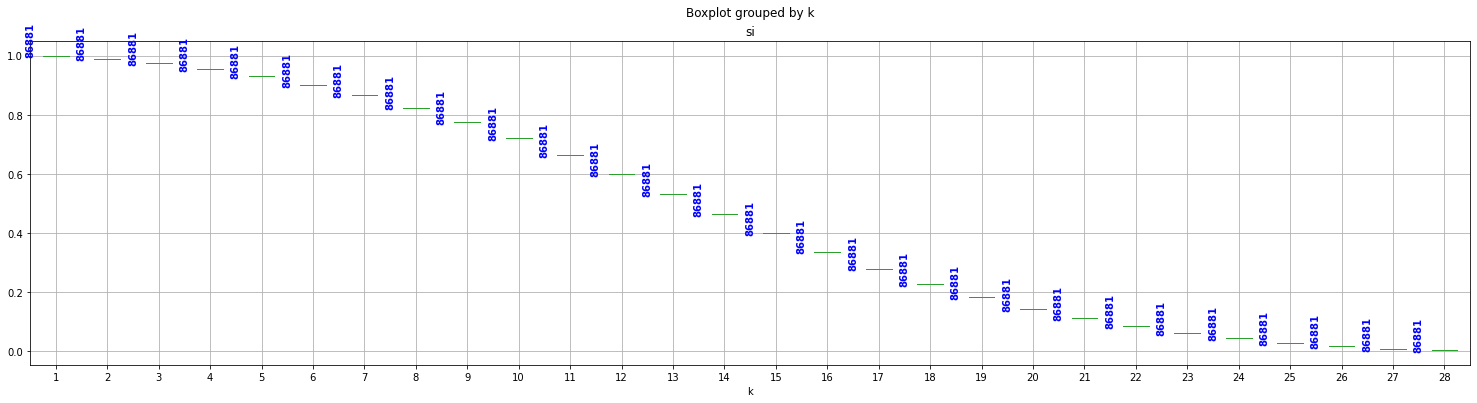

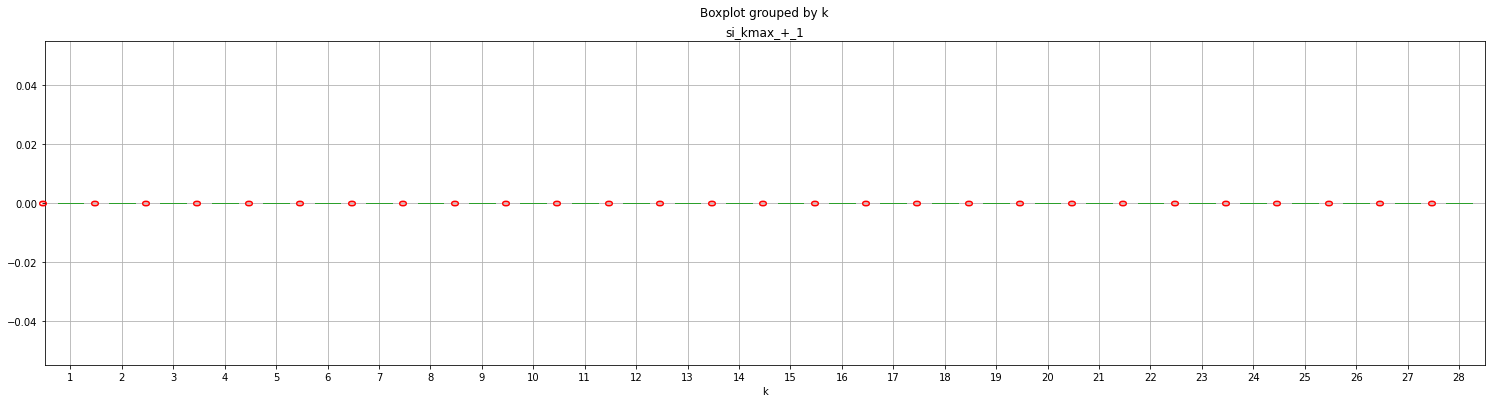

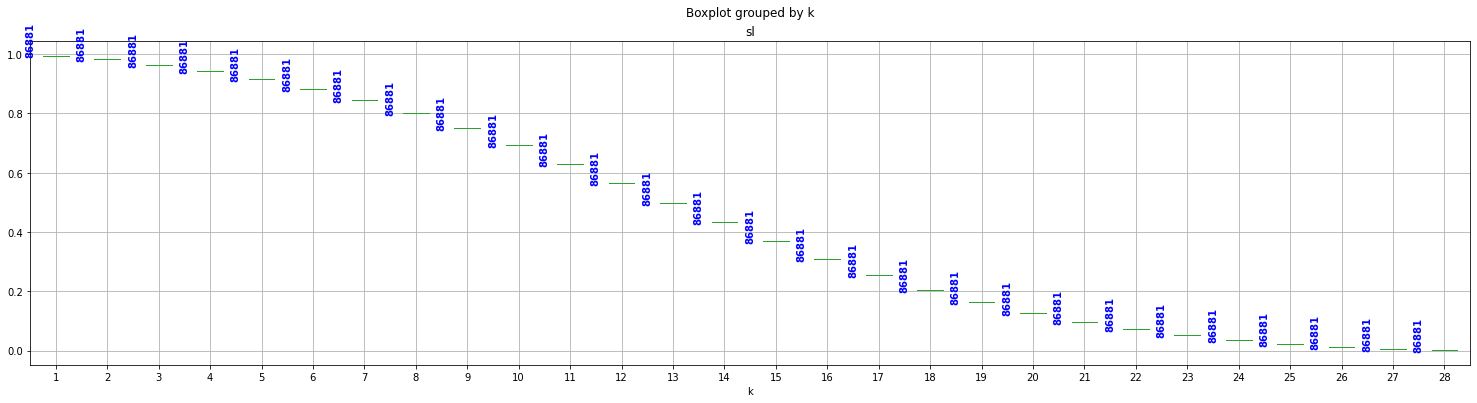

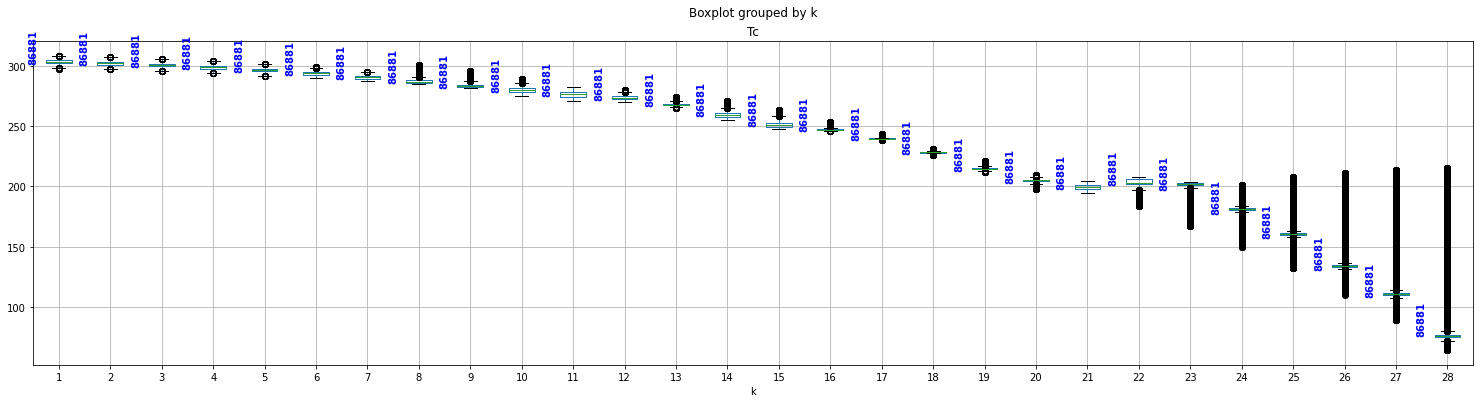

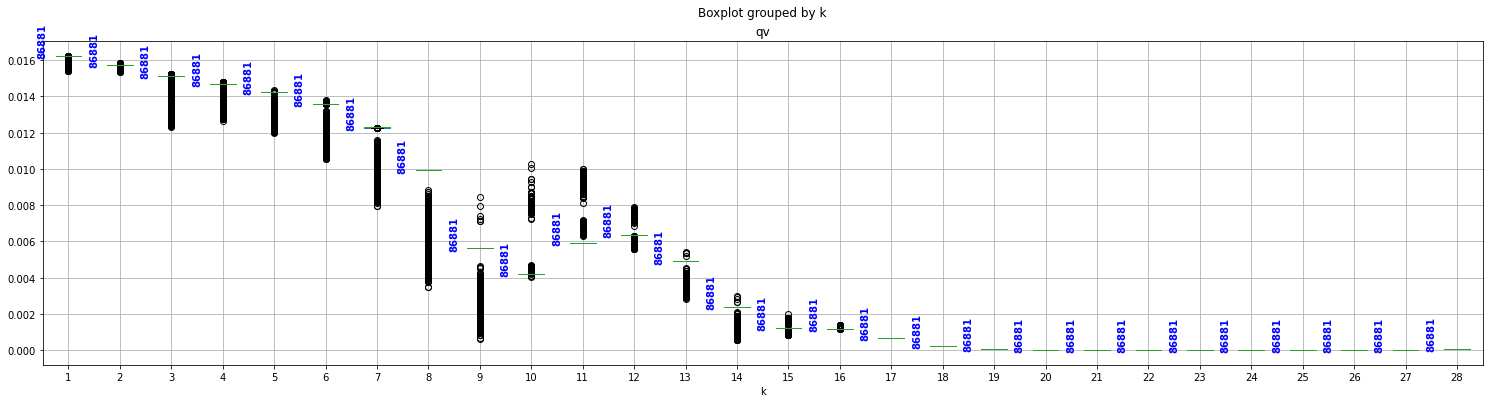

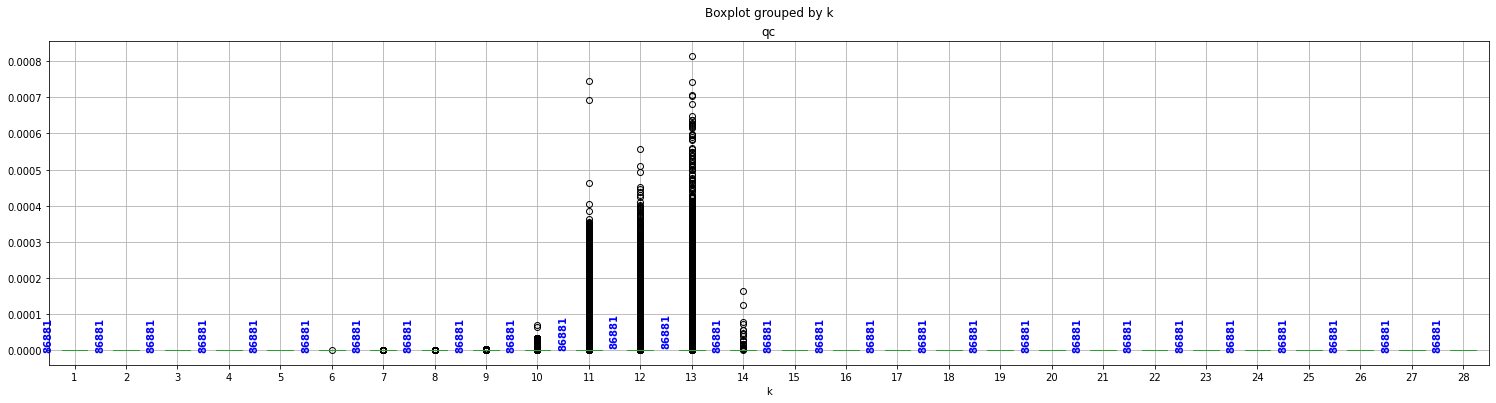

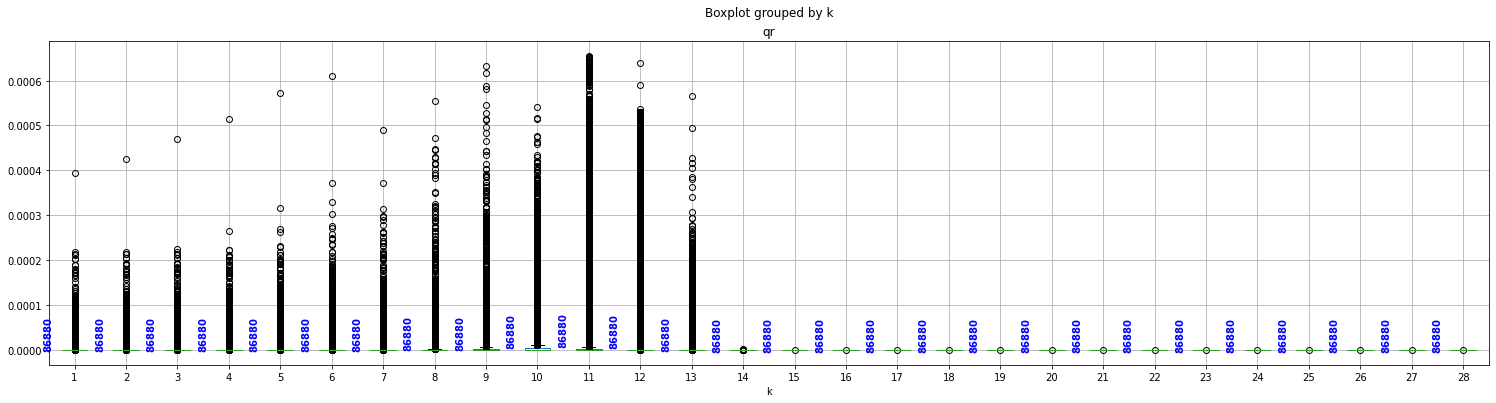

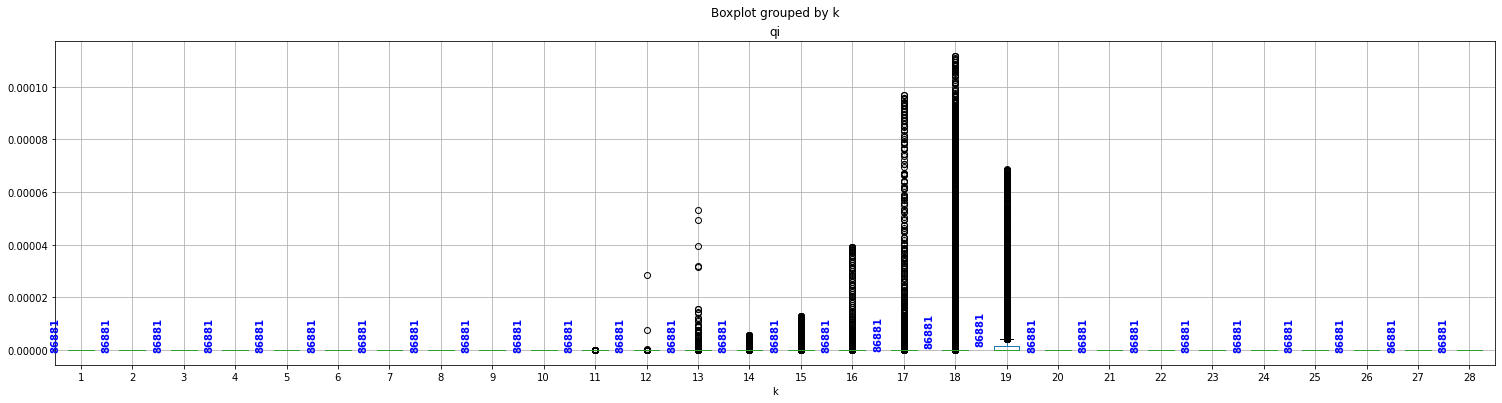

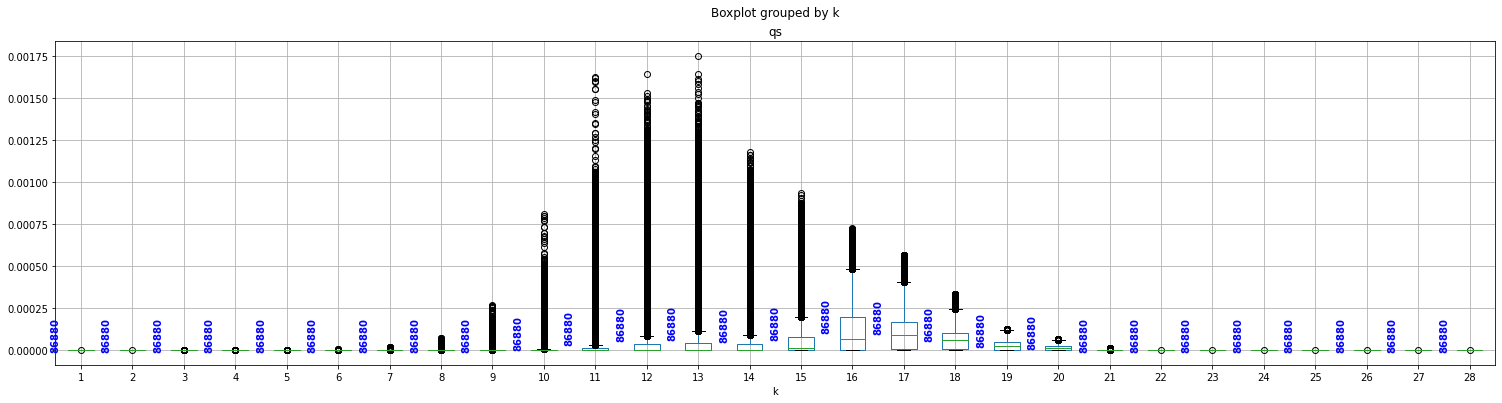

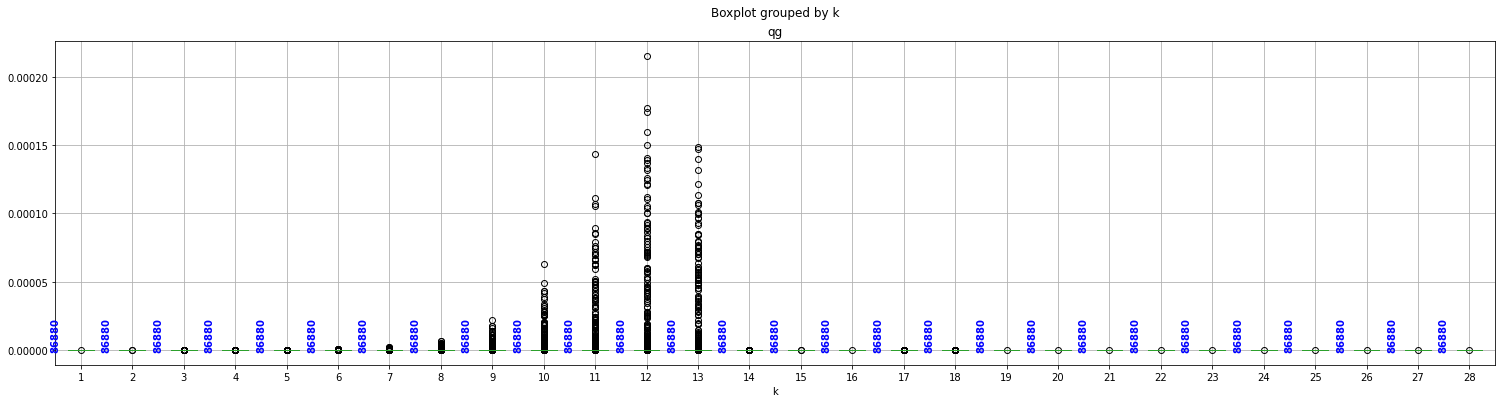

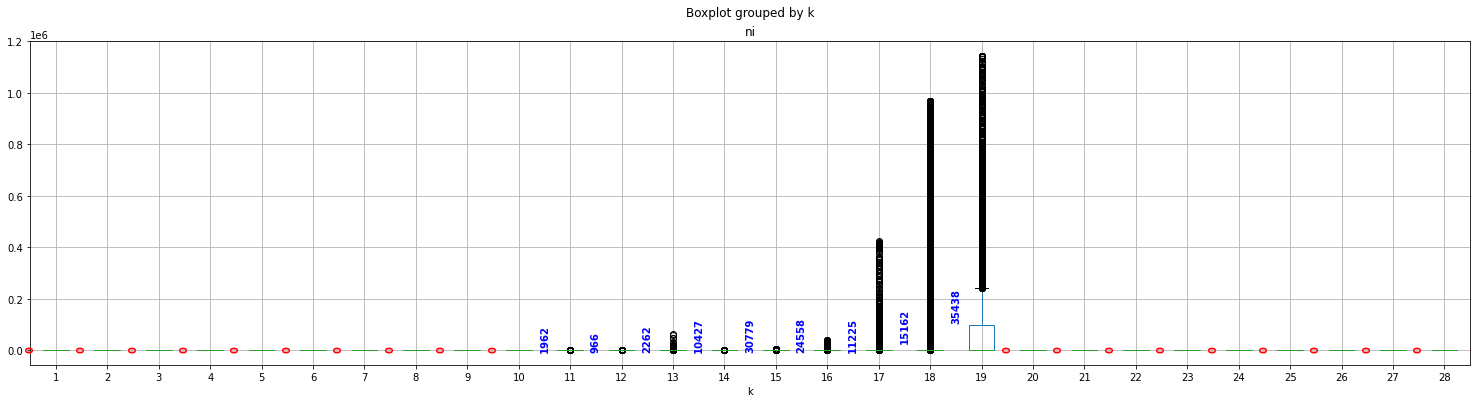

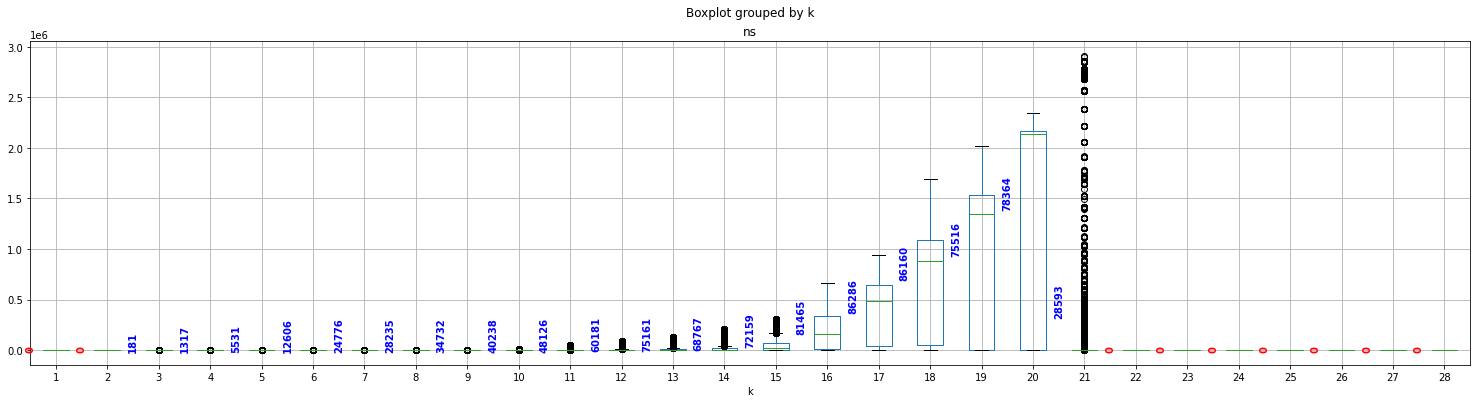

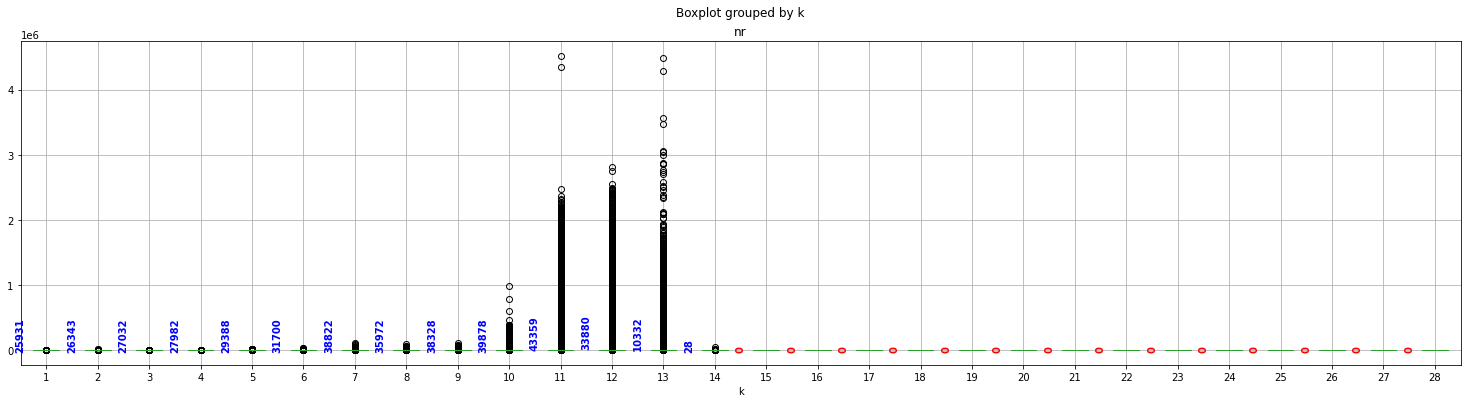

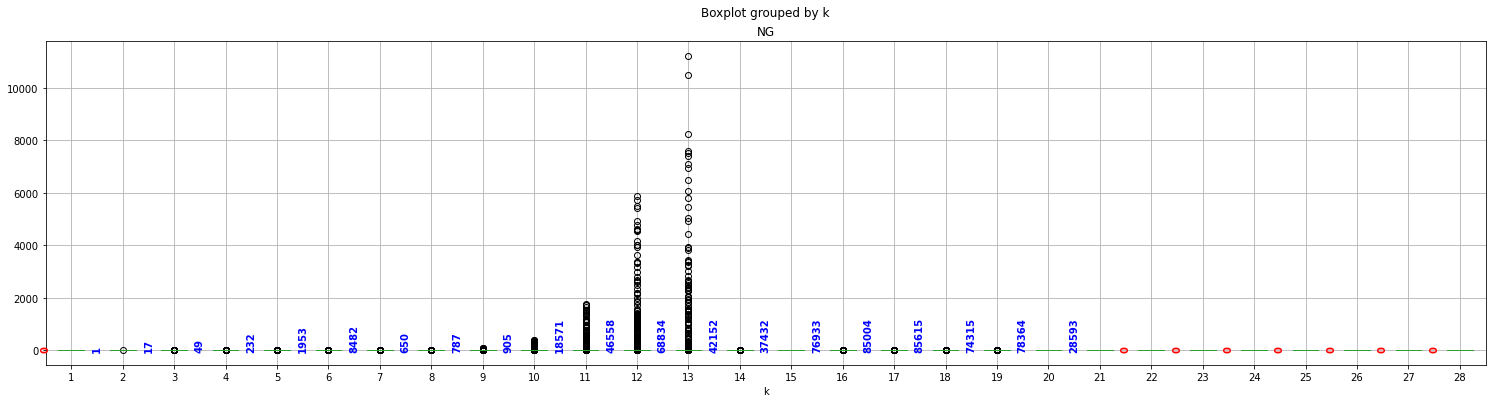

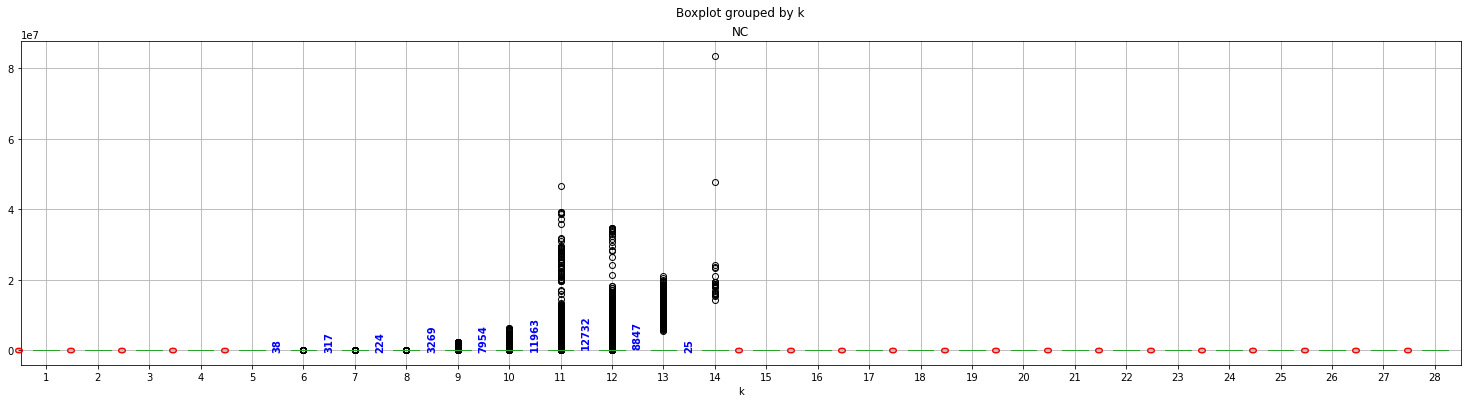

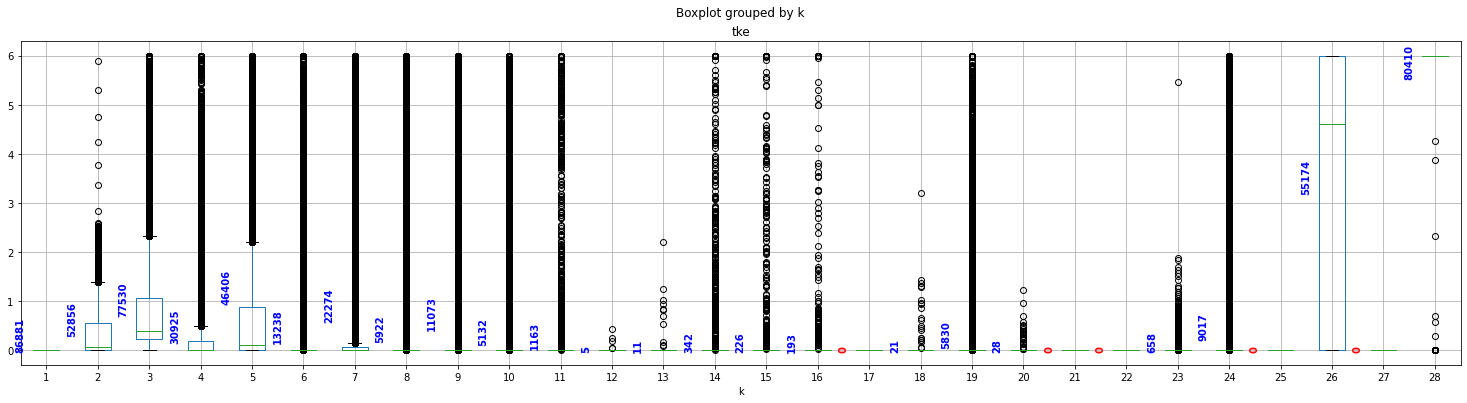

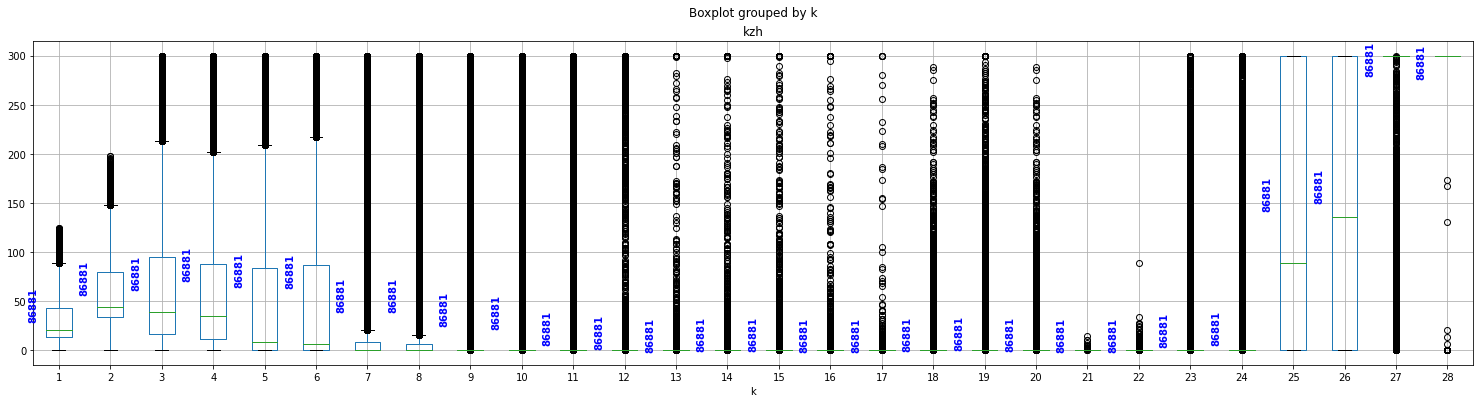

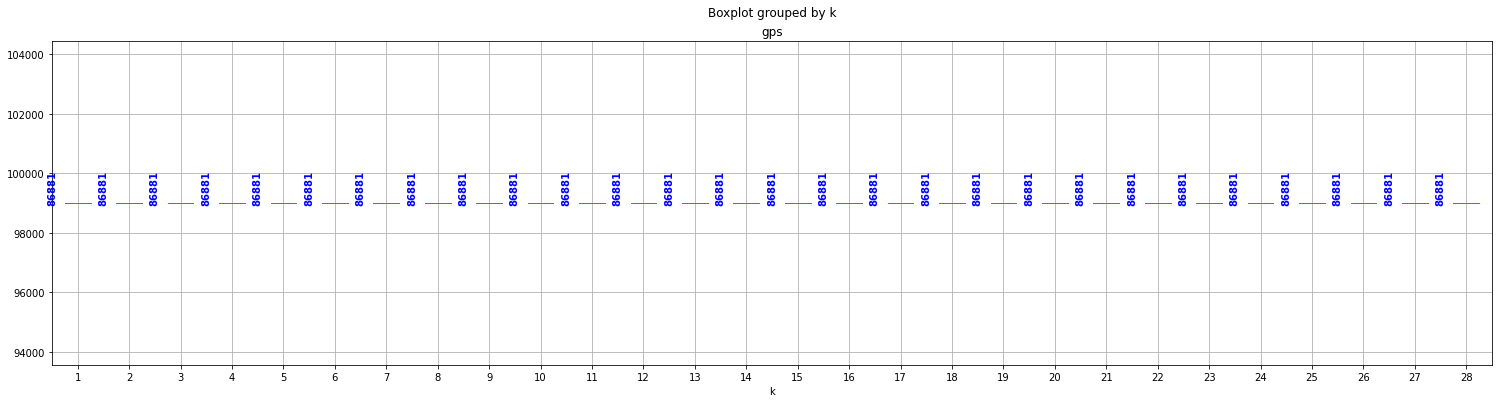

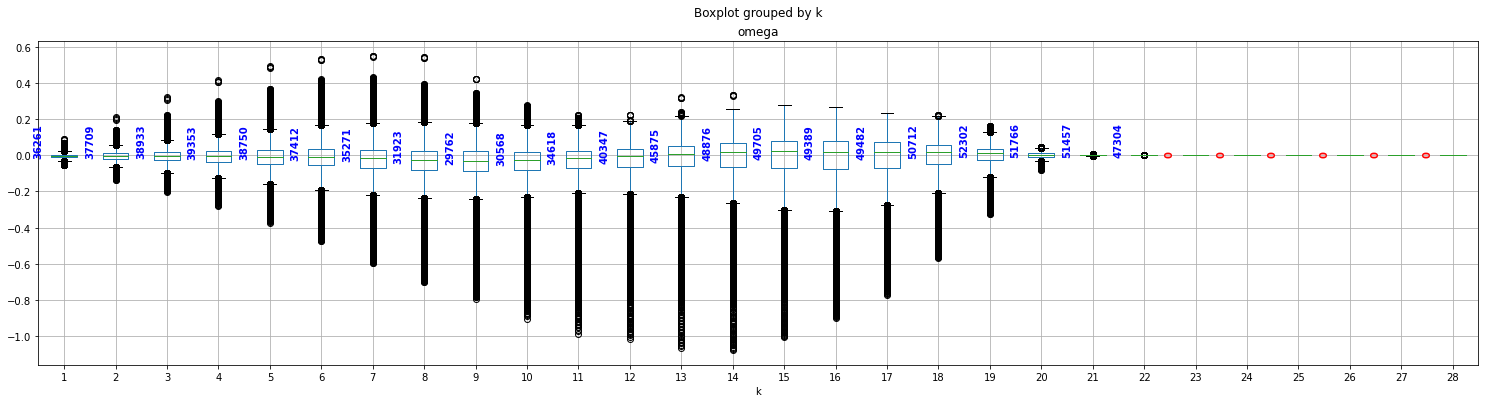

In [ ]:
# New fashion
bloxplot_levels(original_input_df)

### Boxplot das variáveis de saída, por níveis

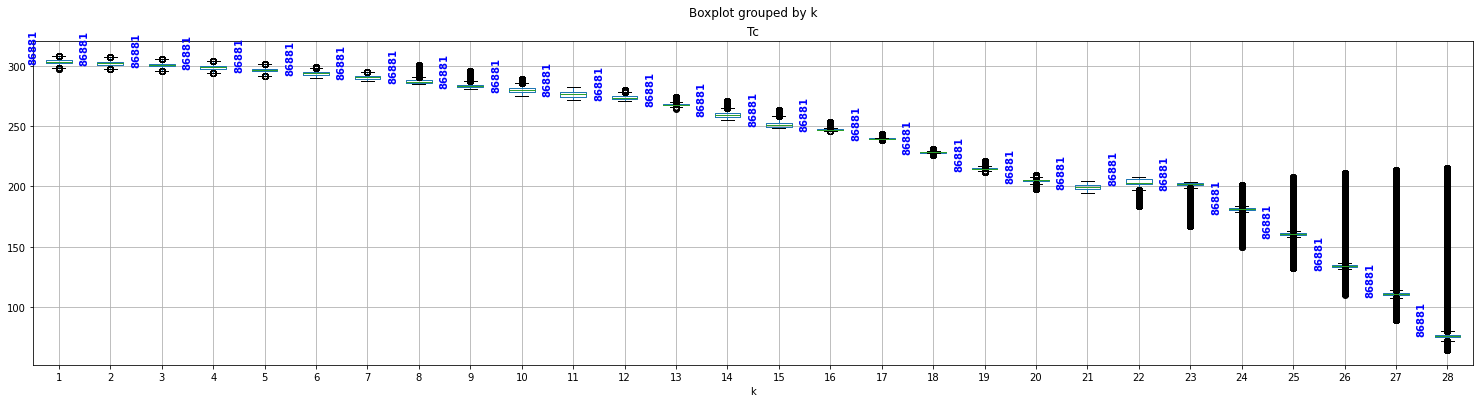

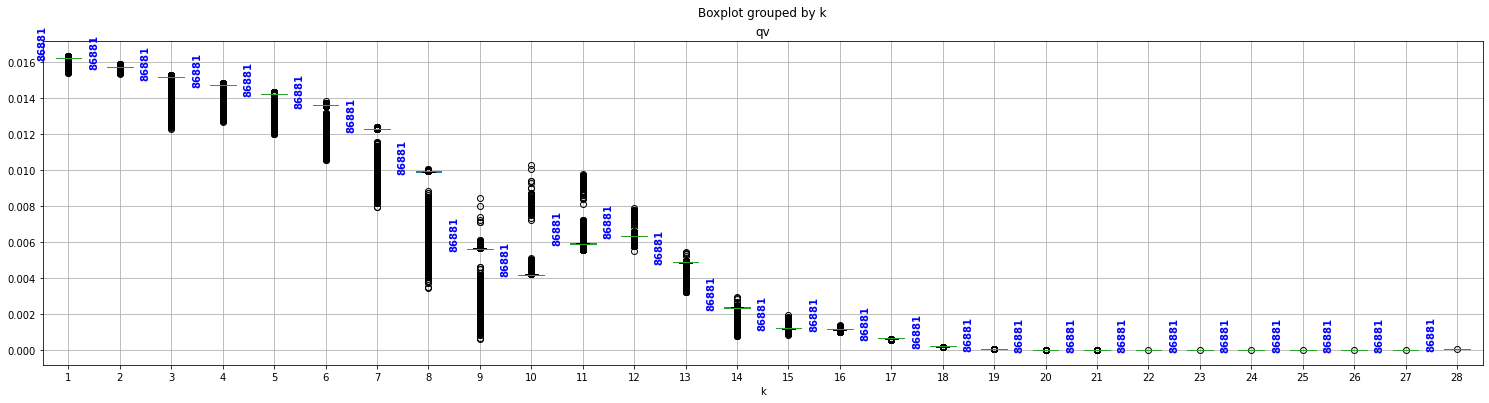

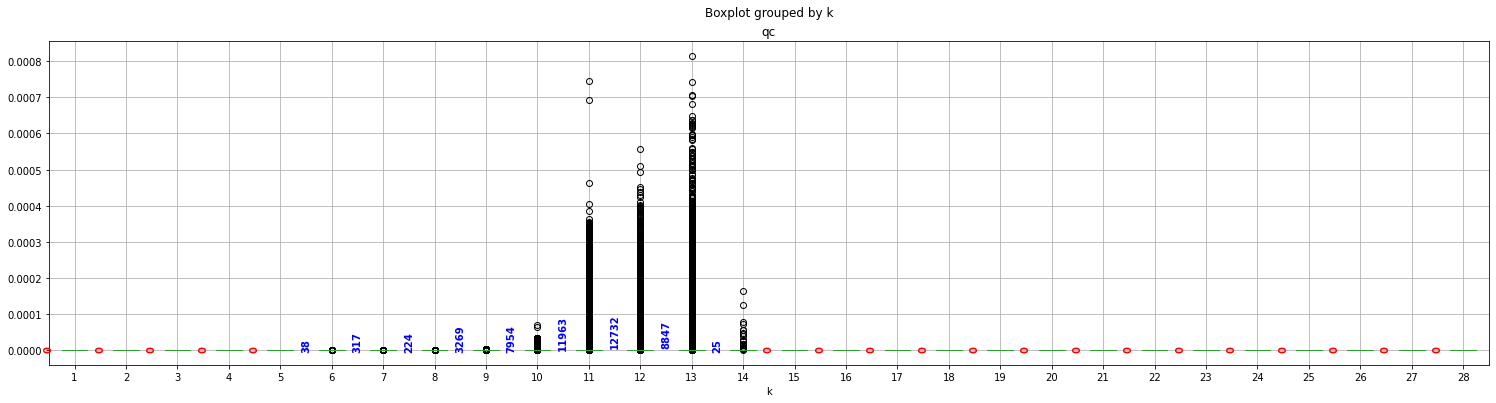

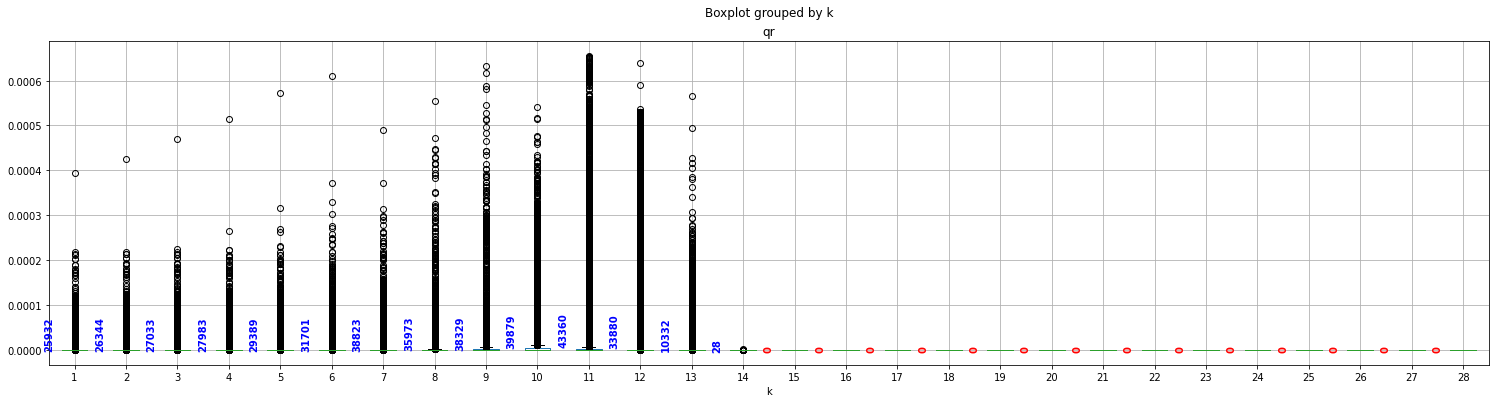

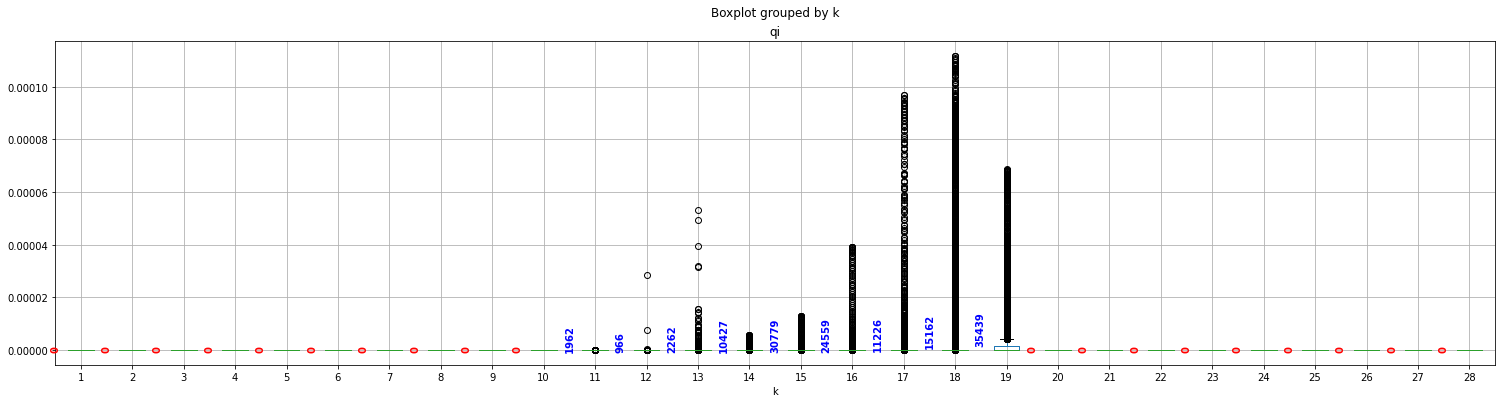

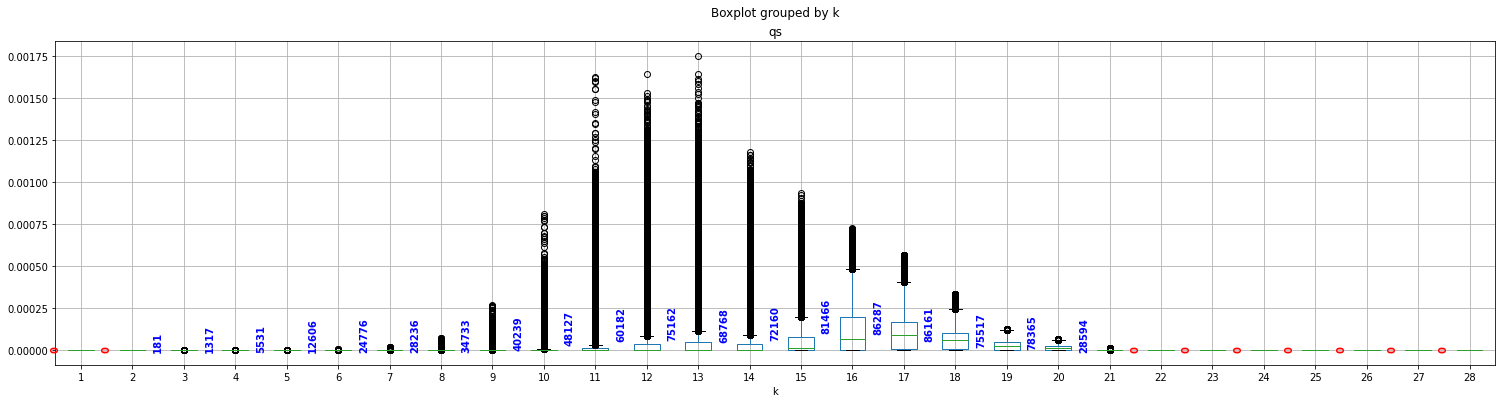

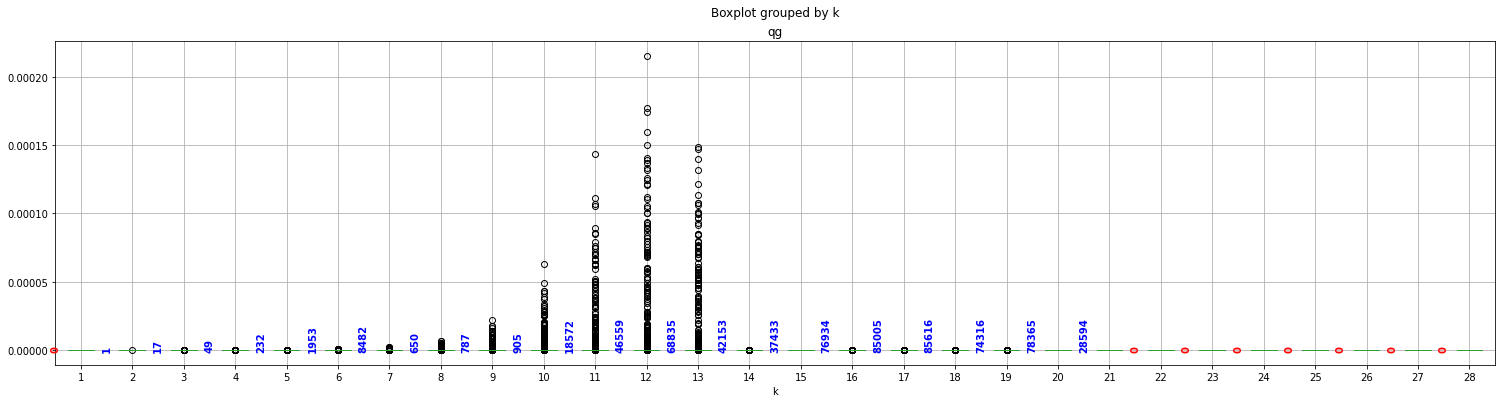

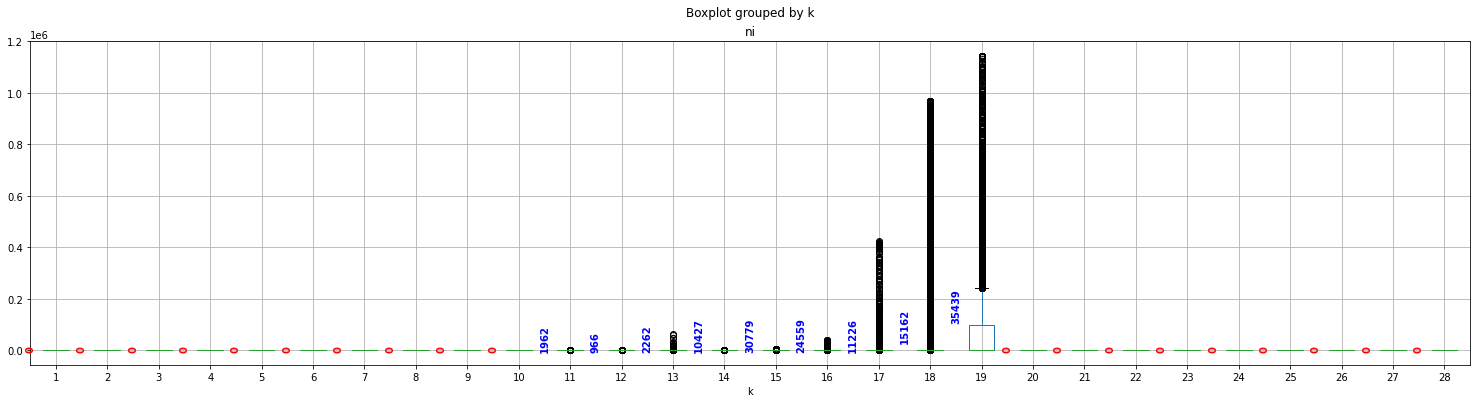

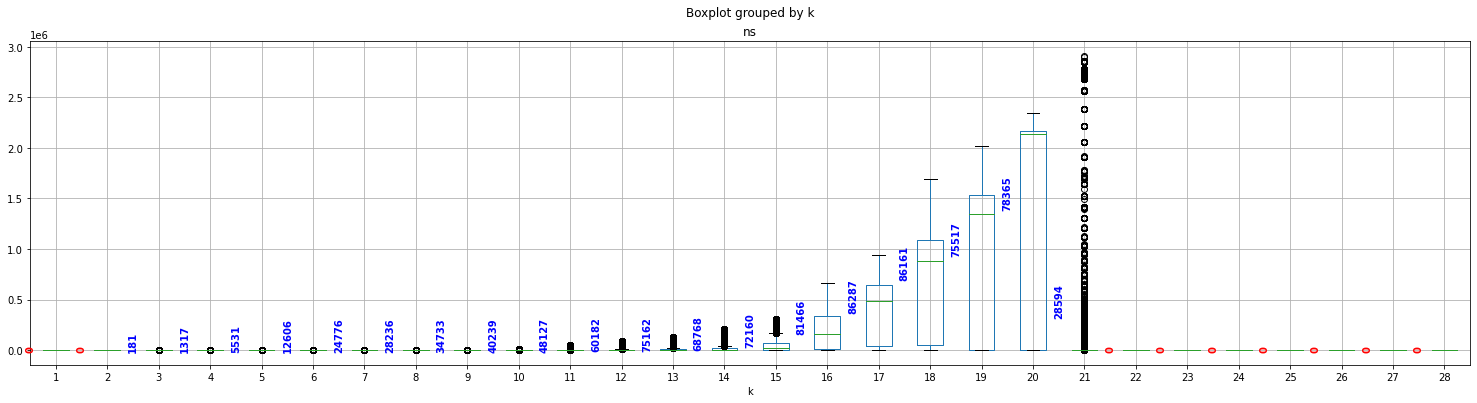

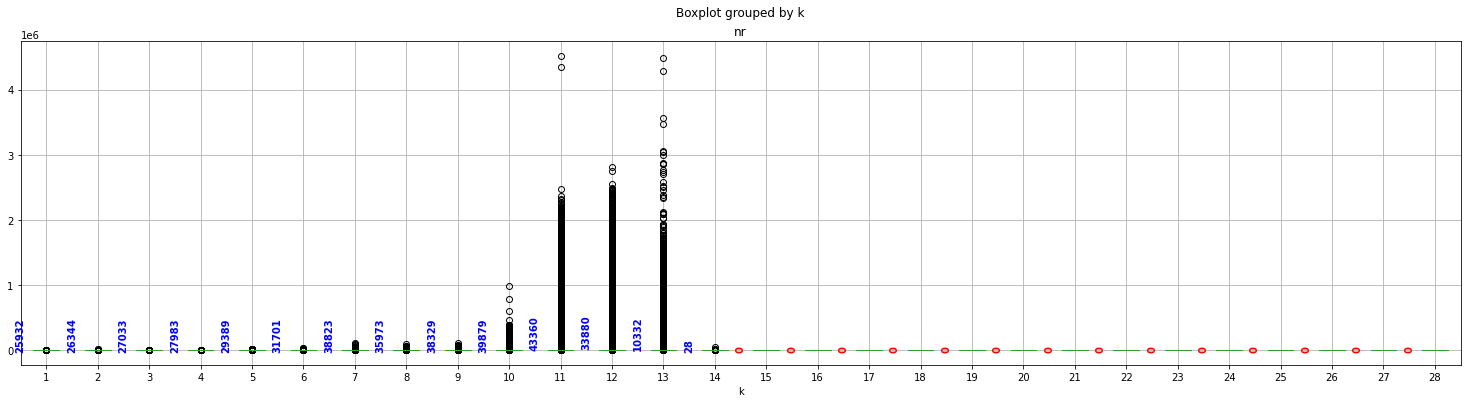

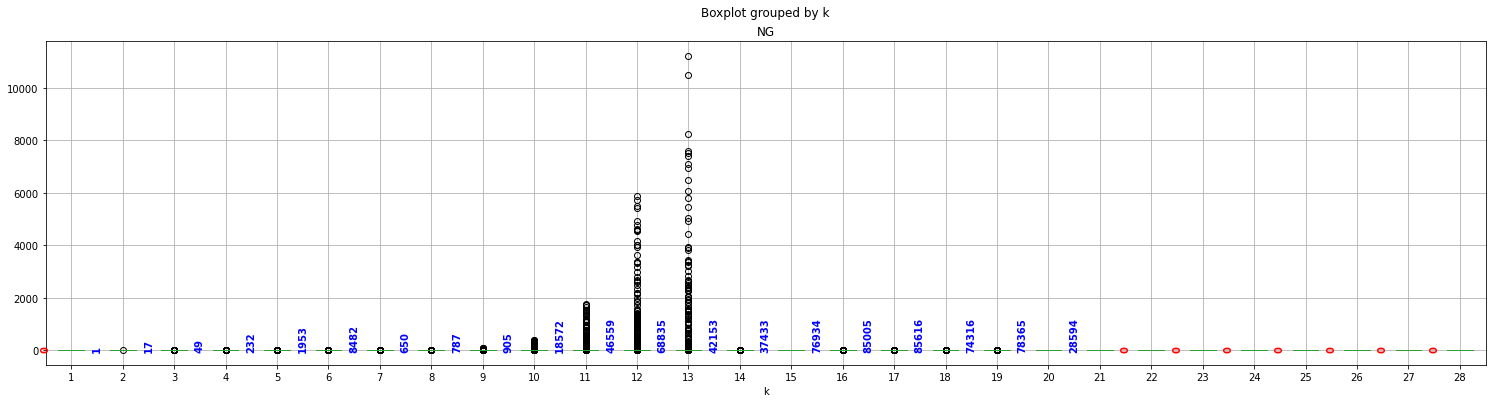

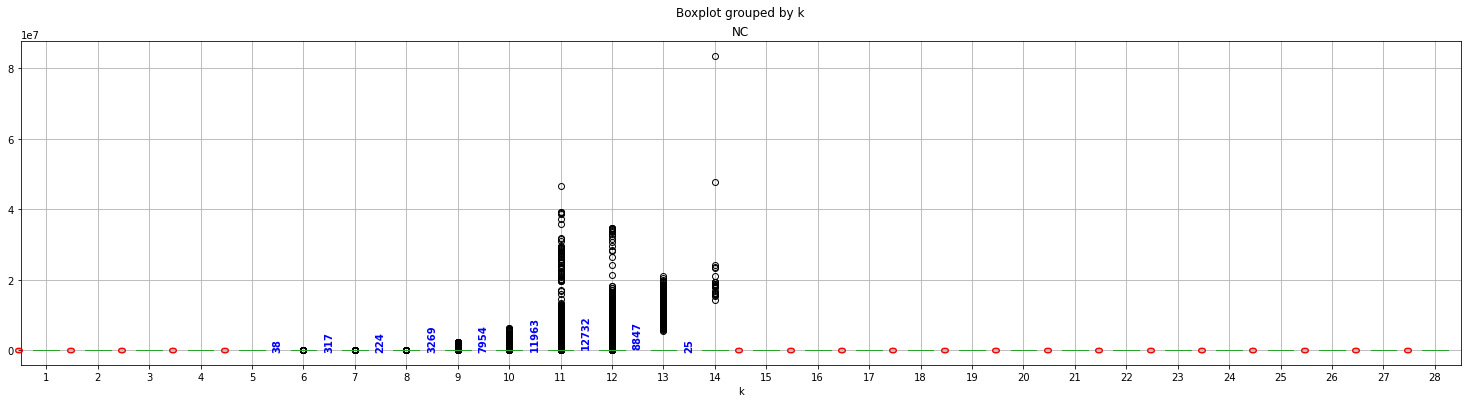

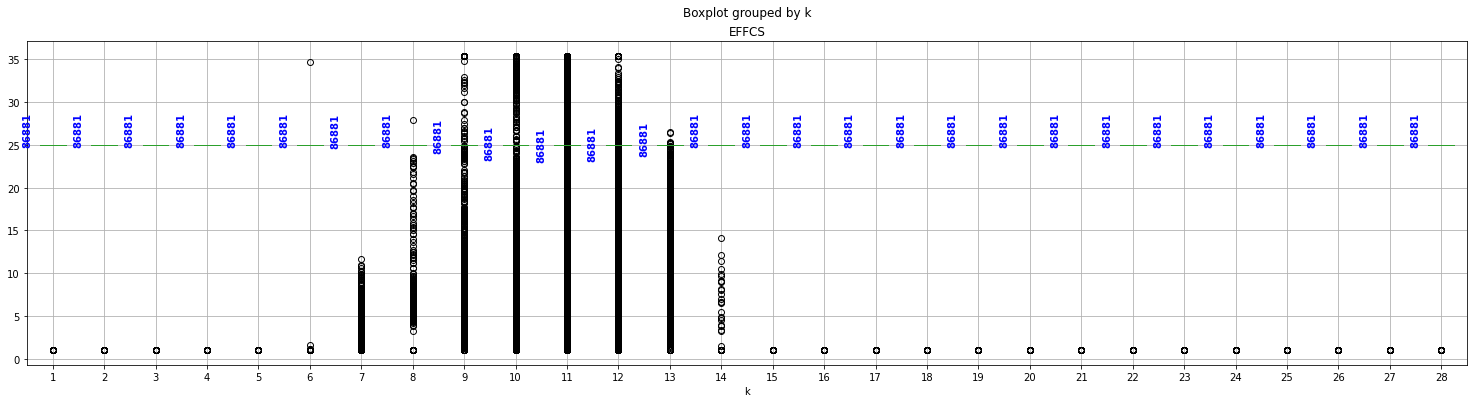

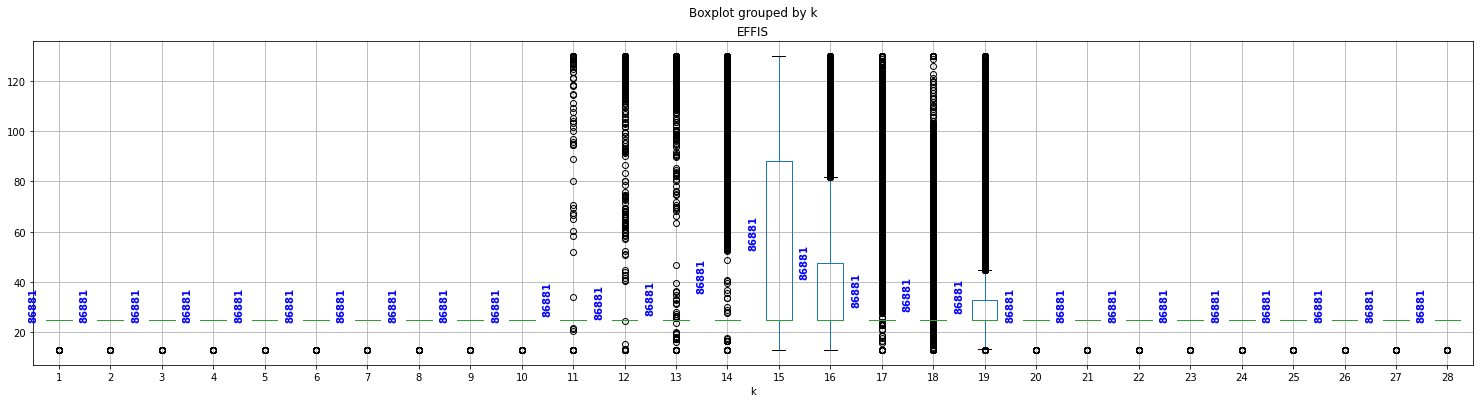

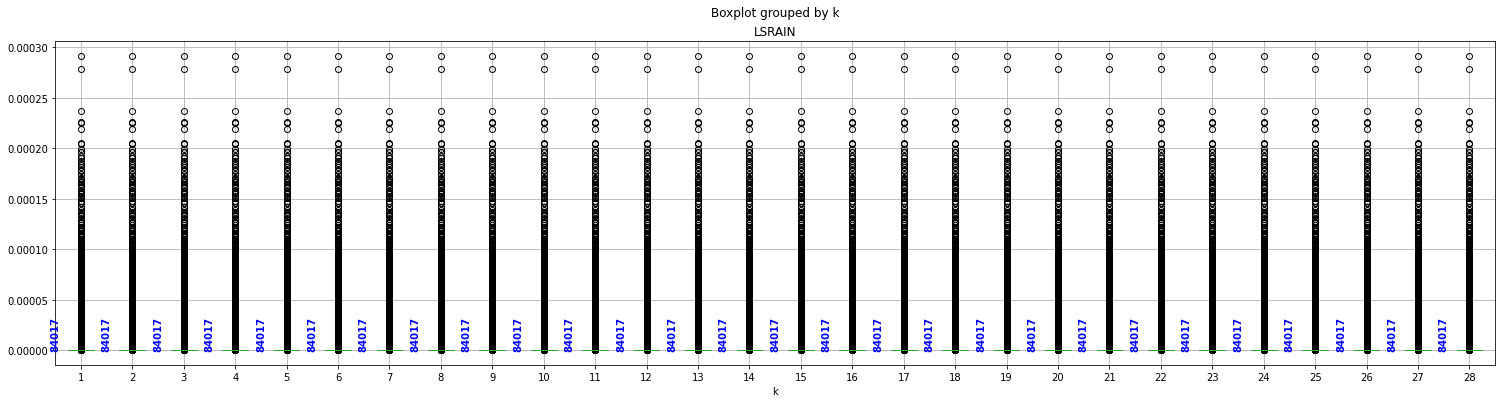

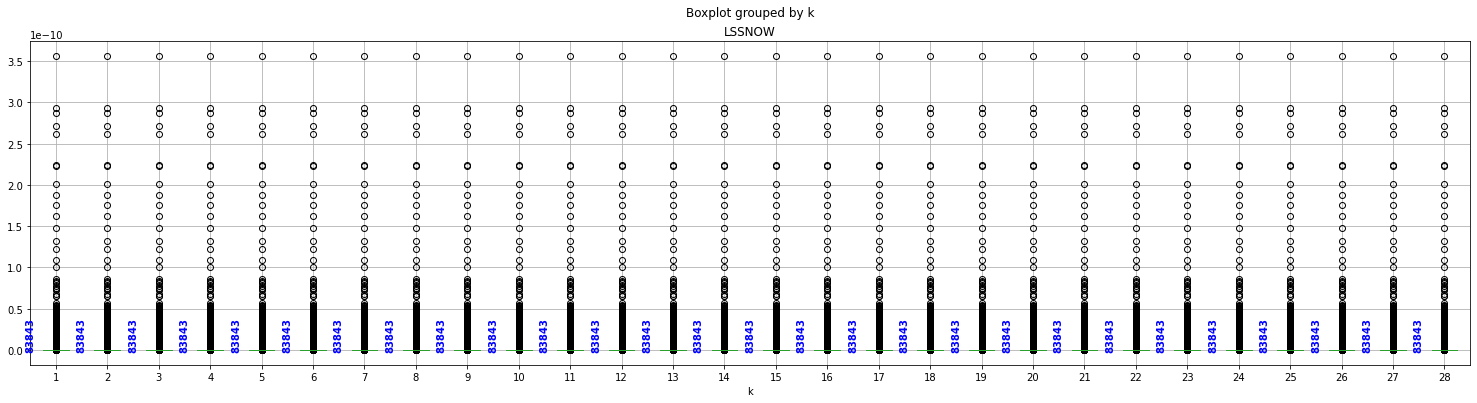

In [ ]:
# New fashion
bloxplot_levels(original_output_df)


### Gráfico de perfil vertical das variáves de entrada em 3 timesteps

In [ ]:
# Plot the vertical levels of first, 100th and last timestep

# first_timestep_input_df = original_input_df.head(k_max)
# med_timestep_input_df = original_input_df.loc[k_max00:k_max00+27]
# last_timestep_input_df = original_input_df.tail(k_max)

# idx_plot = 1
# plt.figure(figsize=(10, 10))
# for key in last_timestep_input_df.columns.tolist():
#     plt.subplot(7, 3, idx_plot)
#     plt.ylabel("k")
#     plt.xlabel(key)
#     plt.plot(first_timestep_input_df[key], first_timestep_input_df[["k"]], label="first timestep")
#     plt.plot(med_timestep_input_df[key], med_timestep_input_df[["k"]], label="100th timestep")
#     plt.plot(last_timestep_input_df[key], last_timestep_input_df[["k"]], label="last timestep")
#     idx_plot += 1
# plt.legend(loc="upper left")
# plt.subplots_adjust(hspace=1, wspace=1)
# plt.show()


# first_timestep_output_df = original_output_df.head(k_max)
# med_timestep_output_df = original_output_df.loc[k_max01:k_max01+27]
# last_timestep_output_df = original_output_df.tail(k_max)

# idx_plot = 1
# for key in last_timestep_output_df.columns.tolist():
#     plt.subplot(4, 6, idx_plot)
#     plt.ylabel("k")
#     plt.xlabel(key)
#     plt.title("Output x Level")
#     plt.plot(first_timestep_output_df[key], first_timestep_output_df[["k"]], label="first timestep")
#     plt.plot(med_timestep_output_df[key], med_timestep_output_df[["k"]], label="100th timestep")
#     plt.plot(last_timestep_output_df[key], last_timestep_output_df[["k"]], label="last timestep")
#     plt.legend()
# plt.show()

## Pré-processando a entrada (exemplos) e saídas (metas)
- Selecionamos as primeiras variáveis de entrada e saída que serão usadas no treinamento e na validação;
- também podemos criar novas variáveis como um composto de variáveis

In [ ]:
def preprocess_features(input_df):
  """Prepares input features input_df

  Args:
    input data frame: A Pandas DataFrame expected to contain data from input data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
# All input variables
# "k", "si", "si_kmax_+_1", "sl", "Tc", "qv", "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "tke", "kzh", "gps", "omega"    
  selected_features = input_df[
    [
    "k", "si", "Tc", "qv", "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "tke", "kzh", "omega"    
    ]]
  processed_features = selected_features.copy()
  return processed_features


def preprocess_targets(output_df):
  """Prepares target features (i.e., labels) from output_df

  Args:
    output_df: A Pandas DataFrame expected to contain data from output data set.
  Returns:
    A DataFrame that contains the target features.
  """
# All output variables
# "k", "Tc", "qv", "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "EFFCS", "EFFIS", "LSRAIN", "LSSNOW"
  output_targets = output_df [
      [
      "k", "Tc", "qv", "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "EFFCS", "EFFIS", "LSRAIN", "LSSNOW"
      ]
  ]
  return output_targets

In [ ]:
# execute the pre processing
all_examples = preprocess_features(original_input_df)
all_targets = preprocess_targets(original_output_df)

del original_input_df
del original_output_df


### Profiling

In [ ]:
# from pandas_profiling import ProfileReport

# all_examples_sample = all_examples.sample(int(all_examples.shape[0]*0.001))
# all_examples_sample = all_examples.sample(156)
# profile = ProfileReport(all_examples_sample, title="all examples")
# profile

In [ ]:
# profile.to_notebook_iframe()

In [ ]:
# profile.to_file(output_file='dados_sample_profile.html')

### Funções de normalização

In [ ]:
def linear_scale(serie_or_np_arr, min_val, max_val):
  # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
  #   X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
  # X_scaled = X_std * (max - min) + min  
  min, max = 0, 1
  y = lambda x:( ( x - min_val) / (max_val - min_val)) * (max - min) + min 
  return y(serie_or_np_arr)
  # Linear normalization (serie or numpy 1D array)
  # -1 e 1

def delinear_scale(serie_or_np_arr, min_val, max_val):
  # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
  #   X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
  # X_scaled = X_std * (max - min) + min  
  min, max = 0, 1
  y = lambda x: min_val + (max_val-min_val)*(x - min) / (max - min)      
  return y(serie_or_np_arr)


def linear_scale_htang(serie_or_np_arr, min_val, max_val):
  scale = (max_val - min_val) / 2.0
  y = lambda x:((x - min_val) / scale) - 1.0
  return y(serie_or_np_arr)

# old bak
# def linear_scale(serie_or_np_arr):
#   min_val = serie_or_np_arr.min()
#   max_val = serie_or_np_arr.max()
#   scale = (max_val - min_val) / 2.0
#   y = lambda x:((x - min_val) / scale) - 1.0
#   return y(serie_or_np_arr), min_val, max_val


# Linear denormalization (serie or numpy 1D array)
#
# enter with min and max val of values before normalization
def delinear_scale_htang(serie_or_np_arr, min_val, max_val):
  scale = (max_val - min_val) / 2.0
  y = lambda x:((x + 1.0) * scale) + min_val
  return y(serie_or_np_arr)


# Different normalilzation functions

def log_normalize(series):
  return series.apply(lambda x:math.log(x+1.0))

def clip(series, clip_to_min, clip_to_max):
  return series.apply(lambda x:(
    min(max(x, clip_to_min), clip_to_max)))

def z_score_normalize(series):
  mean = series.mean()
  std_dv = series.std()
  return series.apply(lambda x:(x - mean) / std_dv)

def binary_threshold(series, threshold):
  return series.apply(lambda x:(1 if x > threshold else 0))


# cols = ['A', 'B']
# data =  pd.DataFrame(np.array([[2,3],[1.02,1.2],[0.5,0.3]]),columns=cols)
# serie = [2, 1.02, 0.5]
# display.display(data)

# scaler = preprocessing.MinMaxScaler(feature_range = (0,1))
# scaled_data = scaler.fit_transform(data[cols])
# display.display(scaled_data)

# scaled_data = linear_scale(data, 0.5, 2.0)
# display.display(scaled_data)

# de_scaled_data = delinear_scale(scaled_data, 0.5, 2.0)
# display.display(de_scaled_data)

# inv = scaler.inverse_transform(scaled_data)
# display.display(inv)


### Normalização da base usando escala linear

Normalização das entradas para a escala -1, 1. para os primeiros testes

Como regra geral, o NN treina melhor quando os recursos de entrada estão aproximadamente na mesma escala.

Isso ajuda o NN a não ficar preso em etapas que são muito grandes em uma dimensão ou muito pequenas em outra.


In [ ]:
def normalize_linear_scale(examples_dataframe, minmax_dict=None, scaler="normalize", minmax_border_perc=0.2):
  """Returns a version of the input `DataFrame` that has all its features normalized linearly."""

  # Convert pandas data into a dict of np arrays.
  processed_features = examples_dataframe.copy()

  for key,value in dict(examples_dataframe).items():
    if key != 'k':
      if minmax_dict is None:
        min_val = value.min() - value.min()*minmax_border_perc
        max_val = value.max() + value.max()*minmax_border_perc
      else:
        min_val = minmax_dict[key][0]
        max_val = minmax_dict[key][1]
      if scaler == "normalize":
        processed_features[key] = linear_scale(value, min_val, max_val)
      else:
        processed_features[key] = linear_scale_htang(value, min_val, max_val)
  return processed_features


### Análise estatística

In [ ]:
normalized_all_examples = normalize_linear_scale(all_examples)
normalized_all_targets = normalize_linear_scale(all_targets)

print("\nAll input summary:")
display.display(normalized_all_examples.describe())
print("\nAll output summary:")
display.display(normalized_all_targets.describe())


All input summary:


k             si  ...            kzh          omega
count 2432668.000000 2432668.000000  ... 2432668.000000 2432668.000000
mean       14.500000       0.388965  ...       0.135901       0.557771
std         8.077749       0.303710  ...       0.277633       0.051891
min         1.000000       0.000613  ...       0.000017      -0.141361
25%         7.750000       0.084327  ...       0.000211       0.549803
50%        14.500000       0.358631  ...       0.000211       0.565445
75%        21.250000       0.694645  ...       0.077527       0.575340
max        28.000000       0.832925  ...       0.833322       0.927574

[8 rows x 17 columns]


All output summary:


k             Tc  ...         LSRAIN         LSSNOW
count 2432668.000000 2432668.000000  ... 2432668.000000 2432668.000000
mean       14.500000       0.584753  ...       0.003878       0.000473
std         8.077749       0.192558  ...       0.022359       0.008081
min         1.000000       0.040194  ...      -0.000000      -0.000000
25%         7.750000       0.473479  ...       0.000000       0.000000
50%        14.500000       0.646551  ...       0.000000       0.000000
75%        21.250000       0.745046  ...       0.000069       0.000001
max        28.000000       0.806537  ...       0.833333       0.833333

[8 rows x 17 columns]

#### Correlação


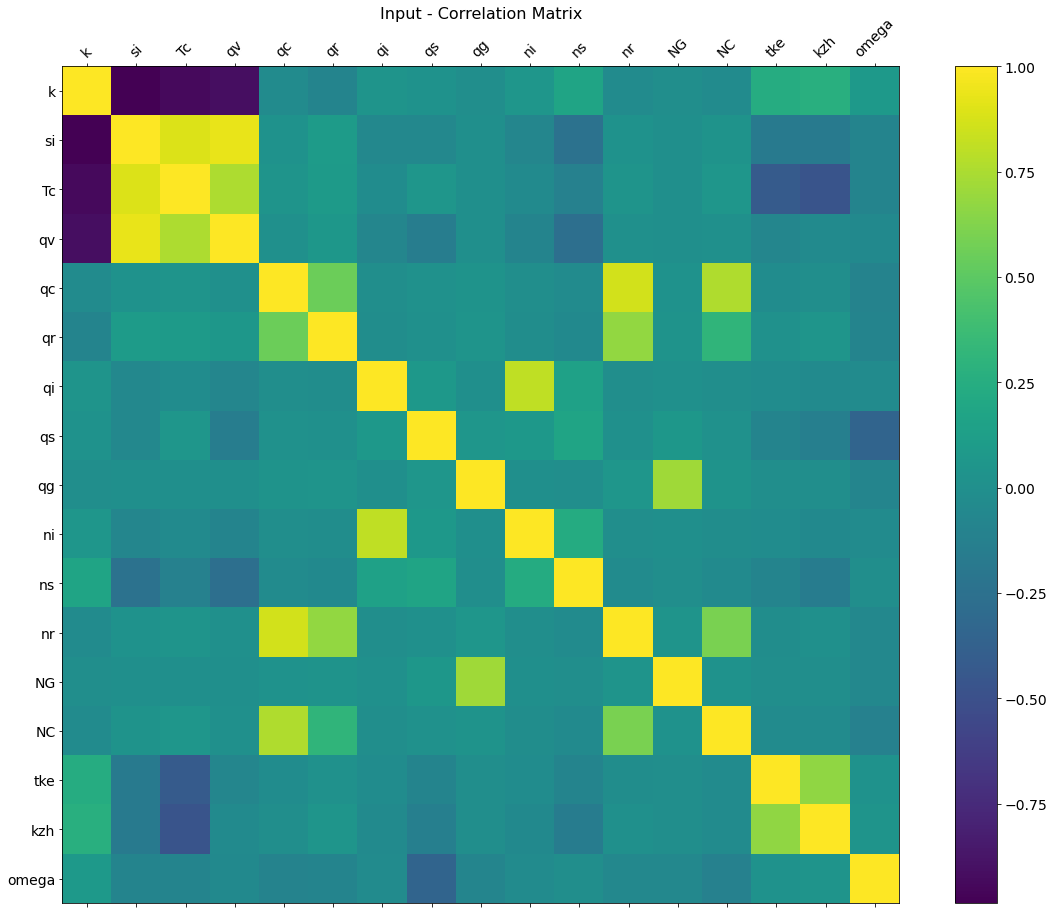

In [ ]:
# Matrix - entrada
f = plt.figure(figsize=(20, 15))
plt.matshow(normalized_all_examples.corr(), fignum=f.number)
plt.xticks(range(normalized_all_examples.select_dtypes(['number']).shape[1]), normalized_all_examples.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(normalized_all_examples.select_dtypes(['number']).shape[1]), normalized_all_examples.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Input - Correlation Matrix', fontsize=16);

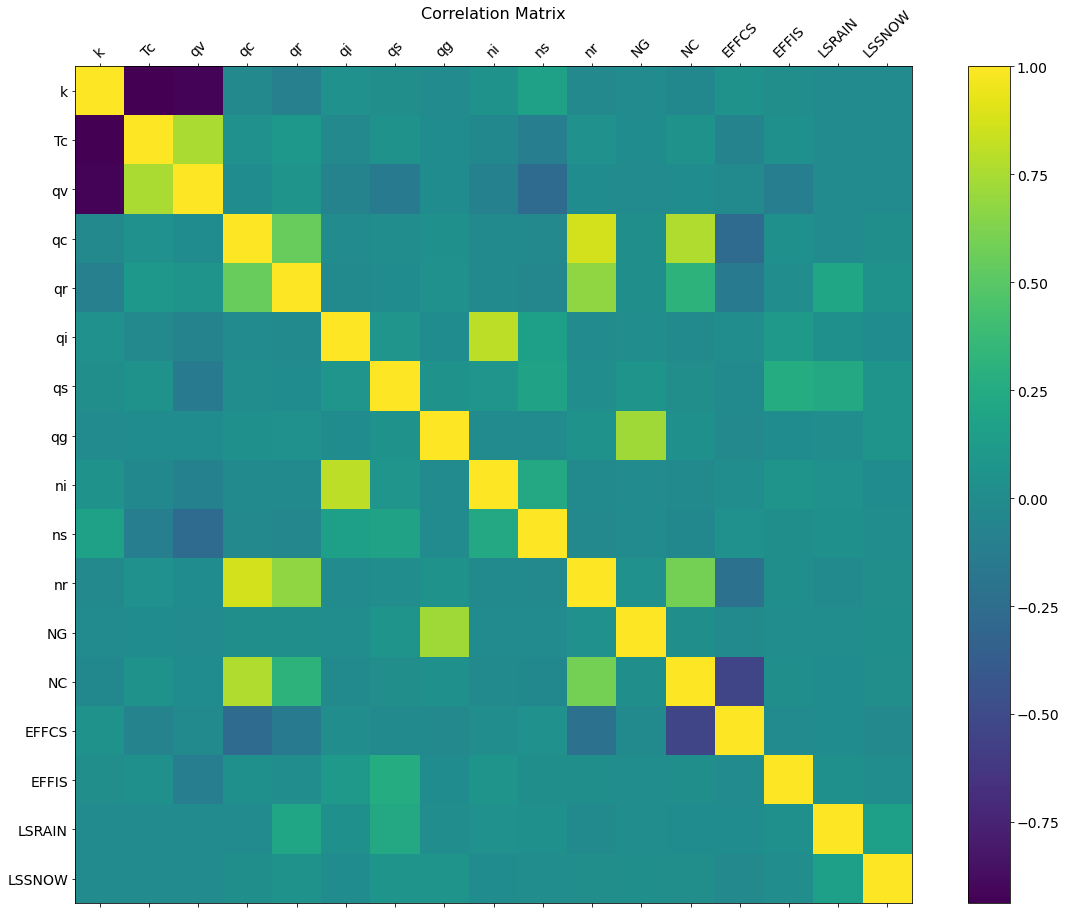

In [ ]:
# Matrix - saída
f = plt.figure(figsize=(20, 15))
plt.matshow(normalized_all_targets.corr(), fignum=f.number)
plt.xticks(range(normalized_all_targets.select_dtypes(['number']).shape[1]), normalized_all_targets.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(normalized_all_targets.select_dtypes(['number']).shape[1]), normalized_all_targets.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [ ]:

def calcDrop(res):
    # All variables with correlation > cutoff
    all_corr_vars = list(set(res['v1'].tolist() + res['v2'].tolist()))
    
    # All unique variables in drop column
    poss_drop = list(set(res['drop'].tolist()))

    # Keep any variable not in drop column
    keep = list(set(all_corr_vars).difference(set(poss_drop)))
     
    # Drop any variables in same row as a keep variable
    p = res[ res['v1'].isin(keep)  | res['v2'].isin(keep) ][['v1', 'v2']]
    q = list(set(p['v1'].tolist() + p['v2'].tolist()))
    drop = (list(set(q).difference(set(keep))))

    # Remove drop variables from possible drop 
    poss_drop = list(set(poss_drop).difference(set(drop)))
    
    # subset res dataframe to include possible drop pairs
    m = res[ res['v1'].isin(poss_drop)  | res['v2'].isin(poss_drop) ][['v1', 'v2','drop']]
        
    # remove rows that are decided (drop), take set and add to drops
    more_drop = set(list(m[~m['v1'].isin(drop) & ~m['v2'].isin(drop)]['drop']))
    for item in more_drop:
        drop.append(item)
         
    return drop


def corrX_new(df, cut = 0.9) :
       
    # Get correlation matrix and upper triagle
    corr_mtx = df.corr().abs()
    avg_corr = corr_mtx.mean(axis = 1)
    up = corr_mtx.where(np.triu(np.ones(corr_mtx.shape), k=1).astype(np.bool))
    
    dropcols = list()
    
    res = pd.DataFrame(columns=(['v1', 'v2', 'v1.target', 
                                 'v2.target','corr', 'drop' ]))
    
    for row in range(len(up)-1):
        col_idx = row + 1
        for col in range (col_idx, len(up)):
            if(corr_mtx.iloc[row, col] > cut):
                if(avg_corr.iloc[row] > avg_corr.iloc[col]): 
                    dropcols.append(row)
                    drop = corr_mtx.columns[row]
                else: 
                    dropcols.append(col)
                    drop = corr_mtx.columns[col]
                
                s = pd.Series([ corr_mtx.index[row],
                up.columns[col],
                avg_corr[row],
                avg_corr[col],
                up.iloc[row,col],
                drop],
                index = res.columns)
        
                res = res.append(s, ignore_index = True)
    
    dropcols_names = calcDrop(res)
    
    return(dropcols_names)
    
# Variaveis de entrada mais correlacionadas

# Solucao 1 - remove todas
# Create correlation matrix
corr_matrix = normalized_all_examples.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# display.display(upper)
# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
print("Solução 1:")
display.display(to_drop)

# Solução 2 - melhor
to_drop = corrX_new(normalized_all_examples, 0.9)
print("Solução 2:")
display.display(to_drop)


Solução 1:


['si', 'Tc', 'qv']

Solução 2:


['si', 'k']

Removendo colunas altamente correlacionadas

In [ ]:
normalized_all_examples.drop(['NG', 'si'], axis=1, inplace=True)

#### Boxplot das variáveis de entrada linearmente normalizadas

In [ ]:
# bloxplot_levels(normalized_all_examples)
# # normalized_all_examples_htang = normalize_linear_scale(all_examples, scaler="htang")

#### Boxplot das variáveis de saída linearmente normalizadas

In [ ]:
# bloxplot_levels(normalized_all_targets)


### Normalização da base usando diferentes escalas para cada variável

- Diferentes normalizações por variável, como linear, logarítimica e z-score


In [ ]:
def normalize_examples(examples_dataframe):
  # "k", "si", "sl", "Tc", "qv", "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "tke", "kzh", "omega"
  processed_features = pd.DataFrame()

  if len(examples_dataframe["k"]) > 0:
    processed_features["k"] = examples_dataframe["k"]

  for m_var in [ "si", "Tc", "qv"]:
    processed_features[m_var] = linear_scale(examples_dataframe[m_var], examples_dataframe[m_var].min(), examples_dataframe[m_var].max())

  for m_var in [ "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "tke", "kzh"]:
    processed_features[m_var] = log_normalize(examples_dataframe[m_var])

  processed_features["omega"] = z_score_normalize(examples_dataframe["omega"])
  # processed_features["population"] = linear_scale(clip(examples_dataframe["population"], 0, 5000))
    
  return processed_features


#### Boxplot das variáveis de entrada com diferentes normalizações

In [ ]:
# normalized_all_examples = normalize_examples(all_examples)
# normalized_all_targets = normalize_linear_scale(all_targets)

# print("All normalized examples summary:")
# display.display(normalized_all_examples.describe())

# print("All normalized targets summary:")
# display.display(normalized_all_targets.describe())


# # Boxplot of variables through levels
# for key in normalized_all_examples.columns.tolist():
#     if key == "k": continue
#     # plt.subplot(6, 2, idx_plot)
#     normalized_all_examples.boxplot(column=key, by="k", figsize=(15, 6))
# plt.show()

## Amostras dos Conjuntos de treinamento e validação

Exibe  o resumo de entrada e saída de conjuntos de treinamento e validação, para verificar a homogeneidade desses conjuntos


In [ ]:
def get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, train_percent_size):
  # Choose the first x percent for training.
  all_size = len(normalized_all_examples)
  train_size = int(all_size * train_percent_size / k_max)*k_max
  print("train size = {}".format(train_size))

  normalized_training_examples = normalized_all_examples.head(train_size)
  normalized_training_targets = normalized_all_targets.head(train_size)

  # Choose the last (10%) (out of 265468) for validation.
  normalized_validation_examples = normalized_all_examples.iloc[train_size:]
  normalized_validation_targets = normalized_all_targets.iloc[train_size:]
  return normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets


# versão atual que grava primeiro por variavel depois por nivel, e remove niveis de LSRAIN e LSSNOW
def get_df_col_k(df_orig, k_inicial, k_final, dic_var_levs_exclude=None):
  
  print(df_orig.columns)
  dic_var_levs_exclude_ok = { \
  'LSRAIN':range(2,29),
  'LSSNOW':range(2,29)
  }  
  if dic_var_levs_exclude is not None:
    dic_var_levs_exclude_ok.update(dic_var_levs_exclude)
    
  df_col_k = pd.DataFrame()
  for col in df_orig.columns.tolist():
    if col == 'k':
        continue
    for k in range(k_inicial, k_final + 1):
      df = df_orig.copy()
      df_k = df[df['k'] == k]
      if col in dic_var_levs_exclude_ok.keys() and k in dic_var_levs_exclude_ok[col]:
          continue
      df_col_k['{}_k{}'.format(col, k)] = df_k[col].to_numpy()
  return df_col_k


# versão anterior que grava primeiro por nivel depois por variavel
# def get_df_col_k(df_orig, k_inicial, k_final, dic_var_levs_exclude=None):
#   df_col_k = pd.DataFrame()
#     df = df_orig.copy()
#     df_k = df[df['k'] == k]
#     for col in df.columns.tolist():
#       if col == 'k':
#         continue
#       if dic_var_levs_exclude is not None and col in dic_var_levs_exclude.keys():
#         if k in dic_var_levs_exclude[col]:
#           continue
#       df_col_k['{}_k{}'.format(col, k)] = df_k[col].to_numpy()
#   return df_col_k


def get_arr_2D_col_k(df_orig, colname, k_inicial, k_final):
  levels = k_final - k_inicial + 1
  rows_one_level = int(len(df_orig.index)/levels)
  arr_col_2d = np.zeros((rows_one_level, k_max))

  for k in range(k_inicial, k_final + 1):
    df = df_orig.copy()
    df_k = df[df['k'] == k]
    arr_col_2d[:, k-1] = df_k[colname].to_numpy()
 
  return arr_col_2d

In [ ]:
# Choose variables to train and validate
# Eliminate variables are not varying
# Separate 70% for training and 30# for validation

training_examples_tmp, training_targets_tmp, validation_examples_tmp, validation_targets_tmp = get_percent_normalized_trainining_and_validation(all_examples, all_targets, 0.7)

print("Training examples summary:")
display.display(training_examples_tmp.describe())

print("Validation examples summary:")
display.display(validation_examples_tmp.describe())

print("Training targets summary:")
display.display(training_targets_tmp.describe())

print("Validation targets summary:")
display.display(validation_targets_tmp.describe())


train size = 1702848
Training examples summary:


k             si  ...            kzh          omega
count 1702848.000000 1702848.000000  ... 1702848.000000 1702848.000000
mean       14.500000       0.468551  ...      47.700072      -0.012417
std         8.077750       0.363561  ...      98.196803       0.078568
min         1.000000       0.003669  ...       0.030000      -0.985995
25%         7.750000       0.103880  ...       0.100000      -0.024212
50%        14.500000       0.432240  ...       0.100000       0.000000
75%        21.250000       0.834470  ...      28.446479       0.014217
max        28.000000       1.000000  ...     300.000000       0.551774

[8 rows x 17 columns]

Validation examples summary:


k            si  ...           kzh         omega
count 729820.000000 729820.000000  ... 729820.000000 729820.000000
mean      14.500000      0.468551  ...     51.850251     -0.010004
std        8.077753      0.363561  ...    103.839317      0.080193
min        1.000000      0.003669  ...      0.030000     -1.076957
25%        7.750000      0.103880  ...      0.100000     -0.022978
50%       14.500000      0.432240  ...      0.100000      0.000000
75%       21.250000      0.834470  ...     26.204330      0.017498
max       28.000000      1.000000  ...    300.000000      0.396736

[8 rows x 17 columns]

Training targets summary:


k             Tc  ...         LSRAIN         LSSNOW
count 1702848.000000 1702848.000000  ... 1702848.000000 1702848.000000
mean       14.500000     237.658863  ...       0.000001       0.000000
std         8.077750      61.509154  ...       0.000008       0.000000
min         1.000000      64.121762  ...      -0.000000      -0.000000
25%         7.750000     202.428280  ...       0.000000       0.000000
50%        14.500000     257.305215  ...       0.000000       0.000000
75%        21.250000     288.875725  ...       0.000000       0.000000
max        28.000000     308.340237  ...       0.000292       0.000000

[8 rows x 17 columns]

Validation targets summary:


k            Tc  ...        LSRAIN        LSSNOW
count 729820.000000 729820.000000  ... 729820.000000 729820.000000
mean      14.500000    238.354681  ...      0.000001      0.000000
std        8.077753     61.266448  ...      0.000008      0.000000
min        1.000000     73.432935  ...     -0.000000     -0.000000
25%        7.750000    202.255918  ...      0.000000      0.000000
50%       14.500000    257.837800  ...      0.000000      0.000000
75%       21.250000    289.543027  ...      0.000000      0.000000
max       28.000000    308.629704  ...      0.000279      0.000000

[8 rows x 17 columns]

In [ ]:
# Set using Variables per K
# training_examples_tmp, training_targets_tmp, validation_examples_tmp, validation_targets_tmp = get_percent_normalized_trainining_and_validation(all_examples, all_targets, 0.7)

# k_inicial = 1
# k_final = k_max

# training_examples_tmp = get_df_col_k(training_examples_tmp, k_inicial, k_final)
# training_targets_tmp = get_df_col_k(training_targets_tmp, k_inicial, k_final)
# validation_examples_tmp = get_df_col_k(validation_examples_tmp, k_inicial, k_final)
# validation_targets_tmp = get_df_col_k(validation_targets_tmp, k_inicial, k_final)



# display.display(training_examples_tmp.describe())
# display.display(validation_examples_tmp.describe())
# display.display(training_targets_tmp.describe())
# display.display(validation_targets_tmp.describe())


# Contrução das Arquiteturas de Redes


## Funções auxiliares

In [ ]:
def get_curr_time():
    return datetime.now().strftime("%m-%d.%H.%M")


def get_tb_logdir_var(test_name, layers, epochs, target_var="ALL_VARS"):
  log_dir_test = get_tb_logdir_test(test_name)
  return "{}/{}__{}-layers__{}-epochs___{}".format(log_dir_test, target_var, layers, epochs, get_curr_time())


def create_tb_logdir_test(test_name):
  tb_logdir_test = get_tb_logdir_test(test_name)
  rmtree(tb_logdir_test, ignore_errors=True)
  os.makedirs(tb_logdir_test)
  return tb_logdir_test


def get_tb_logdir_test(test_name):
  return "{}/{}".format(tb_logdir_base, test_name)


def get_test_dir_name(test_name, n_inputs, hidden_layers, n_outputs, epochs, var_name):
  test_dir_name = '{}_{}-inputs_{}-layers_{}-outputs_{}-epochs__{}'.format(test_name, n_inputs, hidden_layers, n_outputs, epochs, var_name)
  return test_dir_name


def get_mode_var_name_dir(test_name, n_inputs, hidden_layers, n_outputs, epochs, var_name):
  save_dir='{}/saved_models'.format(colab_in_drive_root_dir)
  model_var_name_dir = '{}/{}'.format(save_dir, get_test_dir_name(test_name, n_inputs, hidden_layers, n_outputs, epochs, var_name))
  return model_var_name_dir


def get_drive_test_log_dir(test_name):
  drive_logs_test_dir = '{}/logs/{}'.format(colab_in_drive_root_dir, test_name)
  return drive_logs_test_dir


def create_drive_test_log_dir(test_name):
  drive_logs_test_dir = get_drive_test_log_dir(test_name)
  rmtree(drive_logs_test_dir, ignore_errors=True)
  os.makedirs(drive_logs_test_dir)
  return drive_logs_test_dir


def save_model_and_logs(model, test_name, model_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir, var_name='ALL_VARS'):
  model_var_name_dir = get_mode_var_name_dir(model_name, n_inputs, hidden_layers, n_outputs, epochs, var_name)
  rmtree(model_var_name_dir, ignore_errors=True)
  os.makedirs(model_var_name_dir)
  log_msg('Saving model in {} ...'.format(model_var_name_dir))
  
  model.save(model_var_name_dir)
  model.save(model_var_name_dir + '/tmp_model.h5')

  plot_model(model, show_shapes=True, to_file='{}/model.png'.format(model_var_name_dir))

  test_dir_name = get_test_dir_name(test_name, n_inputs, hidden_layers, n_outputs, epochs, var_name)
  print("test_dir_name", test_dir_name)
  drive_logs_test_var_dir = '{}/{}'.format(drive_logs_test_dir, test_dir_name)
  print("drive_logs_test_var_dir", drive_logs_test_var_dir)
  print("log_dir_var", log_dir_var)

  # TODO - erro com LSTM !!  pra que serve abaixo ??
  # copytree(log_dir_var, drive_logs_test_var_dir)
  # log_msg('Saving logs in {} ...'.format(drive_logs_test_var_dir))

# train and evaluate a model using repeated k-fold cross-validation
def train_model(model, X, y, tb_log_dir, epochs=200, mode='split', n_splits=10, batch_size=64, shuffle=True, X_test=None, y_test=None):
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_log_dir) 
    log_msg("Start training")
    start = time.time()
    
    results = {}

    val_split = 0.10
    log_msg(" Usando validação de {}%".format(val_split*100))


    # if len(X.shape) == 1:
    #     n_inputs = 1
    # else:
    #     n_inputs = X.shape[1]
    # if len(y.shape) == 1:
    #     n_outputs = 1
    # else:
    #     n_outputs = y.shape[1]


    early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50,  mode='auto')
    # TODO copy from deep learn exercise 
    #
    if mode == 'k-folds':
      # Using k-folds ---- bad- must use many splits (number of itens trained) - to slow
      #
      n_repeats = 2
      epochs_k = int(epochs / n_splits)
      cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=1)
      first_time=True
      # enumerate folds
      for train_ix, test_ix in cv.split(X):
          # prepare data
          X_train, X_test = X[train_ix], X[test_ix]
          y_train, y_test = y[train_ix], y[test_ix]
          if first_time:
            model.fit(X_train, y_train, verbose=1, epochs=epochs_k, validation_split=val_split, callbacks=[tensorboard_callback], batch_size=batch_size, use_multiprocessing=True)
            first_time = False
          else:
            model.fit(X_train, y_train, verbose=1, epochs=epochs_k, validation_split=val_split, batch_size=batch_size, use_multiprocessing=True)
          # evaluate model on test set
          loss_metric = model.evaluate(X_test, y_test, verbose=1, batch_size=batch_size, use_multiprocessing=True)
          log_msg( 'Test on TRAINING set. split {} of {} : [{} loss, metric(rmse)]={}'.format(spl, n_splits, model.loss, loss_metric))
          # store result
          # TODO
          # results.append(loss_metric)



    # TODO Test tscv = TimeSeriesSplit(n_splits=splits)  # (100 timesteps)
    # for train_index, test_index in tscv.split(X):
    # testar com aumento do tempo 


    elif mode == 'split':

      for spl in range(n_splits):
        X_train, X_test, y_train, y_test = train_test_split(
          X, y, test_size=0.01, random_state=1, shuffle=shuffle)
        display.display(X_train.shape)
        display.display(X_test.shape)
        display.display(y_train.shape)
        display.display(y_test.shape)
        
        history = model.fit(X_train, y_train, verbose=1, epochs=epochs, validation_split=val_split, callbacks=[early_stop_callback], 
                          batch_size=batch_size, shuffle=shuffle, use_multiprocessing=True)

        # evaluate model on test set
        # loss_metric = model.evaluate(X_test, y_test, verbose=1, batch_size=batch_size, use_multiprocessing=True)
        # log_msg( 'Test on TRAINING set. split {} of {} : [{} loss, metric(rmse)]={}'.format(spl+1, n_splits, model.loss, loss_metric))
        # results.append(loss_metric)

        loss_metric_train = model.evaluate(X_train, y_train, verbose=0, batch_size=batch_size, use_multiprocessing=True)
        print( 'TRAINING set. split {} of {} : Loss = {} , MSE = {}, RMSE = {}, MAE = {}'.format(spl+1, splits, loss_metric_train[0], loss_metric_train[1], loss_metric_train[2], loss_metric_train[3]))
        loss_metric_test = model.evaluate(X_test, y_test, verbose=0, batch_size=batch_size, use_multiprocessing=True)
        print( 'TEST set.     split {} of {} : Loss = {} , MSE = {}, RMSE = {}, MAE = {}'.format(spl+1, splits, loss_metric_test[0], loss_metric_test[1], loss_metric_test[2], loss_metric_test[3]))

        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.plot(history.history['loss'], label="Loss Treino")
        plt.plot(history.history['val_loss'], label="Loss Validação")
        plt.plot(epochs+1, loss_metric_test[0], 'xr', markersize=5, label="Loss Test")
        plt.legend()
        plt.show()

        plt.xlabel("Epochs")
        plt.ylabel("Metrics")
        plt.plot(history.history['mean_squared_error'], label="MSE Treino")
        plt.plot(history.history['root_mean_squared_error'], label="RMSE Treino")
        plt.plot(history.history['mean_absolute_error'], label="MAE Treino")

        plt.plot(epochs+1, loss_metric_test[1], 'xb', markersize=5, label="MSE Test")
        plt.plot(epochs+1, loss_metric_test[2], 'xr', markersize=5, label="RMSE Test")
        plt.plot(epochs+1, loss_metric_test[3], 'xg', markersize=5, label="MAE Test")
        plt.legend()
        plt.show()
  
      # code for just last split
      results['MSE train'] = loss_metric_train[1]
      results['RMSE train'] = loss_metric_train[2]
      results['MAE train'] = loss_metric_train[3]


    end = time.time()
    log_msg("Training finished in {} seconds".format(end-start))
    log_msg( 'All training mse losses/rmse metric all spits: \n {}'.format(results))
    log_msg( '======> Test on TRAINING set: [ Loss, metric(mse, rmse, mae)]={}'.format(loss_metric_train))
    log_msg( '======> Test on TEST     set: [ Loss, metric(mse, rmse, mae)]={}'.format(loss_metric_test))
    return results


def validate_model(model, normalized_validation_examples, normalized_validation_targets, batch_size, is_CNN=False, arr_input_val=None, arr_output_val=None):
  log_msg("Validating model in test set ...")

  if arr_input_val is None:
    arr_input_val = normalized_validation_examples.to_numpy()

    if len(arr_input_val.shape) > 1:
      num_vars = arr_input_val.shape[1]
    else:
      num_vars = 1
  else:
    # LSTM
    num_vars = arr_input_val.shape[2]


  log_msg("Input Validation variables/size = {}/{}".format(num_vars, arr_input_val.shape[0])) 

  if is_CNN:
    arr_input_val = np.expand_dims(arr_input_val, 2)

  if arr_output_val is None:  
    arr_output_val = normalized_validation_targets.to_numpy()
  
  # CNN/LSTM
  if len(arr_output_val.shape) > 1:
    num_vars = arr_output_val.shape[1]
  else:
    num_vars = 1
  
  log_msg("Output Validation variables/size = {}/{}".format(num_vars, arr_output_val.shape[0])) 

  loss_metric_eval = model.evaluate(arr_input_val, arr_output_val, verbose=1, batch_size=batch_size, use_multiprocessing=True) 
  log_msg('=====> Final Test on VALIDATION set: [loss/rmse] = {}'.format(loss_metric_eval))

  results = {}
  results['MSE test'] = loss_metric_eval[1]
  results['RMSE test'] = loss_metric_eval[2]
  results['MAE test'] = loss_metric_eval[3]

  return results

def validate_model_cnn_timesteps(model, arr_input_val, arr_output_val, batch_size=64):
  log_msg("Validating model in test set ...")
  loss_metric_eval = model.evaluate(arr_input_val, arr_output_val, verbose=1, batch_size=batch_size, use_multiprocessing=True) 
  log_msg('=====> Final Test on VALIDATION set: [loss/rmse] = {}'.format(loss_metric_eval))


def log_msg(message):
  log_file = '{}/log_messages.txt'.format(get_drive_test_log_dir(test_name))
  f = open(log_file, 'a')
  f.write('\n' + message)
  print(message)
 


In [ ]:
def use_tpu():

# https://www.tensorflow.org/guide/tpu

# eager é bom pra avaliar os objetos tensor sem precisar de graphs.
# Nesse caso desativo pra não dar o erro Tensor.graph is meaningless when eager execution is enabled. 

  # tf.compat.v1.disable_eager_execution()

  try:

    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
    # para TF2
    # resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])  # https://www.tensorflow.org/guide/tpu
    print('Running on TPU ', resolver.cluster_spec().as_dict()['worker'])
  except ValueError:
    raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')
  
  # requer eager
  # tf.config.experimental_connect_to_cluster(resolver)

  # This is the TPU initialization code that has to be at the beginning.
  tf.tpu.experimental.initialize_tpu_system(resolver)
  print("All devices: ", tf.config.list_logical_devices('TPU'))
  tpu_strategy = tf.distribute.TPUStrategy(resolver)
  return tpu_strategy

# tpu_strategy = use_tpu()
# with tpu_strategy.scope():
#  code here

def use_gpu():  
  device_name = tf.test.gpu_device_name()
  if device_name != '/device:GPU:0':
    print('GPU device not found')
    return False
  print('Found GPU at: {}'.format(device_name))
  return True



# Testing gpus
#
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

use_gpu()
with tf.device('/device:GPU:0') as gpu:

    # run code ...
    print("Gpu name={}".format(gpu))


gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Found GPU at: /device:GPU:0
Gpu name=None
Wed Nov 17 16:29:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    71W / 149W |    145MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                              

## MLP

In [ ]:
# get sample dataset
def get_dataset():
    X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, n_targets=3, random_state=2)
    return X, y


def get_custom_model(n_inputs, n_outputs, neurons_per_layer, optimizer='adam', loss='mse', dropout=None, drop_only_first = True, batch_norm=None, activation='relu', timesteps_window=None, kernel_initializer='glorot_uniform', out_activation=None):
    # dropout = Fraction of the input units to drop

    if timesteps_window is None:
      inputs = Input(shape=n_inputs)
    else:
      inputs = Input(shape=(timesteps_window, n_inputs))
    x = inputs
    # https://www.kdnuggets.com/2018/09/dropout-convolutional-networks.html
    if dropout is not None and drop_only_first:
      x = Dropout(dropout)(x)

    for layer in range(neurons_per_layer[0]):
      neurons = neurons_per_layer[1]
      if batch_norm is None or batch_norm is False:
        x = Dense(neurons, kernel_initializer=kernel_initializer, activation=activation)(x)
      elif batch_norm == 'no_activation':
        x = Dense(neurons, kernel_initializer=kernel_initializer, activation=activation)(x)
        x = BatchNormalization()(x)
      else:
        x = Dense(neurons, kernel_initializer=kernel_initializer)(x)
        x = BatchNormalization()(x)
        x = Activation(activation)(x)

      # https://www.kdnuggets.com/2018/09/dropout-convolutional-networks.html
      if dropout is not None:
        x = Dropout(dropout)(x)

    if timesteps_window is not None:
      x = Flatten()(x)
      
    level_all = Dense(n_outputs, out_activation)(x)
    model = Model(inputs=inputs, outputs=level_all)
    model.compile(loss=loss, optimizer=optimizer, metrics=['mean_squared_error', tf.keras.metrics.RootMeanSquaredError(), 'mean_absolute_error'])  
    # metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()]
  
    return model


# get the model
def get_sample_model(n_inputs, n_outputs, loss='mae'):
    # losses = mean_squared_error, mae ... https://keras.io/api/losses/
    
    model = Sequential()
    model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss=loss, optimizer='adam')
    return model

## CNN

In [ ]:
def get_cnn_model(n_inputs, n_outputs, arr_convs_filters_kernels_batch_pool, neurons_per_layer, dropout=None, optimizer='adam', loss='mse', timesteps_window=None, is_CNN2D=False, activation='relu'):

    if is_CNN2D and timesteps_window is None:
      print("***************** Must set timesteps_window for CNN2D! ****************************")
      return False
  
    # kernel = 3
    # 448 - (kernel-1)
    # 446 
    model = Sequential()
    for conv in arr_convs_filters_kernels_batch_pool:

      if timesteps_window is None:
        model.add(Conv1D(filters=conv[0], kernel_size=conv[1], activation=activation, input_shape=(n_inputs,1)))
      else:
        if is_CNN2D:
          model.add(Conv2D(filters=conv[0], kernel_size=conv[1], activation=activation, input_shape=(timesteps_window, n_inputs)))
        else:
          model.add(Conv1D(filters=conv[0], kernel_size=conv[1], activation=activation, input_shape=(timesteps_window, n_inputs)))
      
      if conv[2] is not None:
        # https://www.kdnuggets.com/2018/09/dropout-convolutional-networks.html
        model.add(BatchNormalization())
        model.add(Activation("relu"))
    
      if conv[3] is not None:
        if is_CNN2D:
          model.add(MaxPooling2D(pool_size=conv[3]))
        else:
          model.add(MaxPooling1D(pool_size=conv[3]))
    
    model.add(Flatten())
    for neurons in neurons_per_layer:
      if neurons is not None:
        model.add(BatchNormalization())
        model.add(Activation("relu"))
        model.add(Dense(neurons, activation=activation))
        if dropout is not None:
          # https://www.kdnuggets.com/2018/09/dropout-convolutional-networks.html
          model.add(Dropout(dropout))
    
    # precisa fazer o reshape quando for usar (caso com timesteps_window)
    model.add(Dense(n_outputs))

    model.compile(loss=loss, optimizer=optimizer, metrics=['mean_squared_error', tf.keras.metrics.RootMeanSquaredError(), 'mean_absolute_error'])  
    return model



# idem mas com Sequential - erro ?
# def get_custom_model(n_inputs, n_outputs, neurons_per_layer, optimizer='adam', loss='mse'):

#     model = keras.Sequential()
#     first = True
#     for neurons in neurons_per_layer:
#       if first:
#         model.add(Dense(neurons, input_dim=n_inputs, activation="relu"))
#         first = False
#       else:
#         model.add(Dense(neurons, activation="relu"))

#     model.add(Dense(n_outputs))
#     model.compile(loss=loss, optimizer=optimizer, metrics=[tf.keras.metrics.RootMeanSquaredError()])
#     return model
    

# sample execution
# #
# # load dataset
# X, y = get_dataset()
# n_inputs, n_outputs = X.shape[1], y.shape[1]
# print(n_inputs, n_outputs)
# n_outputs
# model = get_custom_model(n_inputs, n_outputs, [n_inputs, n_outputs]) #, 'mean_squared_error'
# # model = get_sample_model(n_inputs, n_outputs, 'loss_metric')
# test_name = 'kerastest'
# drive_logs_test_dir = create_drive_test_log_dir(test_name)

# # model.build()
# model.summary(print_fn=log_msg)
# plot_model(model, to_file='./model.png')
# train_model(model, X, y, drive_logs_test_dir, epochs=100, n_splits=3)



## LSTM

In [ ]:
def preprocess_lstm2d(X, Y, TimeSteps, stride=1):

  n = len(X)

  # print("X.shape=", X.shape)
  # print("Y.shape=", X.shape)

  X_samples = list()
  y_samples = list()
  
  NumerOfRows = len(X)
  time_stride = int(TimeSteps * stride)
  for i in range(time_stride , NumerOfRows , 1):
    x_sample = X.iloc[i-time_stride:i:stride]
    X_samples.append(x_sample)
    # print(x_sample['Tc_k1'])
    y_sample = Y.iloc[i-1]
    # print('y_sample ~~~~~~~~~~~~~~~~~~')
    # print(y_sample['Tc_k1'])
    y_samples.append(y_sample)


  X_data=np.array(X_samples)
  print("X_data.shape=", X_data.shape)
  y_data=np.array(y_samples)
  print("y_data.shape", y_data.shape)

  return X_data, y_data


def preprocess_lstm(dataset, TimeSteps):

  from sklearn.preprocessing import MinMaxScaler, StandardScaler
  n = len(dataset)

  df_scal = dataset.to_numpy()
  df_scal = df_scal.reshape(n, 1)

  X = df_scal
  X_samples = list()
  y_samples = list()
  
  NumerOfRows = len(X)
  for i in range(int(TimeSteps) , NumerOfRows , 1):
    x_sample = X[i-TimeSteps:i]
    y_sample = X[i]
    X_samples.append(x_sample)
    y_samples.append(y_sample)

  X_data=np.array(X_samples)
  X_data=X_data.reshape(X_data.shape[0],X_data.shape[1], 1)
  print("X_data.shape=", X_data.shape)

  y_data=np.array(y_samples)
  y_data=y_data.reshape(y_data.shape[0], 1)
  print("y_data.shape", y_data.shape)

  return X_data, y_data



def get_custom_lstm(model_name, X, y, timesteps, unit, optimizer, epochs, batch_size=32, gpu_version=False, batchnorm=False):  #, lrate, decay

    # TODO timesteps = X.shape[1]
    # LSTM input_shape = (timesteps, units)

    out_units=y.shape[1]
    if unit is None:
      unit = out_units

    mod = keras.Sequential()

    mod.add(Input(shape=(timesteps, X.shape[2])))
    if gpu_version:
      if model_name == 'v1':
        mod.add(CuDNNLSTM(out_units, return_sequences=False))
      elif model_name == 'v2':
        mod.add(CuDNNLSTM(unit, return_sequences=False))
        mod.add(Dense(out_units))
      elif model_name == 'v3':
        mod.add(CuDNNLSTM(unit, return_sequences=True))
        mod.add(CuDNNLSTM(out_units, return_sequences=False))
      elif model_name == 'v4':
        mod.add(CuDNNLSTM(unit, return_sequences=True))
        mod.add(CuDNNLSTM(unit, return_sequences=False))
        mod.add(Dense(out_units))
    else:




      if model_name == 'v1':
        mod.add(LSTM(int(out_units), activation='relu', input_shape=(timesteps, X.shape[2]), return_sequences=False))
      elif model_name == 'v2':
        mod.add(LSTM(int(unit), activation='relu', input_shape=(timesteps, X.shape[2]), return_sequences=False))
        if batchnorm:
          mod.add(BatchNormalization())
        mod.add(Dense(out_units, activation="sigmoid"))
      elif model_name == 'v2_CNN':
        # model.add(Conv1D(filters=conv[0], kernel_size=conv[1], activation=activation, input_shape=(timesteps_window, n_inputs)))
        mod.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(timesteps, X.shape[2])))
        if batchnorm:
          mod.add(BatchNormalization())
        mod.add(LSTM(int(unit), activation='relu', input_shape=(timesteps, X.shape[2]), return_sequences=False))
        if batchnorm:
          mod.add(BatchNormalization())
        mod.add(Dense(out_units, activation="sigmoid"))
      elif model_name == 'v3':
        mod.add(LSTM(int(unit), activation='relu', input_shape=(timesteps, X.shape[2]), return_sequences=True))
        if batchnorm:
          mod.add(BatchNormalization())
        mod.add(LSTM(int(out_units), activation='relu', input_shape=(timesteps, X.shape[2]), return_sequences=False))
      elif model_name == 'v4':
        mod.add(LSTM(int(unit), activation='relu', input_shape=(timesteps, X.shape[2]), return_sequences=True))
        if batchnorm:
          mod.add(BatchNormalization())
        mod.add(LSTM(int(unit), activation='relu', input_shape=(timesteps, X.shape[2]), return_sequences=False))
        if batchnorm:
          mod.add(BatchNormalization())
        mod.add(Dense(out_units, activation="sigmoid"))
      elif model_name == 'v4_CNN':
        # model.add(Conv1D(filters=conv[0], kernel_size=conv[1], activation=activation, input_shape=(timesteps_window, n_inputs)))
        mod.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(timesteps, X.shape[2])))
        if batchnorm:
          mod.add(BatchNormalization())
        mod.add(LSTM(int(unit), activation='relu', input_shape=(timesteps, X.shape[2]), return_sequences=True))
        if batchnorm:
          mod.add(BatchNormalization())
        mod.add(LSTM(int(unit), activation='relu', input_shape=(timesteps, X.shape[2]), return_sequences=False))
        if batchnorm:
          mod.add(BatchNormalization())
        mod.add(Dense(out_units, activation="sigmoid"))
      elif model_name == 'v5':
        mod.add(LSTM(int(unit), activation='relu', input_shape=(timesteps, X.shape[2]), return_sequences=True))
        if batchnorm:
          mod.add(BatchNormalization())
        mod.add(LSTM(int(unit), activation='relu', input_shape=(timesteps, X.shape[2]), return_sequences=True))
        if batchnorm:
          mod.add(BatchNormalization())
        mod.add(LSTM(int(out_units), activation='relu', input_shape=(timesteps, X.shape[2]), return_sequences=False))
      elif model_name == 'v6':
        mod.add(LSTM(int(unit), activation='relu', input_shape=(timesteps, X.shape[2]), return_sequences=True))
        if batchnorm:
          mod.add(BatchNormalization())
        mod.add(LSTM(int(unit), activation='relu', input_shape=(timesteps, X.shape[2]), return_sequences=True))
        if batchnorm:
          mod.add(BatchNormalization())
        mod.add(LSTM(int(unit), activation='relu', input_shape=(timesteps, X.shape[2]), return_sequences=False))
        if batchnorm:
          mod.add(BatchNormalization())
        mod.add(Dense(out_units, activation="sigmoid"))
      elif model_name == 'v7':
        mod.add(LSTM(int(unit), activation='relu', input_shape=(timesteps, X.shape[2]), return_sequences=True))
        if batchnorm:
          mod.add(BatchNormalization())
        mod.add(LSTM(int(unit), activation='relu', input_shape=(timesteps, X.shape[2]), return_sequences=True))
        if batchnorm:
          mod.add(BatchNormalization())
        mod.add(LSTM(int(unit), activation='relu', input_shape=(timesteps, X.shape[2]), return_sequences=True))
        if batchnorm:
          mod.add(BatchNormalization())
        mod.add(LSTM(int(out_units), activation='relu', input_shape=(timesteps, X.shape[2]), return_sequences=False))
        if batchnorm:
          mod.add(BatchNormalization())
      elif model_name == 'v8':
        mod.add(LSTM(int(unit), activation='relu', input_shape=(timesteps, X.shape[2]), return_sequences=False))
        if batchnorm:
          mod.add(BatchNormalization())
        mod.add(Dense(unit, activation="sigmoid"))
        if batchnorm:
          mod.add(BatchNormalization())
        mod.add(Dense(unit, activation="sigmoid"))
        if batchnorm:
          mod.add(BatchNormalization())
        mod.add(Dense(out_units, activation="sigmoid"))

    if optimizer == "Adam":
        # adam = tf.keras.optimizers.Adam(learning_rate=lrate, decay=decay)
        adam = tf.keras.optimizers.Adam()
        mod.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=adam,
                  metrics=['mean_squared_error', tf.keras.metrics.RootMeanSquaredError(), 'mean_absolute_error'])
        mod.build()
              
    return mod


# def print_best_results(result_v1):
#   print("\nResultados")            
#   models_best_arr = []
#   rmse_res = result_v1.sort_values("rmse", ascending=True)
#   mae_res =  result_v1.sort_values("mae",  ascending=True)
#   print("\nMelhores RMSEs")
#   display.display(rmse_res)
#   print("\nMelhores MAEs")
#   display.display(mae_res)


# Testes e validação

## Rotinas para cálculo de métricas sobre os resultados

In [ ]:
#
# rotinas para cálculo de métricas sobre os resultados
#

def _error(actual: np.ndarray, predicted: np.ndarray):
    """ Simple error """
    return actual - predicted


def bias(actual: np.ndarray, predicted: np.ndarray):
    """ BIAS """
    return np.mean(_error(actual, predicted))


def mse(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Squared Error """
    return np.mean(np.square(_error(actual, predicted)))


def rmse(actual: np.ndarray, predicted: np.ndarray):
    """ Root Mean Squared Error """
    return np.sqrt(mse(actual, predicted))


def mae(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Absolute Error """
    return np.mean(np.abs(_error(actual, predicted)))


def _percentage_error(actual: np.ndarray, predicted: np.ndarray):
    """
    Percentage error
    Note: result is NOT multiplied by 100
    """
    return _error(actual, predicted) / (actual + EPSILON)

    
def mpe(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Percentage Error """
    return np.mean(_percentage_error(actual, predicted))


def mape(actual: np.ndarray, predicted: np.ndarray):
    """
    Mean Absolute Percentage Error
    Properties:
        + Easy to interpret
        + Scale independent
        - Biased, not symmetric
        - Undefined when actual[t] == 0
    Note: result is NOT multiplied by 100
    """
    return np.mean(np.abs(_percentage_error(actual, predicted)))


def rmspe(actual: np.ndarray, predicted: np.ndarray):
    """
    Root Mean Squared Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.sqrt(np.mean(np.square(_percentage_error(actual, predicted))))


def write_header_B(normalized_all_targets, writer):
  df_tmp = normalized_all_targets.copy()
  if 'k' in df_tmp: 
    df_tmp.drop(columns=['k'], inplace=True)
  writer.writerow(df_tmp.columns)
  df_tmp = None


def get_rmse_csv_writer():
  return get_csv_writer('log_rmse_tmp.csv')


def get_csv_writer(fname):
  log_file_name = '{}/{}'.format(get_drive_test_log_dir(test_name), fname)
  file = open(log_file_name, 'a+')
  writer = csv.writer(file)
  return writer, file


def get_mean_csv_writer():
  log_file_name = '{}/log_mean_tmp.csv'.format(get_drive_test_log_dir(test_name))
  file = open(log_file_name, 'a+')
  writer = csv.writer(file)
  return writer, file


def calc_rmse_B(normalized_validation_examples, normalized_validation_targets, writer):
  # validation on every line of output file

  arr_input_val = normalized_validation_examples.to_numpy()
  arr_output_val = normalized_validation_targets.to_numpy()

  log_msg("predicting {} registers ".format(arr_input_val.shape[0]))
  start = time.time()
  y = model.predict(arr_input_val, use_multiprocessing=True)
  end = time.time()
  log_msg("Prediction time MULTIPROCESSING in {} seconds".format(end-start))

  line_rmse = []
  for col_idx in range(arr_output_val.shape[1]):
    line_rmse.append(rmse(y[:,col_idx], arr_output_val[:,col_idx]))
  writer.writerow(line_rmse)

  # just to calculate prediction of 1 pass into routine ...

  arr_input_val = normalized_validation_examples.tail(k_max).to_numpy()
  log_msg("predicting {} registers ".format(arr_input_val.shape[0]))
  start = time.time()
  y = model.predict(arr_input_val, use_multiprocessing=True)
  end = time.time()
  log_msg("Prediction time of 1 pass into routine MULTIPROCESSING in {} seconds".format(end-start))


def calc_skill_C(normalized_validation_examples, normalized_validation_targets, all_targets_min_values, all_targets_max_values, 
    dic_var_default_values=None, arr_input_val_timesteps=None, arr_output_val_timesteps=None, normalize_targets=True, arr_input_val=None, arr_output_val=None):
    
  writer_rmse, frmse = get_rmse_csv_writer()
  fbias_name = 'log_bias_tmp.csv'
  writer_bias, fbias = get_csv_writer(fbias_name)
  fmse_name = 'log_mse_tmp.csv'
  writer_mse, fmse = get_csv_writer(fmse_name)
  fmae_name = 'log_mae_tmp.csv'
  writer_mae, fmae = get_csv_writer(fmae_name)
  fmean_pred_name = 'log_mean_pred_tmp.csv'
  writer_mean_pred, fmean_pred = get_csv_writer(fmean_pred_name)
  fmean_obs_name = 'log_mean_obs_tmp.csv'
  writer_mean_obs, fmean_obs = get_csv_writer(fmean_obs_name)

  write_header_B(normalized_validation_targets, writer_rmse)
  write_header_B(normalized_validation_targets, writer_mse)
  write_header_B(normalized_validation_targets, writer_bias)
  write_header_B(normalized_validation_targets, writer_mae)
  write_header_B(normalized_validation_targets, writer_mean_pred)
  write_header_B(normalized_validation_targets, writer_mean_obs)

  isLSTM = False
  if arr_input_val is None:
    if arr_input_val_timesteps is None:
      arr_input_val = normalized_validation_examples.to_numpy()
      arr_output_val = normalized_validation_targets.to_numpy()
    else:
      arr_input_val = arr_input_val_timesteps
      arr_output_val = arr_output_val_timesteps
  else:
    isLSTM = True

  log_msg("predicting {} registers ".format(arr_input_val.shape[0]))
  print("Input shape =", arr_input_val.shape)
  start = time.time()
  y = model.predict(arr_input_val, use_multiprocessing=True)
  end = time.time()
  log_msg("Prediction time MULTIPROCESSING in {} seconds".format(end-start))

  line_bias = []
  line_mae = []
  line_rmse = []
  line_mse = []
  line_mean_pred = []
  line_mean_obs = []
  for col_idx in range(arr_output_val.shape[1]):
    line_mse.append(mse(arr_output_val[:,col_idx], y[:,col_idx]))
    line_rmse.append(rmse(arr_output_val[:,col_idx], y[:,col_idx]))
    line_bias.append(bias(arr_output_val[:,col_idx], y[:,col_idx]))
    line_mae.append(mae(arr_output_val[:,col_idx], y[:,col_idx]))
    line_mean_pred.append(np.average(y[:,col_idx]))
    line_mean_obs.append(np.average(arr_output_val[:,col_idx]))

  
  writer_rmse.writerow(line_rmse)
  writer_mse.writerow(line_mse)
  writer_bias.writerow(line_bias)
  writer_mae.writerow(line_mae)
  writer_mean_pred.writerow(line_mean_pred)
  writer_mean_obs.writerow(line_mean_obs)

  frmse.close()
  fmse.close()
  fbias.close()
  fmae.close()
  fmean_pred.close()
  fmean_obs.close()

  # convert cols to rows, putting zeros in rows without values
  #
  create_files_csv(all_targets_min_values, all_targets_max_values, 'log_rmse_tmp.csv', 'log_rmse.csv', 'log_rmse_denorm.csv', dic_var_default_values=dic_var_default_values, normalize_targets=normalize_targets)
  create_files_csv(all_targets_min_values, all_targets_max_values, fbias_name, 'log_bias.csv', 'log_bias_denorm.csv', dic_var_default_values=dic_var_default_values, normalize_targets=normalize_targets)
  create_files_csv(all_targets_min_values, all_targets_max_values, fmae_name, 'log_mae.csv', 'log_mae_denorm.csv', dic_var_default_values=dic_var_default_values, normalize_targets=normalize_targets)
  create_files_csv(all_targets_min_values, all_targets_max_values, fmse_name, 'log_mse.csv', 'log_mse_denorm.csv', dic_var_default_values=dic_var_default_values, normalize_targets=normalize_targets)  
  create_files_csv(all_targets_min_values, all_targets_max_values, fmean_pred_name, 'log_mean_pred.csv', 'log_mean_pred_denorm.csv', scale_or_delinear='delinear', dic_var_default_values=dic_var_default_values, normalize_targets=normalize_targets)
  create_files_csv(all_targets_min_values, all_targets_max_values, fmean_obs_name, 'log_mean_obs.csv', 'log_mean_obs_denorm.csv', scale_or_delinear='delinear', dic_var_default_values=dic_var_default_values, normalize_targets=normalize_targets)

  
  # TODO - depois de LSTM precisa corrigir
  # just to calculate prediction of 1 pass into routine ...  # case CNN timesteps
  # if arr_input_val_timesteps is not None:
  #   arr_input_val = arr_input_val[arr_input_val.shape[0]-1:, :, :]
  # else:
  #   if isLSTM: # não funciona ??
  #     arr_input_val = arr_input_val[arr_input_val.shape[0]-1:, :, :]
  #   else:
  #     arr_input_val = normalized_validation_examples.tail(1).to_numpy()

  # log_msg("predicting {} registers ".format(arr_input_val.shape[0]))
  # start = time.time()
  # y = model.predict(arr_input_val, use_multiprocessing=True)
  # end = time.time()
  # log_msg("Prediction time of 1 pass into routine MULTIPROCESSING in {} seconds".format(end-start))


def create_files_csv(min_values, max_values, log_tmp_file, new_log_filename, new_log_denorm_filename, scale_or_delinear='scale', dic_var_default_values=None, normalize_targets=True):
  log_file_name = '{}/{}'.format(get_drive_test_log_dir(test_name), log_tmp_file)
  df = pd.read_csv(log_file_name)
  all_out_columns = ["Tc", "qv", "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "EFFCS", "EFFIS", "LSRAIN", "LSSNOW"]
  df_t = pd.DataFrame(columns=all_out_columns)
  for col_name in all_out_columns:
      if scale_or_delinear == 'delinear' and dic_var_default_values is not None and col_name in dic_var_default_values.keys():
        df_t[col_name] = [dic_var_default_values[col_name]] * k_max
      else:
        df_t[col_name] = [0.0] * k_max
  df_t_denorm = df_t.copy()
  for col in df.columns:
      col_name_k = col.split("_k")
      col_name = col_name_k[0]
      k = int(col_name_k[1])
      df_t[col_name].iloc[k-1] = df[col].values[0]

      if normalize_targets:
        if scale_or_delinear == 'scale':
          df_t_denorm[col_name].iloc[k-1] = df[col].values[0] * (max_values[col_name] - min_values[col_name])
        else:  # delinear scale
          df_t_denorm[col_name].iloc[k-1] = delinear_scale(df[col].values[0], min_values[col_name], max_values[col_name])
      else:
        df_t_denorm[col_name].iloc[k-1] = df[col].values[0]

  df_t.to_csv('{}/{}'.format(get_drive_test_log_dir(test_name), new_log_filename))
  df_t_denorm.to_csv('{}/{}'.format(get_drive_test_log_dir(test_name), new_log_denorm_filename))


def calc_rmse_A(normalized_validation_examples, normalized_validation_targets, writer, df_rmse, target_key):
  # validation on every line of output file

  line_rmse = []
  for k in range(1,29):
    df_examples = normalized_validation_examples.copy()
    df_examples_k = df_examples[df_examples['k'] == k]
    df_targets = normalized_validation_targets.copy()
    df_targets_k = df_targets[df_targets['k'] == k]
    df_targets_k.drop(columns=['k'], inplace=True)

    arr_input_val = df_examples_k.to_numpy()
    arr_output_val = df_targets_k.to_numpy()

    log_msg("predicting {} registers ".format(arr_input_val.shape[0]))
    start = time.time()
    y = model.predict(arr_input_val, use_multiprocessing=True)
    end = time.time()
    log_msg("Prediction time MULTIPROCESSING in {} seconds".format(end-start))
    print('rmse = ', rmse(y, arr_output_val))
    line_rmse.append(rmse(y, arr_output_val))
    
  df_rmse[target_key] = line_rmse

  return df_rmse

In [ ]:
# all_out_columns = ["Tc", "qv", "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "EFFCS", "EFFIS", "LSRAIN", "LSSNOW"]
# df_t = pd.DataFrame(columns=all_out_columns)

# ???????
# df_t["Tc"]=[1,2]
# df_t["Tc"]=[1,2]


## Separação Bases de treinamento e validação

In [ ]:
def get_no_spinup_examples_and_targets(levels, delta_t, spin_hours, pre_process=False):

  # TODO - original_*_df foi limpo pra limpar memória, após a sua última utilização em 
  # all_examples, all_targets. Tentar usar all_examples, all_targets

  spinup_size = int(levels * spin_hours * 3600/delta_t) 
  total_size = len(original_input_df)
  no_spinup_size = total_size-spinup_size
  all_examples_tmp = original_input_df.tail(no_spinup_size)
  all_targets_tmp = original_output_df.tail(no_spinup_size)
  print("First 3 examples and targets for checking spinup start")
  display.display(all_examples_tmp.head(3))
  display.display(all_targets_tmp.head(3))

  if pre_process:
    # select initial filtered variables
    all_examples_tmp = preprocess_features(all_examples_tmp)
    all_targets_tmp = preprocess_targets(all_targets_tmp)

  return all_examples_tmp, all_targets_tmp, no_spinup_size


def get_data_for_test(all_examples, all_targets, train_percent_size=0.9):

    normalized_all_examples, normalized_all_targets, all_min_values, all_max_values = get_normalized_and_minmax(all_examples, all_targets)

    normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
    get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, train_percent_size)
    del normalized_all_examples, normalized_all_targets
    
    return normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets, all_min_values, all_max_values


def get_normalized_and_minmax(all_examples, all_targets, minmax_border_perc=0.2, normalize_targets=True):

    all_minmax_values = {}
    for key in all_examples.columns:
      all_minmax_values[key] = [all_examples[key].min(), all_examples[key].max()]

    if normalize_targets:
      for key in all_targets.columns:
        if key not in all_minmax_values.keys():
          all_minmax_values[key] = [all_targets[key].min(), all_targets[key].max()]
        else:
          if all_targets[key].min() < all_minmax_values[key][0]:
            all_minmax_values[key][0] = all_targets[key].min()
          if all_targets[key].max() > all_minmax_values[key][1]:
            all_minmax_values[key][1] = all_targets[key].max()
        
    all_min_values = {k: all_minmax_values[k][0] - ((all_minmax_values[k][1]-all_minmax_values[k][0])*minmax_border_perc) for k in all_minmax_values.keys()}
    all_max_values = {k: all_minmax_values[k][1] + ((all_minmax_values[k][1]-all_minmax_values[k][0])*minmax_border_perc) for k in all_minmax_values.keys()}
    all_minmax_values = {k: [all_min_values[k], all_max_values[k]] for k in all_minmax_values.keys()}

    print('\n  all minmax values: ')
    print(all_minmax_values)
    
    normalized_all_examples = normalize_linear_scale(all_examples, all_minmax_values)
    if normalize_targets:
      normalized_all_targets = normalize_linear_scale(all_targets, all_minmax_values)
    else:
      normalized_all_targets = all_targets
    return normalized_all_examples, normalized_all_targets, all_min_values, all_max_values


def get_data_for_test_rainy_dry(all_examples, all_targets, rain_dry=0, normalize_targets=True, days_test=31, scaler='linear'):

    # days_test = 31 para validar, 3 para producao 

    if scaler == 'linear':
      normalized_all_examples, normalized_all_targets, all_min_values, all_max_values = get_normalized_and_minmax(all_examples, all_targets, normalize_targets=normalize_targets)
      normalized_all_examples, normalized_all_targets, all_min_values, all_max_values = get_normalized_and_minmax(all_examples, all_targets, normalize_targets=normalize_targets)
    else:
      normalized_all_examples = normalize_linear_scale(all_examples, scaler='htang')
      normalized_all_targets =  normalize_linear_scale(all_targets, scaler='htang')
      all_min_values, all_max_values = None, None

    # all_size = len(normalized_all_examples)
  
    timesteps_by_day = 86400/delta_t
    lines_by_day = timesteps_by_day * k_max

    start_day_rainy = 59
    start_day_dry = 243

    init_line_rainy = int(lines_by_day * start_day_rainy)
    end_line_rainy = int(init_line_rainy + days_test*lines_by_day)    
    # end_line_rainy = int(init_line_rainy + 31*lines_by_day)    

    init_line_dry = int(lines_by_day * start_day_dry)
    end_line_dry = int(init_line_dry + days_test*lines_by_day)

    if rain_dry == 0:
      # rainy period = (01/03/2014:31/03/2014 - 59 days from start)
      init_line_test = init_line_rainy
      end_line_test = end_line_rainy
    else:
      # dry period = (01/09/2014:31/09/2014 - 243 days from start)
      init_line_test = init_line_dry
      end_line_test = end_line_dry

    normalized_training_examples = normalized_all_examples.head(init_line_rainy)
    normalized_training_examples = normalized_training_examples.append(normalized_all_examples.iloc[end_line_rainy:init_line_dry])
    normalized_training_examples = normalized_training_examples.append(normalized_all_examples.iloc[end_line_dry:])
    
    normalized_training_targets = normalized_all_targets.head(init_line_rainy)
    normalized_training_targets = normalized_training_targets.append(normalized_all_targets.iloc[end_line_rainy:init_line_dry])
    normalized_training_targets = normalized_training_targets.append(normalized_all_targets.iloc[end_line_dry:])
    
    normalized_validation_examples = normalized_all_examples.iloc[init_line_test:end_line_test]
    normalized_validation_targets = normalized_all_targets.iloc[init_line_test:end_line_test]

    del normalized_all_examples, normalized_all_targets
    
    print("train size = {}".format(len(normalized_training_examples)))
    print("valid size = {}".format(len(normalized_validation_examples)))

    return normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets, all_min_values, all_max_values


def get_arr_input_windowed(b, window):
  w = np.empty( ((b.shape[0]-window+1)*window, b.shape[1]))

  for i in range(window, b.shape[0]+1):
    for ker in range(window):
      w[(i-window)*window + ker,:] = b[i-window+ker,:]
  return w


def get_dic_levels_excluded_dt360_lv28(use_levs):

  if use_levs == 'Lev':
    dic_var_levels_exclude_examples = { \
      # 'sl': range(1,29),                          
      'ni': list(range(1,14)) + list(range(20,29)),
      'ns': list(range(1,5)) + list(range(22,29)),
      'nr': range(14,29) ,
      'ng': list(range(1,7)) + list(range(8,11)) + list(range(22,29)),
      'NC': list(range(1,10)) + list(range(14,29)),
      'tke': list(range(12,19)) + list(range(20,24)) + list(range(25,29)),
      'omega': range(23,28),
      }
      
    dic_var_levels_exclude_targets = { \
      'qv': range(19,28),
      'qc': list(range(1,10)) + list(range(15,29)),
      'qr': range(15,29),
      'qi': list(range(1,12)) + list(range(20,29)),
      'qs': list(range(1,17)) + list(range(22,29)),
      'qg': list(range(1,8)) + list(range(14,29)),
      'ni': list(range(1,13)) + list(range(20,29)),
      'ns': list(range(1,11)) + list(range(22,29)),
      'nr': list(range(1,7)) + list(range(14,29)),
      'ng': list(range(1,10)) + list(range(14,29)),
      'NC': list(range(1,9)) + list(range(15,29)),
      'EFFCS': list(range(1,6)) + list(range(15,29)),
      'EFFIS': list(range(1,11)) + list(range(20,29))
      }

  else:
    dic_var_levels_exclude_examples, dic_var_levels_exclude_targets = None, None

  return dic_var_levels_exclude_examples, dic_var_levels_exclude_targets


def get_dic_default_values():

  dic_var_default_values_dt360_lv28 = { \
          'qc': 0.0,
          'qr': 0.0,
          'qi': 0.0,
          'qs': 0.0,
          'ni': 0.0,
          'ns': 0.0,
          'nr': 0.0,
          'NG': 0.0,
          'NC': 0.0,
          # 'EFFCS': 25.0,
          # 'EFFIS': 25.0	
          'EFFCS': 0.573833,
          'EFFIS': 0.119181	            
        }
  return dic_var_default_values

In [ ]:
def plot_all_metrics(dic_tests_results):
  for k, v in dic_tests_results.items():
    print("====================================== {} ==========================================".format(k))
    try:
      plot_metrics('MSE train', v)
      plot_metrics('RMSE train', v)
      plot_metrics('MAE train', v)
    except Exception as e:
      print("Dados de treino não existentes, pulando ...")
      print(e)

    plot_metrics('MSE test', v)
    plot_metrics('RMSE test', v)
    plot_metrics('MAE test', v)


def plot_metrics(metric_analyz, tests_results):
  plt.figure(figsize=(15, 5))
  d = {}
  for k, v in tests_results.items():
    d[k] = v[metric_analyz]
  
  plt.ylabel(metric_analyz)
  plt.bar(range(len(d)), list(d.values()), align='center')
  for index, value in enumerate(d.values()):
    plt.text(index, value-(value/2), "{:.4f}".format(value), fontsize=15, rotation=90)
  plt.xticks(range(len(d)), list(d.keys()), rotation='vertical')
  plt.show()

Após a execução dos testes, os logs ficam armazenados no google drive, para que não se percam na sessão do colab. Outro notebook foi criado para visualizar os resultados no Tensorboard.  
=>  https://colab.research.google.com/drive/1RiIXCWdcpGTdSLimPI3mJDWl7nj5fm1j?usp=sharing

##Testes IOP 2014 (D) - 360/28

Usando menos niveis de entrada - somente níveis com mais de 5% de dados como critério para uso



### LSTM








  all minmax values: 
{'k': [-4.4, 33.4], 'si': [-0.195597072768092, 1.199266178794682], 'Tc': [15.220173164359991, 357.53129264994], 'qv': [-0.003269345231324, 0.019636560777704], 'qc': [-0.000163184529402, 0.000979107176412], 'qr': [-0.00013115062696360003, 0.0007869037617816001], 'qi': [-2.2366721992e-05, 0.000134200331952], 'qs': [-0.00035093684764400006, 0.002105621085864], 'qg': [-4.3089182903400006e-05, 0.00025853509742040004], 'ni': [-229018.10266800004, 1374108.616008], 'ns': [-582565.157522, 3495390.945132], 'nr': [-904409.787664, 5426458.725984], 'NG': [-2248.61953514, 13491.717210840001], 'NC': [-16725000.826820001, 100350004.96092], 'tke': [-1.2000000000000002, 7.2], 'kzh': [-59.964000000000006, 359.994], 'omega': [-1.4027027492816002, 0.8775195851896], 'EFFCS': [-5.8909090909, 42.3454545454], 'EFFIS': [-10.400000000000002, 153.4], 'LSRAIN': [-5.8353242093e-05, 0.00035011945255799995], 'LSSNOW': [-7.1336178553e-11, 4.28017071318e-10]}

  all minmax values: 
{'k': [-4.4, 3

(71275, 6, 356)

(720, 6, 356)

(71275, 164)

(720, 164)

Epoch 1/200
502/502 [==============================] - 19s 30ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - root_mean_squared_error: 0.0582 - mean_absolute_error: 0.0254 - val_loss: 0.0038 - val_mean_squared_error: 0.0038 - val_root_mean_squared_error: 0.0617 - val_mean_absolute_error: 0.0244
Epoch 2/200
502/502 [==============================] - 15s 30ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - root_mean_squared_error: 0.0470 - mean_absolute_error: 0.0194 - val_loss: 0.0036 - val_mean_squared_error: 0.0036 - val_root_mean_squared_error: 0.0603 - val_mean_absolute_error: 0.0227
Epoch 3/200
502/502 [==============================] - 15s 29ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - root_mean_squared_error: 0.0456 - mean_absolute_error: 0.0184 - val_loss: 0.0036 - val_mean_squared_error: 0.0036 - val_root_mean_squared_error: 0.0603 - val_mean_absolute_error: 0.0218
Epoch 4/200
502/502 [==============================] - 14s 29ms/step - loss: 0.0019 - mean_square

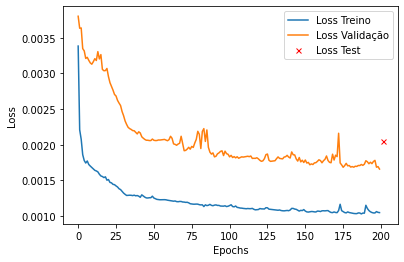

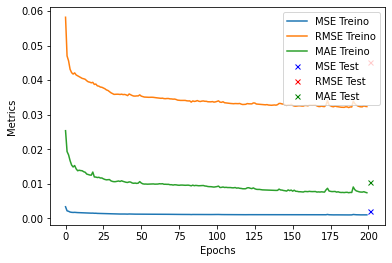

Training finished in 3029.0061390399933 seconds
All training mse losses/rmse metric all spits: 
 {'MSE train': 0.001149574527516961, 'RMSE train': 0.03390539437532425, 'MAE train': 0.007526799105107784}
======> Test on TRAINING set: [ Loss, metric(mse, rmse, mae)]=[0.001149574527516961, 0.001149574527516961, 0.03390539437532425, 0.007526799105107784]
======> Test on TEST     set: [ Loss, metric(mse, rmse, mae)]=[0.0020545164588838816, 0.0020545164588838816, 0.04532677307724953, 0.010563833639025688]
Saving model in /content/drive/My Drive/Colab Notebooks/saved_models/LSTM_360_v2_days31_Lev_unit254_steps6_stride1_bat128_356-inputs_254-layers_164-outputs_200-epochs__ALL_VARS ...
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/saved_models/LSTM_360_v2_days31_Lev_unit254_steps6_stride1_bat128_356-inputs_254-layers_164-outputs_200-epochs__ALL_VARS/assets


test_dir_name LSTM_360_R0_v2_days31_Lev_unit254_steps6_stride1_bat128_356-inputs_254-layers_164-outputs_200-epochs__ALL_VARS
drive_logs_test_var_dir /content/drive/My Drive/Colab Notebooks/logs/LSTM_360_R0_v2_days31_Lev_unit254_steps6_stride1_bat128/LSTM_360_R0_v2_days31_Lev_unit254_steps6_stride1_bat128_356-inputs_254-layers_164-outputs_200-epochs__ALL_VARS
log_dir_var /content/drive/My Drive/Colab Notebooks/logs/LSTM_360_R0_v2_days31_Lev_unit254_steps6_stride1_bat128/ALL_VARS__254-layers__200-epochs___11-17.17.00
Validating model in test set ...
Input Validation variables/size = 356/7434
Output Validation variables/size = 164/7434
59/59 [==============================] - 0s 7ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - root_mean_squared_error: 0.0409 - mean_absolute_error: 0.0090
=====> Final Test on VALIDATION set: [loss/rmse] = [0.0016703683650121093, 0.0016703683650121093, 0.04087014123797417, 0.008996059186756611]
predicting 7434 registers 
Input shape = (7434, 6, 356)
P

NameError: ignored

In [ ]:
agiliza = False
# 

for use_levs in ['Lev']: # ['NoL']
  for rain_dry in [0]: 

    # 360/28 - para LSTM
    dic_var_levels_exclude_examples, dic_var_levels_exclude_targets = get_dic_levels_excluded_dt360_lv28(use_levs)

    if not agiliza:
    
      days_test = 31  # para producao

      normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets, \
            all_min_values, all_max_values = get_data_for_test_rainy_dry(all_examples, all_targets, rain_dry=rain_dry, \
            normalize_targets=True, days_test=days_test)
      
      normalized_training_examples = get_df_col_k(normalized_training_examples, k_inicial, k_final, dic_var_levels_exclude_examples)
      normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final, dic_var_levels_exclude_targets)
      normalized_validation_examples = get_df_col_k(normalized_validation_examples, k_inicial, k_final, dic_var_levels_exclude_examples)
      normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final, dic_var_levels_exclude_targets)
 
    
      agiliza = True
      tests_results = {}


    epochs=200
    opt = 'Adam'
    splits = 1
    # agrupador de testes
    
    # Comentar para 
    tests_results = {}

    # CUIDADO *************************************** TEST exists
    tests_results = {}
    units_input = 254  # None
    for timesteps_lstm in [6]:  # 2, 3, 6, 9  # Depois testar para vários dias!1!  (240 times/day)
      for stride in [1]:
        X_train, y_train  = preprocess_lstm2d(normalized_training_examples, normalized_training_targets, timesteps_lstm, stride)
        X_test,  y_test   = preprocess_lstm2d(normalized_validation_examples, normalized_validation_targets, timesteps_lstm, stride)
        for model_v in [ 'v2']:  # 'v4', 'v5', 'v6', 'v7', 'v8'
          for batch_size in [128]:  # 32, 64, 128
            for batchnorm in [False]:
              for unit in [ units_input ]:  # [32, 64, 128]:
                for use_gpu in [False]:
                  
                  # test_par_name="{}_days{}_{}_unit{}_steps{}_stride{}_bat{}_norm{}".format(model_v, days_test, use_levs, unit, timesteps_lstm, stride, batch_size, batchnorm)
                  test_par_name="{}_days{}_{}_unit{}_steps{}_stride{}_bat{}".format(model_v, days_test, use_levs, unit, timesteps_lstm, stride, batch_size)
                  test_name = "LSTM_{}_R{}_{}".format(delta_t, rain_dry, test_par_name)
                  model_name = "LSTM_{}_{}".format(delta_t, test_par_name)

                  drive_logs_test_dir = get_drive_test_log_dir(test_name)
                  
                  # CUIDADO ***************************************
                  # test_exists = False
                  test_exists = os.path.exists(drive_logs_test_dir)

                  if test_exists:
                    log_msg(" Teste existente : {} Pulando ".format(test_name))
                    continue

                  drive_logs_test_dir = create_drive_test_log_dir(test_name)
                  log_msg(" =========== Executando teste {} ==================".format(test_name))
                  log_msg("Criando log dir: {}".format(test_name))

                  n_inputs = X_train.shape[2]
                  n_outputs = y_train.shape[1]

                  model_dir = get_mode_var_name_dir(model_name, n_inputs, unit, n_outputs, epochs, 'ALL_VARS')
                  if os.path.exists(model_dir):
                    model = load_model((model_dir + '/tmp_model.h5'))
                    model.summary(print_fn=log_msg)
                  else:
                    log_dir_var = get_tb_logdir_var(test_name, unit, epochs)
                    model = get_custom_lstm(model_v, X_train, y_train, timesteps_lstm, unit=unit, optimizer=opt, epochs=epochs,
                      batch_size=batch_size, gpu_version=use_gpu, batchnorm=batchnorm)
                    model.summary(print_fn=log_msg)
                    # Train model
                    # try:
                    with tf.device('/device:GPU:0') as gpu:
                      train_model(model, X_train, y_train, log_dir_var, epochs=epochs, mode='split',
                                      n_splits=splits, batch_size=batch_size, shuffle=False)
                    # except Exception as e:
                      # print("erro Treinando. Continuando ... " + str(e))
                      # continue
                    # try:
                    save_model_and_logs(model, test_name, model_name, n_inputs, n_outputs, unit, epochs, log_dir_var, drive_logs_test_dir)
                    # except Exception as e:
                    #   print("erro Salvando modelo. Continuando ... " + str(e))
                    #   continue

                  res = validate_model(model, normalized_validation_examples, normalized_validation_targets, batch_size, arr_input_val=X_test, arr_output_val=y_test)
                  tests_results[test_name] = res

                  dic_var_default_values = dic_var_default_values_dt360_lv28()
                  
                  calc_skill_C(normalized_validation_examples, normalized_validation_targets, all_min_values, all_max_values,
                              dic_var_default_values, normalize_targets=False, arr_input_val=X_test, arr_output_val=y_test)


                  del model
        # del X_train, y_train, X_test,  y_test 

    dic_tests_results['Architecture'] = tests_results
    plot_all_metrics(dic_tests_results)

====================================== Architecture ==========================================
Dados de treino não existentes, pulando ...


<Figure size 1080x360 with 0 Axes>

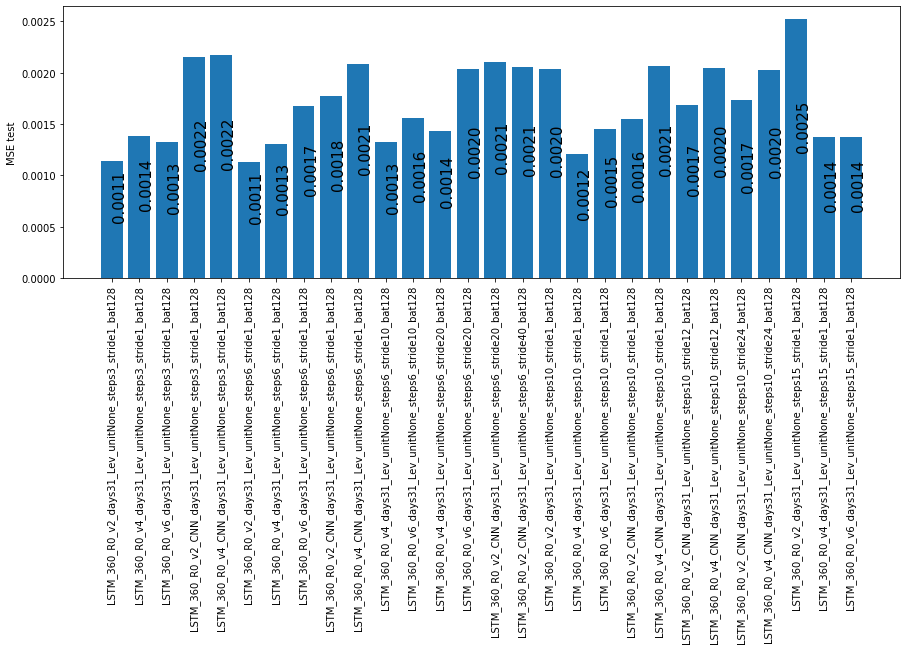

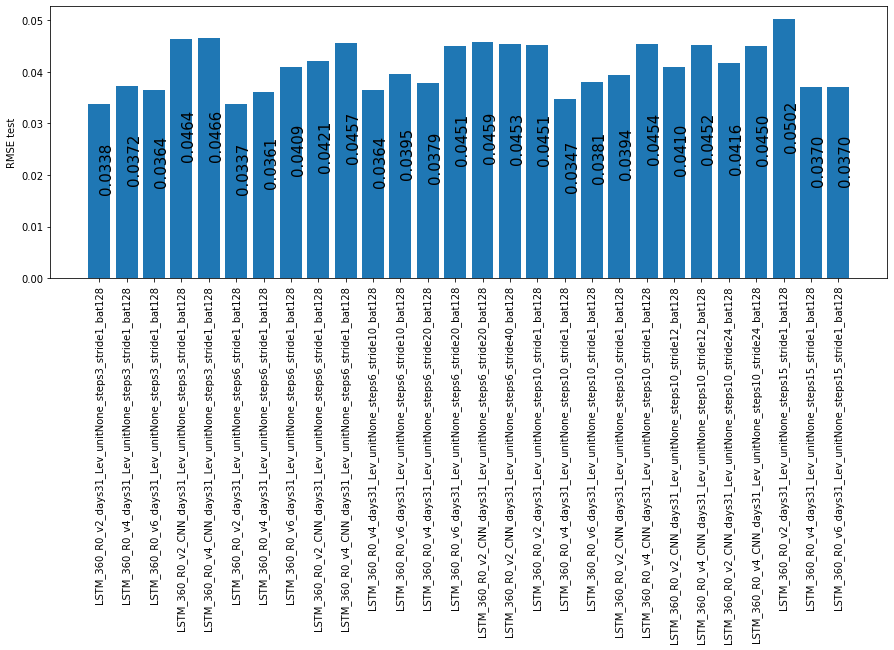

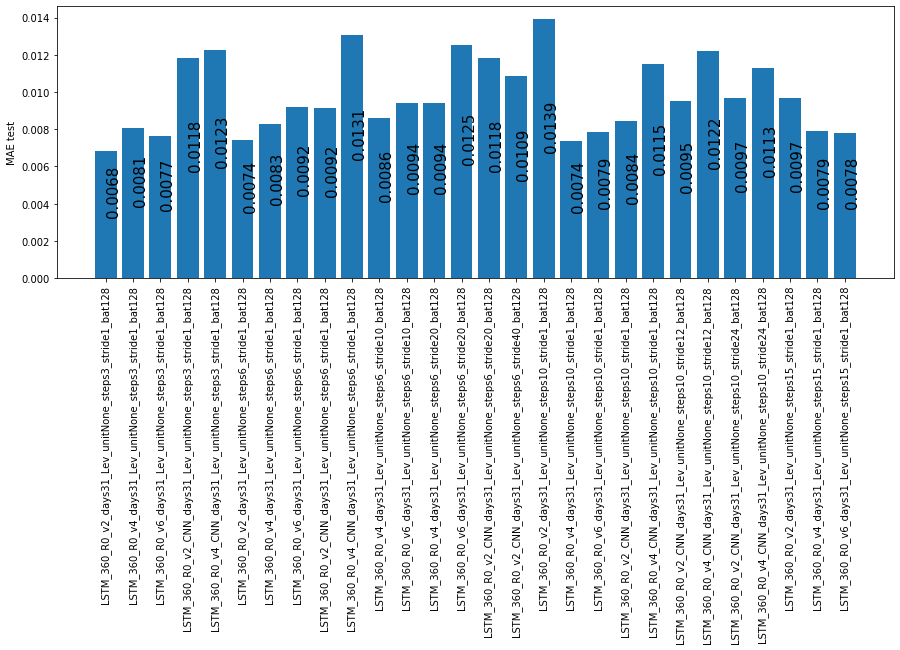

In [ ]:
  # todos
  plot_all_metrics(dic_tests_results)

In [ ]:
# v2_CNN - timestep 6, strides 1, 20, 40 (1, 12, 24 horas)

    dic_tests_results['Architecture'] = tests_results
    plot_all_metrics(dic_tests_results)

In [ ]:
# v2_CNN v4_CNN timesteps 10, stride 1, 12, 24

    dic_tests_results['Architecture'] = tests_results
    plot_all_metrics(dic_tests_results)

In [ ]:
# v4 v6 ---resultados com 0.01 na validacao !
# unit 254
# times 6
# strides 1. 10, 20
dic_tests_results['Architecture'] = tests_results
plot_all_metrics(dic_tests_results)

In [ ]:
# v4 v6 ---treinamento
# unit 254
# times 6
# strides 1. 10, 20

In [ ]:
# Resultados v4-v8

dic_tests_results['Architecture'] = tests_results
plot_all_metrics(dic_tests_results)

In [ ]:
# treinamento
# resultados até 6 timesteps v4 a v7
# resultados até 9 timesteps v4


#### Figura predição


In [ ]:
import seaborn as sns

# for setup in arr:

display.display(result_v1)

setup_sel = 'v1_tim10_unit0_batch128_optAdam'
setup = result_v1[result_v1['setup_model']==setup_sel]

# X_test,  y_test = preprocess_lstm2d(normalized_validation_examples, normalized_validation_targets, int(setup['timesteps']))
# mod = tf.keras.models.load_model(setup_sel)
# y_pred = mod.predict(X_test)

times_shown = y_test.shape[0]

col_ant="*"
rownum = 0
colcount = 0
# TODO calcular
num_feat=y_test.shape[1]
ncols = 3
nrows = math.ceil(num_feat / ncols)
fig, ax = plt.subplots(figsize=(30, 400), nrows=nrows, ncols=ncols)
for col in normalized_validation_targets.columns:
  # col, lev = col.split('_k')

  aval = pd.DataFrame()
  aval[f"{col}"] = y_pred[:times_shown, colcount]
  aval[f"{col}_Real"] = y_test[:times_shown, colcount]
  sns.lineplot(data=aval , palette="inferno", ax=ax[rownum][colcount])
  ax[rownum][colcount].set_xlabel('Timesteps')
  ax[rownum][colcount].set_title('Valor')

  colcount += 1
  if colcount == ncols:
    rownum += 1
    colcount = 0
  if rownum == 9:
    break

In [ ]:
# Test 1
display.display(result_v1)
result_v1_best_arr = []
for varname in vars_arr:  # normalized_training_examples.columns:
  best = result_v1[result_v1["varname"] == f"{varname}"].sort_values("mae", ascending=True).head(1)
  result_v1_best_arr.append(best)

result_v1_best = pd.concat(result_v1_best_arr)
display.display(result_v1_best)

varname unit optimizer    lrate    decay     loss      mae      mse     rmse
0   Tc_k1   64      Adam 0.100000 0.100000 0.000006 0.002254 0.000006 0.002496
1   qs_k9   64      Adam 0.100000 0.100000 0.000107 0.005670 0.000107 0.010334
2  ni_k13   64      Adam 0.100000 0.100000 0.000592 0.001602 0.000592 0.024333
3  ns_k16   64      Adam 0.100000 0.100000 0.000982 0.005435 0.000982 0.031332

varname unit optimizer    lrate    decay     loss      mae      mse     rmse
0   Tc_k1   64      Adam 0.100000 0.100000 0.000006 0.002254 0.000006 0.002496
1   qs_k9   64      Adam 0.100000 0.100000 0.000107 0.005670 0.000107 0.010334
2  ni_k13   64      Adam 0.100000 0.100000 0.000592 0.001602 0.000592 0.024333
3  ns_k16   64      Adam 0.100000 0.100000 0.000982 0.005435 0.000982 0.031332

### MLP
- Iniciando testes com 1% de validação da base 

1) primeiro fazer sem camadas de ativação
  - depois de encontrada melhor arquitetura, testar no BAM1D 
  - remover o delinear e testar no BAM1D novamente pra verificar se muda

2) depois com camadas de ativação
  - encontrar melhor arquitetura, testar no BAM1D (com ou sem delinear)




  all minmax values: 
{'k': [-4.4, 33.4], 'si': [-0.195597072768092, 1.199266178794682], 'Tc': [15.220173164359991, 357.53129264994], 'qv': [-0.003269345231324, 0.019636560777704], 'qc': [-0.000163184529402, 0.000979107176412], 'qr': [-0.00013115062696360003, 0.0007869037617816001], 'qi': [-2.2366721992e-05, 0.000134200331952], 'qs': [-0.00035093684764400006, 0.002105621085864], 'qg': [-4.3089182903400006e-05, 0.00025853509742040004], 'ni': [-229018.10266800004, 1374108.616008], 'ns': [-582565.157522, 3495390.945132], 'nr': [-904409.787664, 5426458.725984], 'NG': [-2248.61953514, 13491.717210840001], 'NC': [-16725000.826820001, 100350004.96092], 'tke': [-1.2000000000000002, 7.2], 'kzh': [-59.964000000000006, 359.994], 'omega': [-1.4027027492816002, 0.8775195851896], 'EFFCS': [-5.8909090909, 42.3454545454], 'EFFIS': [-10.400000000000002, 153.4], 'LSRAIN': [-5.8353242093e-05, 0.00035011945255799995], 'LSSNOW': [-7.1336178553e-11, 4.28017071318e-10]}

  all minmax values: 
{'k': [-4.4, 3

(71280, 356)

(721, 356)

(71280, 164)

(721, 164)

Epoch 1/200
502/502 [==============================] - 7s 11ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - root_mean_squared_error: 0.0692 - mean_absolute_error: 0.0320 - val_loss: 0.0034 - val_mean_squared_error: 0.0034 - val_root_mean_squared_error: 0.0580 - val_mean_absolute_error: 0.0208
Epoch 2/200
502/502 [==============================] - 5s 10ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0194 - val_loss: 0.0032 - val_mean_squared_error: 0.0032 - val_root_mean_squared_error: 0.0562 - val_mean_absolute_error: 0.0228
Epoch 3/200
502/502 [==============================] - 5s 10ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0179 - val_loss: 0.0037 - val_mean_squared_error: 0.0037 - val_root_mean_squared_error: 0.0607 - val_mean_absolute_error: 0.0299
Epoch 4/200
502/502 [==============================] - 5s 10ms/step - loss: 0.0022 - mean_squared_er

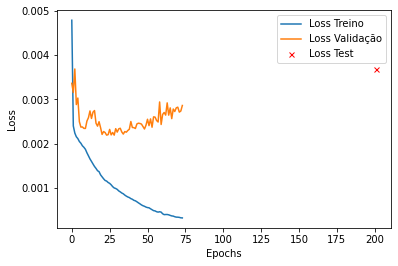

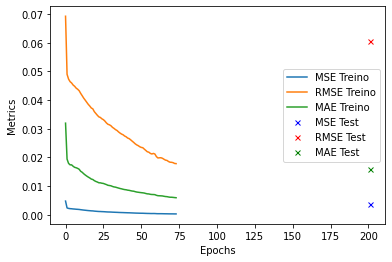

Training finished in 446.3067264556885 seconds
All training mse losses/rmse metric all spits: 
 {'MSE train': 0.0021146421786397696, 'RMSE train': 0.04598522186279297, 'MAE train': 0.013294118456542492}
======> Test on TRAINING set: [ Loss, metric(mse, rmse, mae)]=[0.0021146421786397696, 0.0021146421786397696, 0.04598522186279297, 0.013294118456542492]
======> Test on TEST     set: [ Loss, metric(mse, rmse, mae)]=[0.003687645075842738, 0.003687645075842738, 0.06072598323225975, 0.015907568857073784]
Saving model in /content/drive/My Drive/Colab Notebooks/saved_models/MLP_360__days31_Lev_[5, 254]_relu_bat128_drpNone_outsigmoid_356-inputs_[5, 254]-layers_164-outputs_200-epochs__ALL_VARS ...
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/saved_models/MLP_360__days31_Lev_[5, 254]_relu_bat128_drpNone_outsigmoid_356-inputs_[5, 254]-layers_164-outputs_200-epochs__ALL_VARS/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/saved_models/MLP_360__days31_Lev_[5, 254]_relu_bat128_drpNone_outsigmoid_356-inputs_[5, 254]-layers_164-outputs_200-epochs__ALL_VARS/assets


test_dir_name MLP_360_R0__days31_Lev_[5, 254]_relu_bat128_drpNone_outsigmoid_356-inputs_[5, 254]-layers_164-outputs_200-epochs__ALL_VARS
drive_logs_test_var_dir /content/drive/My Drive/Colab Notebooks/logs/MLP_360_R0__days31_Lev_[5, 254]_relu_bat128_drpNone_outsigmoid/MLP_360_R0__days31_Lev_[5, 254]_relu_bat128_drpNone_outsigmoid_356-inputs_[5, 254]-layers_164-outputs_200-epochs__ALL_VARS
log_dir_var /content/drive/My Drive/Colab Notebooks/logs/LSTM_360_R0_v2_days31_Lev_unit254_steps6_stride1_bat128/ALL_VARS__254-layers__200-epochs___11-17.17.00
Validating model in test set ...
Input Validation variables/size = 356/7440
Output Validation variables/size = 164/7440
59/59 [==============================] - 0s 4ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - root_mean_squared_error: 0.0496 - mean_absolute_error: 0.0145
=====> Final Test on VALIDATION set: [loss/rmse] = [0.0024597514420747757, 0.0024597514420747757, 0.04959588870406151, 0.01446318905800581]
predicting 7440 registers 


<Figure size 1080x360 with 0 Axes>

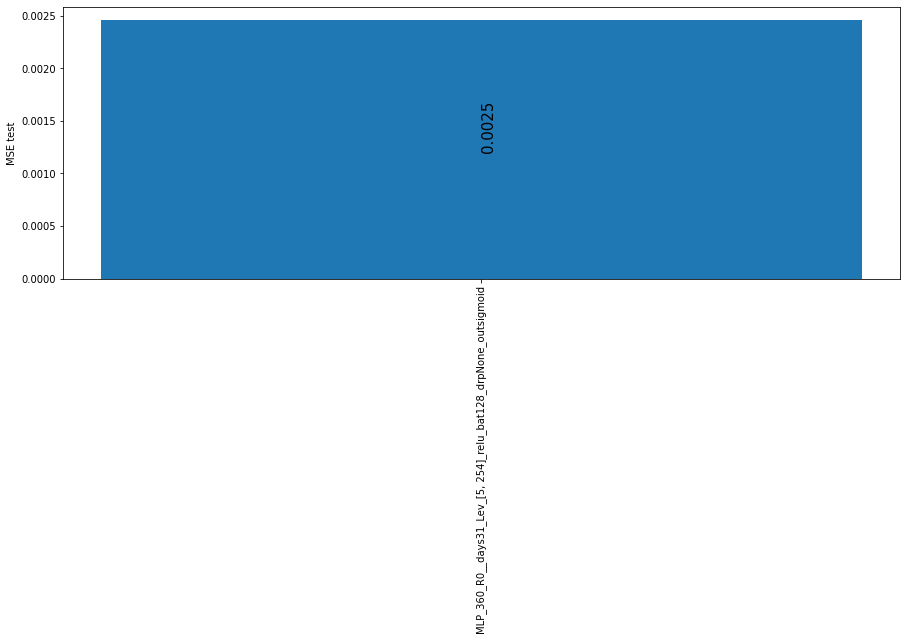

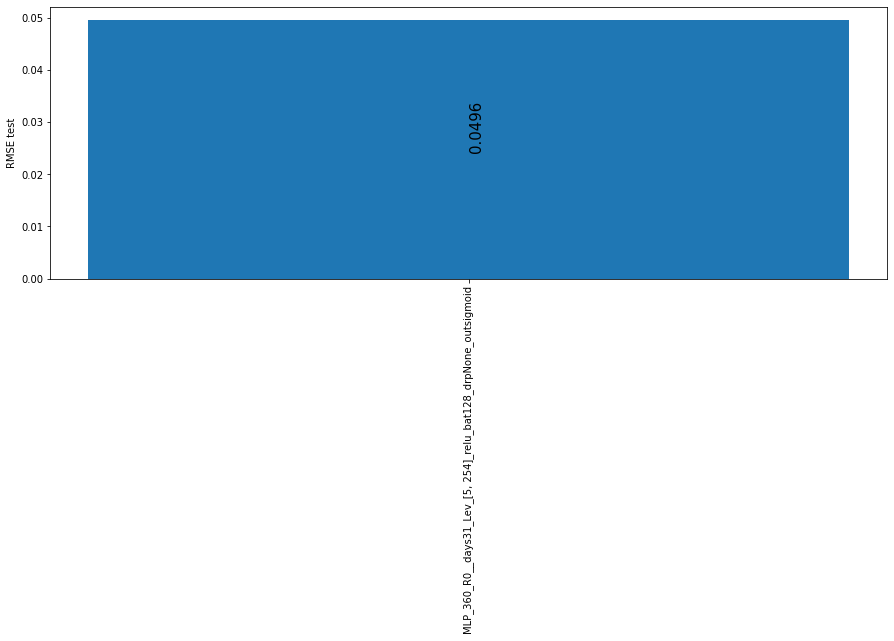

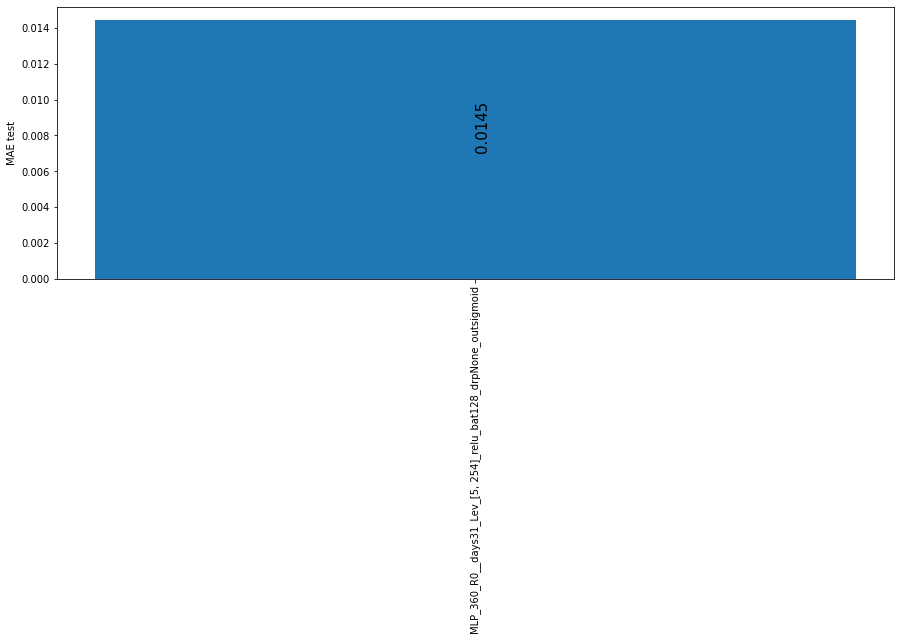

In [ ]:
# TODO - testar kernel_initializers, kernel_normalizers
agiliza = False

tests_results = {}
dic_tests_results = {}

for use_levs in ['Lev']:
  for rain_dry in [0]:
    # for use_levs in ['NoL']:
    dic_var_levels_exclude_examples, dic_var_levels_exclude_targets = get_dic_levels_excluded_dt360_lv28(use_levs)

    # agiliza bugado
    if not agiliza:
    
      days_test = 31  # para producao


      normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets,\
      all_min_values, all_max_values = get_data_for_test_rainy_dry(all_examples, all_targets, rain_dry=rain_dry, normalize_targets=True, days_test=days_test)
      
      normalized_training_examples = get_df_col_k(normalized_training_examples, k_inicial, k_final, dic_var_levels_exclude_examples)
      normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final, dic_var_levels_exclude_targets)
      normalized_validation_examples = get_df_col_k(normalized_validation_examples, k_inicial, k_final, dic_var_levels_exclude_examples)
      normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final, dic_var_levels_exclude_targets)

      arr_input_train = normalized_training_examples.to_numpy()
      arr_output_train = normalized_training_targets.to_numpy()

      # del normalized_training_examples, normalized_training_targets

      n_inputs = arr_input_train.shape[1]
      n_outputs = arr_output_train.shape[1]

      agiliza = True


    # Train model parameters
    #
    loss_type = 'mse'
    epochs=200
    splits=1
    drop_first=False
    batch_size=128
    dropout=None
    
    # batch_norm='no_activation'
    batch_norm=True

    # arr_layers = [ [648, 648, 648, 648, 648],  [432, 432, 432, 432], [432, 432, 432, 432, 432] ]
    # arr_layarr_layers  = [ [648, 648, 648, 648, 648] ]
    
    arr_layers = [ 
                     [5, 254]
                 ]

    # dic de testes
    for hidden_layers in arr_layers:
      for activation in ['relu']:  # sigmoid, softmax, relu (melhor), selu    
        # for dropout in [ None, 0.1, 0.5, 0.3]:
        for out_activation in [ 'sigmoid' ]:  #, 'tanh']:
          if activation == 'tanh':
            kernel_initializer = 'zeros'
          else:
            kernel_initializer = "glorot_uniform"
          test_par_name="_days{}_{}_{}_{}_bat{}_drp{}_out{}".format(days_test, use_levs, hidden_layers, activation, batch_size, dropout, out_activation)
          test_name = "MLP_360_R{}_{}".format(rain_dry, test_par_name)
          model_name = "MLP_360_{}".format(test_par_name)
          tiny_name = "R{}_{}_{}".format(rain_dry, hidden_layers, out_activation)

          drive_logs_test_dir = get_drive_test_log_dir(test_name)
          test_exists = os.path.exists(drive_logs_test_dir)
          if test_exists: 
            log_msg(" Teste existente, pulando: {}".format(test_name))
            continue

          drive_logs_test_dir = create_drive_test_log_dir(test_name)

          log_msg(" =========== Executando teste {} ==================".format(test_name))

          model_dir = get_mode_var_name_dir(model_name, n_inputs, hidden_layers, n_outputs, epochs, 'ALL_VARS')
          if os.path.exists(model_dir):
              model = load_model((model_dir + '/tmp_model.h5'))
              model.summary(print_fn=log_msg)
          else:
            # Train model
            model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type, dropout=dropout,drop_only_first=drop_first,
                    batch_norm=batch_norm, activation=activation, kernel_initializer=kernel_initializer, out_activation=out_activation) 
            model.summary(print_fn=log_msg)
            # try:
            with tf.device('/device:GPU:0') as gpu:
              train_model(model,  arr_input_train, arr_output_train, log_dir_var, epochs=epochs, mode='split',
                              n_splits=splits, batch_size=batch_size, shuffle=False)
            # except Exception as e:
              # print("erro Treinando. Continuando ... " + str(e))
              # continue
            # try:
            save_model_and_logs(model, test_name, model_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir)
            # except Exception as e:
            #   print("erro Salvando modelo. Continuando ... " + str(e))
            #   continue

        res = validate_model(model, normalized_validation_examples, normalized_validation_targets, batch_size)
        tests_results[test_name] = res

        dic_var_default_values = dic_var_default_values_dt360_lv28()
        
        calc_skill_C(normalized_validation_examples, normalized_validation_targets, all_min_values, all_max_values, 
                     dic_var_default_values, normalize_targets=False)

          # model_dir = get_mode_var_name_dir(model_name, n_inputs, hidden_layers, n_outputs, epochs, 'ALL_VARS')

          # # Train model
          # log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs)
          
          # try:
          #   with tf.device('/device:GPU:0') as gpu:
          #     res = train_model(model, arr_input_train, arr_output_train, log_dir_var, epochs=epochs, n_splits=splits, batch_size=batch_size, shuffle=True)
          #     tests_results[tiny_name] = res
          # except Exception as e:
          #   print("erro Treinando. Continuando ... " + str(e))
          #   continue
          # try:
          #   save_model_and_logs(model, test_name, model_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir)
          # except Exception as e:
          #   print("erro Salvando modelo. Continuando ... " + str(e))
          #   continue

          # validate_model(model, normalized_validation_examples, normalized_validation_targets)
          # dic_var_default_values = { \
          #   'qc': 0.0,
          #   'qr': 0.0,
          #   'qi': 0.0,
          #   'qs': 0.0,
          #   'ni': 0.0,
          #   'ns': 0.0,
          #   'nr': 0.0,
          #   'NG': 0.0,
          #   'NC': 0.0,
          #   # 'EFFCS': 25.0,
          #   # 'EFFIS': 25.0	
          #   'EFFCS': 0.573833,
          #   'EFFIS': 0.119181	            
          # }
          
          # calc_skill_C(normalized_validation_examples, normalized_validation_targets, all_min_values, all_max_values, dic_var_default_values, normalize_targets=False)


    dic_tests_results['Architecture'] = tests_results
    plot_all_metrics(dic_tests_results)


  all minmax values: 
{'k': [-4.4, 33.4], 'si': [-0.195597072768092, 1.199266178794682], 'Tc': [15.220173164359991, 357.53129264994], 'qv': [-0.003269345231324, 0.019636560777704], 'qc': [-0.000163184529402, 0.000979107176412], 'qr': [-0.00013115062696360003, 0.0007869037617816001], 'qi': [-2.2366721992e-05, 0.000134200331952], 'qs': [-0.00035093684764400006, 0.002105621085864], 'qg': [-4.3089182903400006e-05, 0.00025853509742040004], 'ni': [-229018.10266800004, 1374108.616008], 'ns': [-582565.157522, 3495390.945132], 'nr': [-904409.787664, 5426458.725984], 'NG': [-2248.61953514, 13491.717210840001], 'NC': [-16725000.826820001, 100350004.96092], 'tke': [-1.2000000000000002, 7.2], 'kzh': [-59.964000000000006, 359.994], 'omega': [-1.4027027492816002, 0.8775195851896], 'EFFCS': [-5.8909090909, 42.3454545454], 'EFFIS': [-10.400000000000002, 153.4], 'LSRAIN': [-5.8353242093e-05, 0.00035011945255799995], 'LSSNOW': [-7.1336178553e-11, 4.28017071318e-10]}

  all minmax values: 
{'k': [-4.4, 3

<Figure size 1080x360 with 0 Axes>

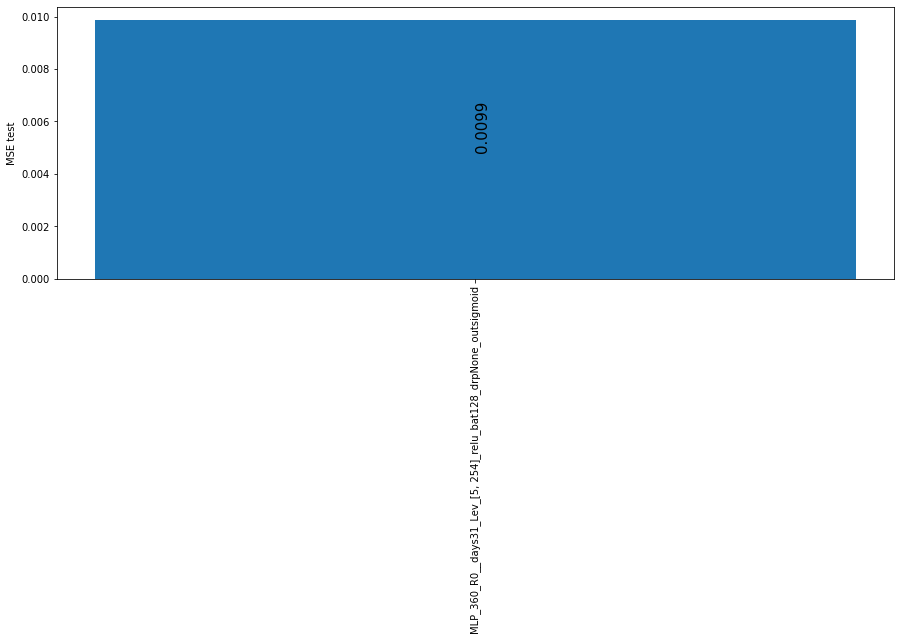

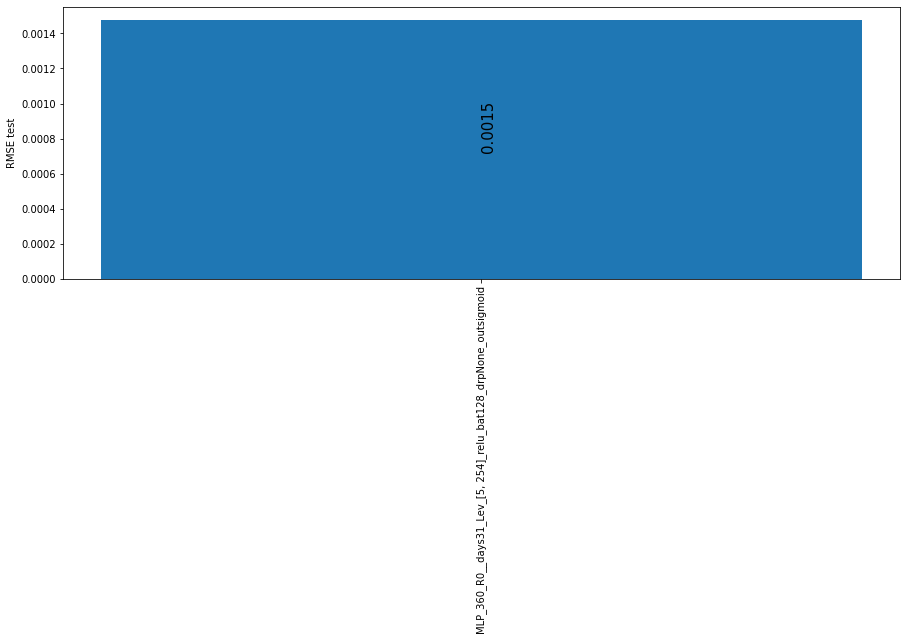

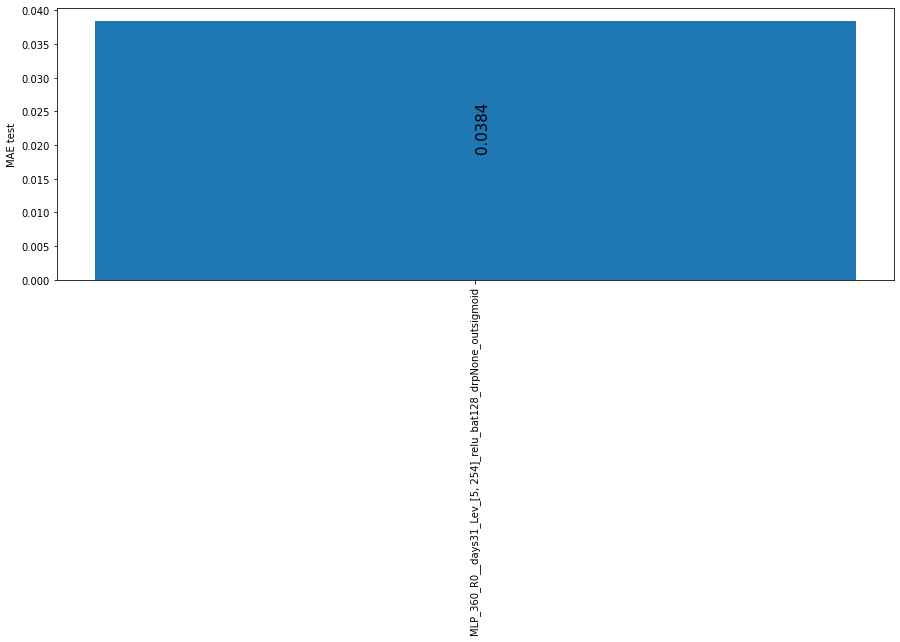

 =========== Executando teste MLP_360_R1__days31_Lev_[5, 254]_relu_bat128_drpNone_outsigmoid ==================
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 382)]             0         
_________________________________________________________________
dense_33 (Dense)             (None, 254)               97282     
_________________________________________________________________
batch_normalization_29 (Batc (None, 254)               1016      
_________________________________________________________________
activation_25 (Activation)   (None, 254)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 254)               64770     
_________________________________________________________________
batch_normalization_30 (Batc (None, 254)               1016      
_____________

(71280, 382)

(721, 382)

(71280, 254)

(721, 254)

Epoch 1/200
502/502 [==============================] - 5s 8ms/step - loss: 0.0040 - mean_absolute_error: 0.0289 - mean_squared_error: 0.0040 - root_mean_squared_error: 0.0633 - val_loss: 0.0027 - val_mean_absolute_error: 0.0229 - val_mean_squared_error: 0.0027 - val_root_mean_squared_error: 0.0520
Epoch 2/200
502/502 [==============================] - 4s 7ms/step - loss: 0.0017 - mean_absolute_error: 0.0163 - mean_squared_error: 0.0017 - root_mean_squared_error: 0.0413 - val_loss: 0.0023 - val_mean_absolute_error: 0.0178 - val_mean_squared_error: 0.0023 - val_root_mean_squared_error: 0.0476
Epoch 3/200
502/502 [==============================] - 4s 7ms/step - loss: 0.0016 - mean_absolute_error: 0.0146 - mean_squared_error: 0.0016 - root_mean_squared_error: 0.0396 - val_loss: 0.0021 - val_mean_absolute_error: 0.0173 - val_mean_squared_error: 0.0021 - val_root_mean_squared_error: 0.0460
Epoch 4/200
502/502 [==============================] - 4s 7ms/step - loss: 0.0015 - mean_absolute_error

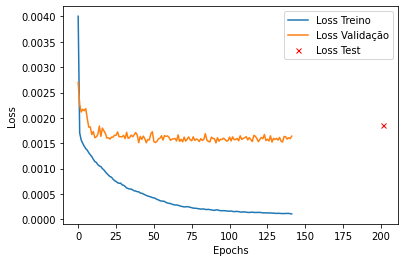

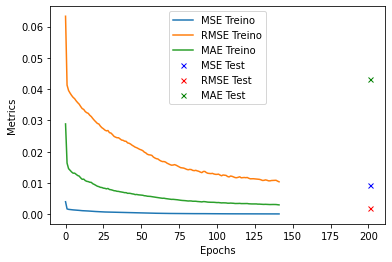

Training finished in 523.7785923480988 seconds
All training mse losses/rmse metric all spits: 
 {'MSE train': 0.00768280727788806, 'RMSE train': 0.0013441446935757995, 'MAE train': 0.03666257858276367}
======> Test on TRAINING set: [ Loss, metric(mse, rmse, mae)]=[0.0013441446935757995, 0.00768280727788806, 0.0013441446935757995, 0.03666257858276367]
======> Test on TEST     set: [ Loss, metric(mse, rmse, mae)]=[0.0018678857013583183, 0.00942966341972351, 0.0018678857013583183, 0.04321904107928276]
Saving model in /content/drive/My Drive/Colab Notebooks/saved_models/MLP_360__days31_Lev_[5, 254]_relu_bat128_drpNone_outsigmoid_382-inputs_[5, 254]-layers_254-outputs_200-epochs__ALL_VARS ...
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/saved_models/MLP_360__days31_Lev_[5, 254]_relu_bat128_drpNone_outsigmoid_382-inputs_[5, 254]-layers_254-outputs_200-epochs__ALL_VARS/assets
test_dir_name MLP_360_R1__days31_Lev_[5, 254]_relu_bat128_drpNone_outsigmoid_382-inputs_

<Figure size 1080x360 with 0 Axes>

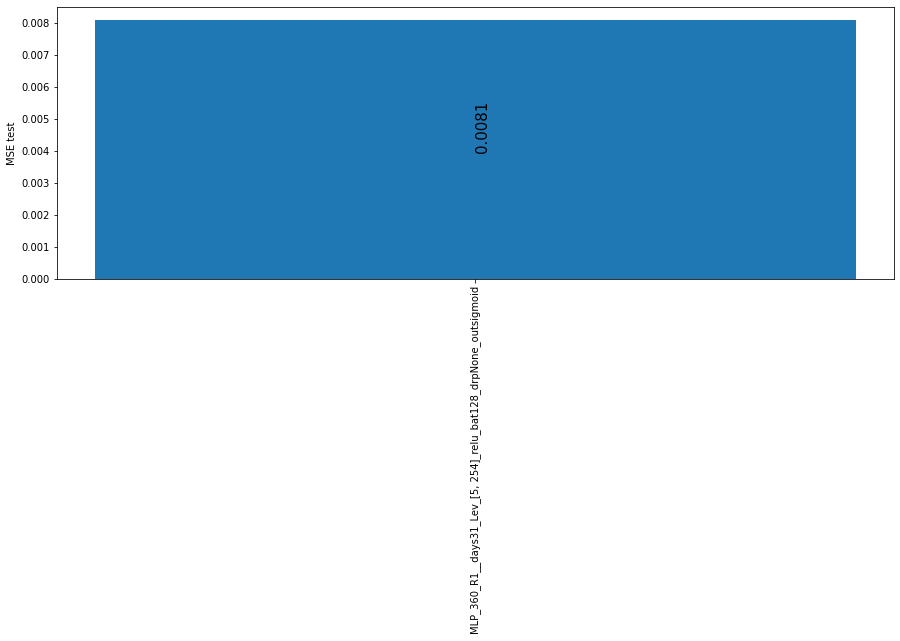

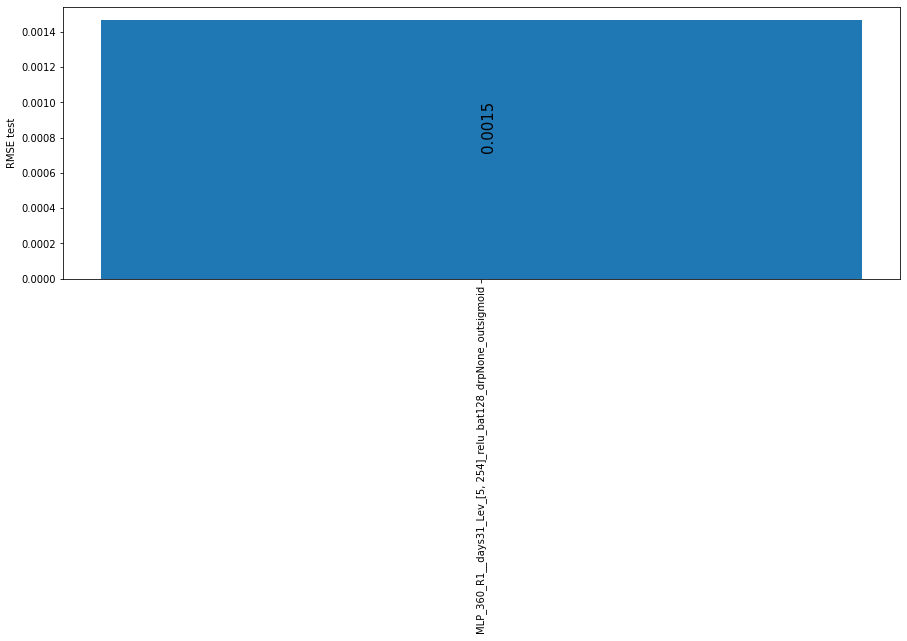

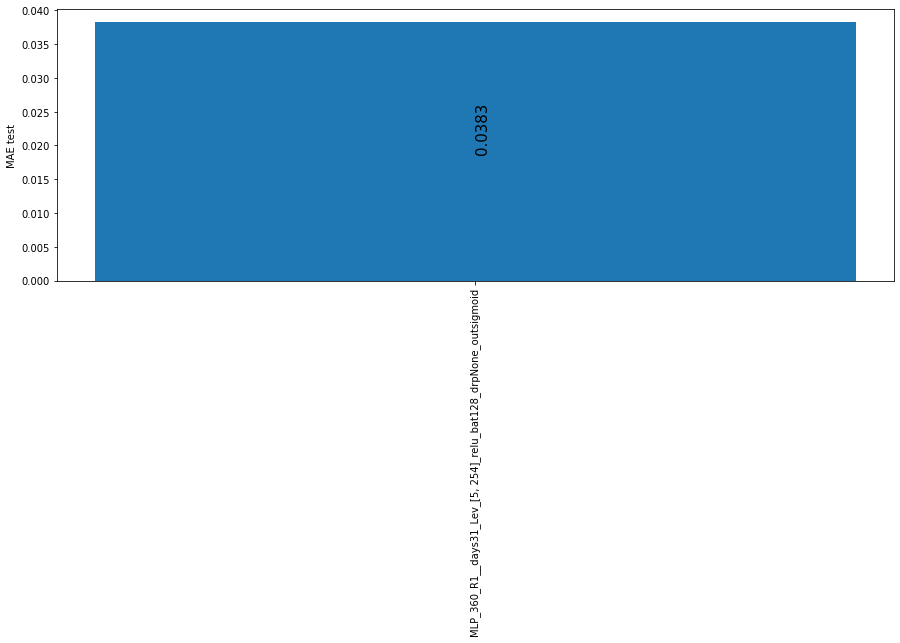

In [ ]:
# MLP


====================================== Architecture ==========================================


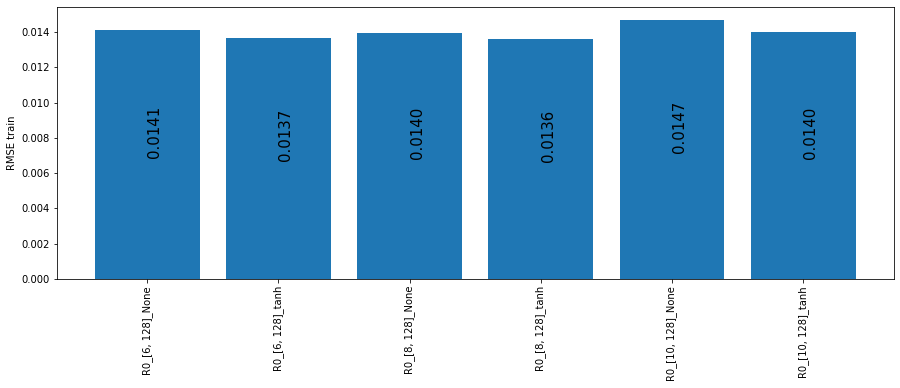

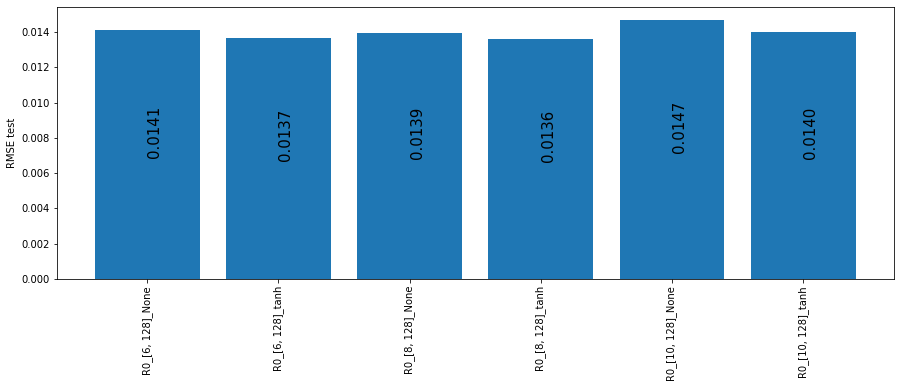

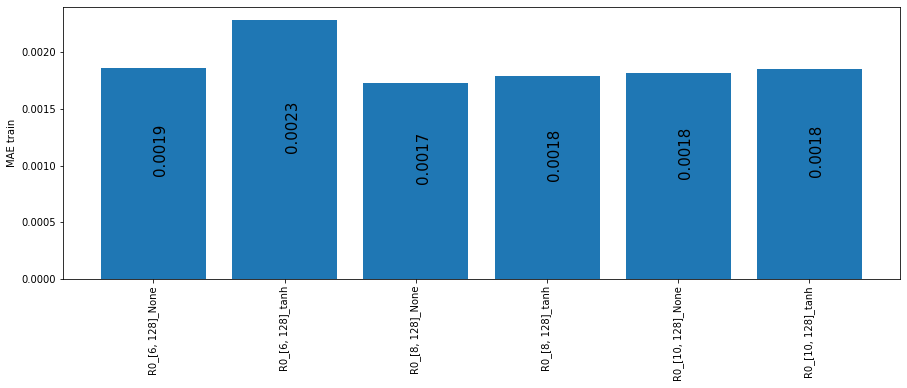

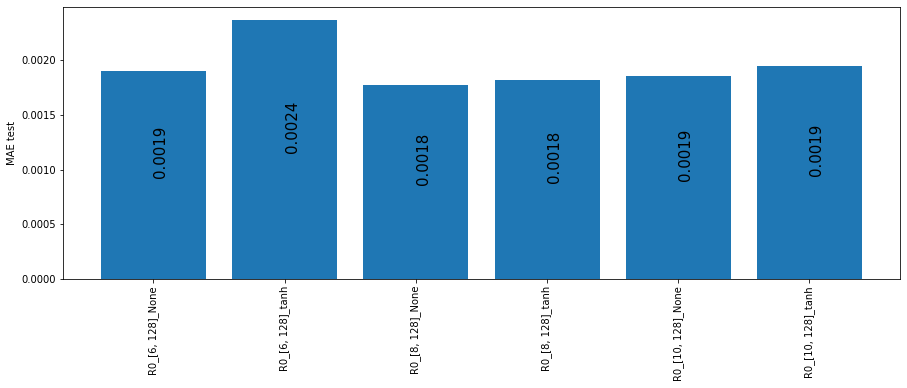

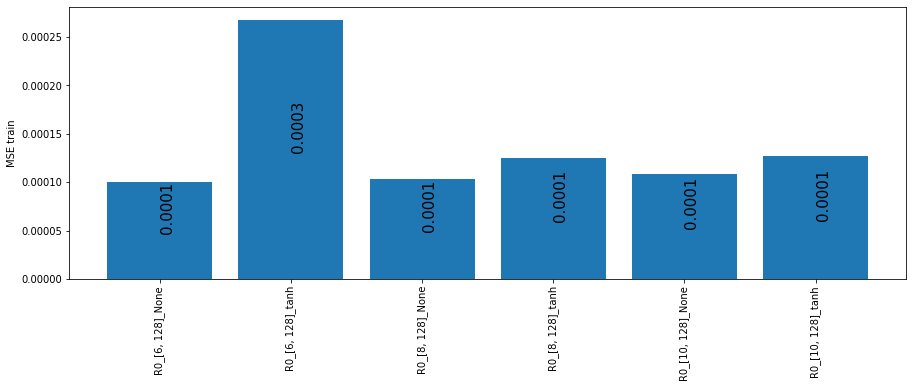

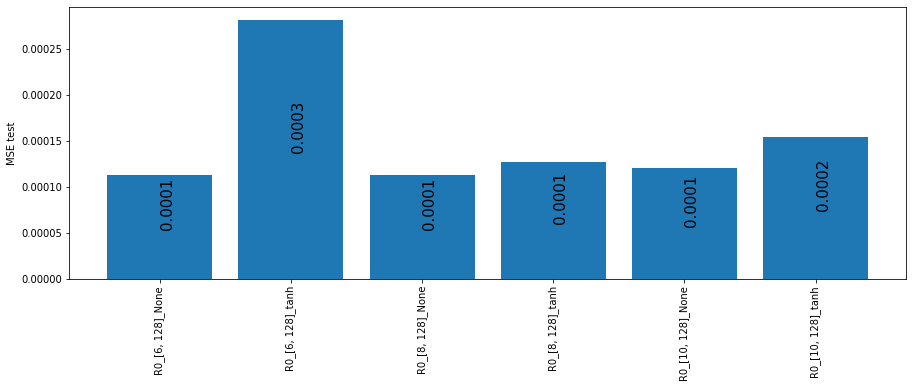

In [ ]:
  # BAK testes com tanh na saída - 3days
  plot_all_metrics(dic_tests_results)

### MLP timesteps
- Utilizando 1 mês wet (março) e um mês dry (setembro) para testes
- 200 passos
- 5 split com shuffle = True
- Variando Window, Neurônios, camadas, dropout, batchnorm, batch



  all minmax values: 
{'k': [-4.4, 33.4], 'si': [-0.195597072768092, 1.199266178794682], 'Tc': [15.220173164359991, 357.53129264994], 'qv': [-0.003269345231324, 0.019636560777704], 'qc': [-0.000163184529402, 0.000979107176412], 'qr': [-0.00013115062696360003, 0.0007869037617816001], 'qi': [-2.2366721992e-05, 0.000134200331952], 'qs': [-0.00035093684764400006, 0.002105621085864], 'qg': [-4.3089182903400006e-05, 0.00025853509742040004], 'ni': [-229018.10266800004, 1374108.616008], 'ns': [-582565.157522, 3495390.945132], 'nr': [-904409.787664, 5426458.725984], 'NG': [-2248.61953514, 13491.717210840001], 'NC': [-16725000.826820001, 100350004.96092], 'tke': [-1.2000000000000002, 7.2], 'kzh': [-59.964000000000006, 359.994], 'omega': [-1.4027027492816002, 0.8775195851896], 'EFFCS': [-5.8909090909, 42.3454545454], 'EFFIS': [-10.400000000000002, 153.4], 'LSRAIN': [-5.8353242093e-05, 0.00035011945255799995], 'LSSNOW': [-7.1336178553e-11, 4.28017071318e-10]}

  all minmax values: 
{'k': [-4.4, 3

(71279, 3, 356)

(720, 3, 356)

(71279, 164)

(720, 164)

Epoch 1/200
502/502 [==============================] - 10s 16ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - root_mean_squared_error: 0.0673 - mean_absolute_error: 0.0343 - val_loss: 0.0050 - val_mean_squared_error: 0.0050 - val_root_mean_squared_error: 0.0709 - val_mean_absolute_error: 0.0386
Epoch 2/200
502/502 [==============================] - 7s 15ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - root_mean_squared_error: 0.0541 - mean_absolute_error: 0.0239 - val_loss: 0.0048 - val_mean_squared_error: 0.0048 - val_root_mean_squared_error: 0.0695 - val_mean_absolute_error: 0.0344
Epoch 3/200
502/502 [==============================] - 7s 15ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - root_mean_squared_error: 0.0498 - mean_absolute_error: 0.0198 - val_loss: 0.0039 - val_mean_squared_error: 0.0039 - val_root_mean_squared_error: 0.0622 - val_mean_absolute_error: 0.0275
Epoch 4/200
502/502 [==============================] - 7s 15ms/step - loss: 0.0023 - mean_squared_e

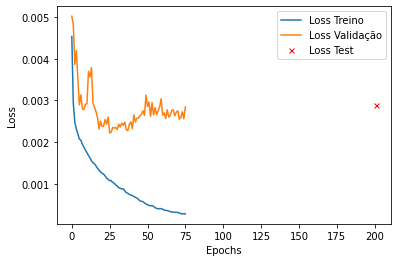

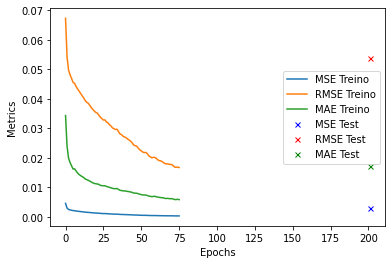

Training finished in 628.4330832958221 seconds
All training mse losses/rmse metric all spits: 
 {'MSE train': 0.0019505482632666826, 'RMSE train': 0.0441649928689003, 'MAE train': 0.013106194324791431}
======> Test on TRAINING set: [ Loss, metric(mse, rmse, mae)]=[0.0019505482632666826, 0.0019505482632666826, 0.0441649928689003, 0.013106194324791431]
======> Test on TEST     set: [ Loss, metric(mse, rmse, mae)]=[0.002883034059777856, 0.002883034059777856, 0.05369388684630394, 0.017174437642097473]
Saving model in /content/drive/My Drive/Colab Notebooks/saved_models/MLP_T_360__days31_Lev_[5, 254]_relu_bat128_drpNone_outsigmoid_wind3_356-inputs_[5, 254]-layers_164-outputs_200-epochs__ALL_VARS ...
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/saved_models/MLP_T_360__days31_Lev_[5, 254]_relu_bat128_drpNone_outsigmoid_wind3_356-inputs_[5, 254]-layers_164-outputs_200-epochs__ALL_VARS/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/saved_models/MLP_T_360__days31_Lev_[5, 254]_relu_bat128_drpNone_outsigmoid_wind3_356-inputs_[5, 254]-layers_164-outputs_200-epochs__ALL_VARS/assets


test_dir_name MLP_T_360_R0__days31_Lev_[5, 254]_relu_bat128_drpNone_outsigmoid_wind3_356-inputs_[5, 254]-layers_164-outputs_200-epochs__ALL_VARS
drive_logs_test_var_dir /content/drive/My Drive/Colab Notebooks/logs/MLP_T_360_R0__days31_Lev_[5, 254]_relu_bat128_drpNone_outsigmoid_wind3/MLP_T_360_R0__days31_Lev_[5, 254]_relu_bat128_drpNone_outsigmoid_wind3_356-inputs_[5, 254]-layers_164-outputs_200-epochs__ALL_VARS
log_dir_var /content/drive/My Drive/Colab Notebooks/logs/LSTM_360_R0_v2_days31_Lev_unit254_steps6_stride1_bat128/ALL_VARS__254-layers__200-epochs___11-17.17.00
Validating model in test set ...
117/117 [==============================] - 1s 8ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0143
=====> Final Test on VALIDATION set: [loss/rmse] = [0.002380428137257695, 0.002380428137257695, 0.048789624124765396, 0.014300249516963959]
predicting 7438 registers 
Input shape = (7438, 3, 356)
Prediction time MULTIPROCESSING 

<Figure size 1080x360 with 0 Axes>

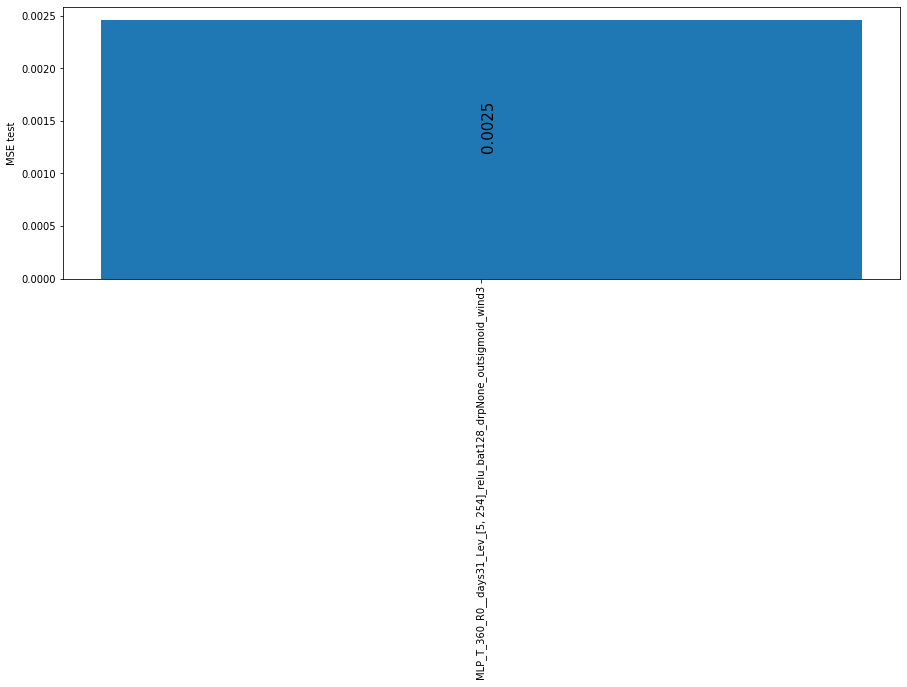

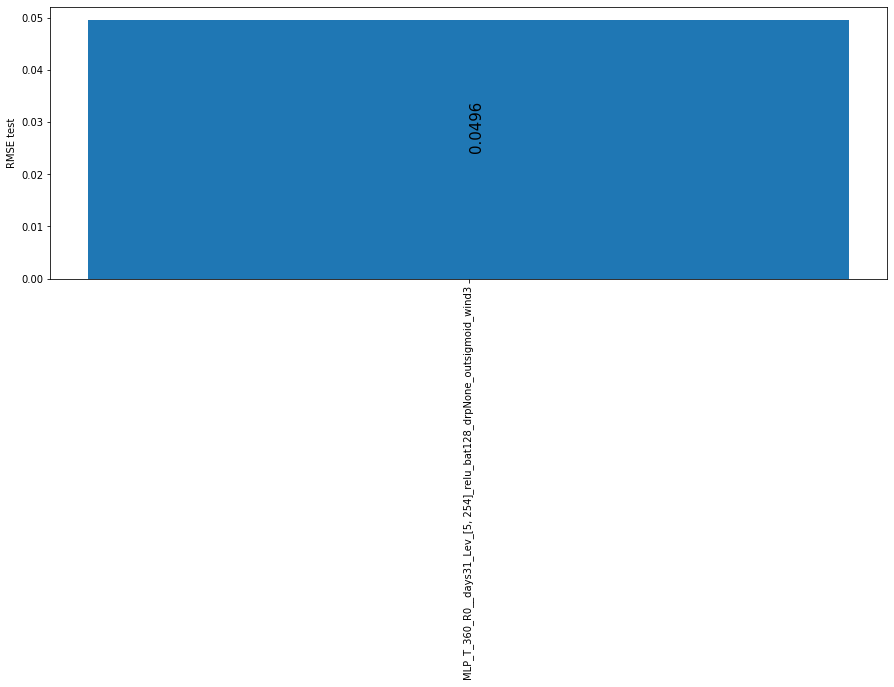

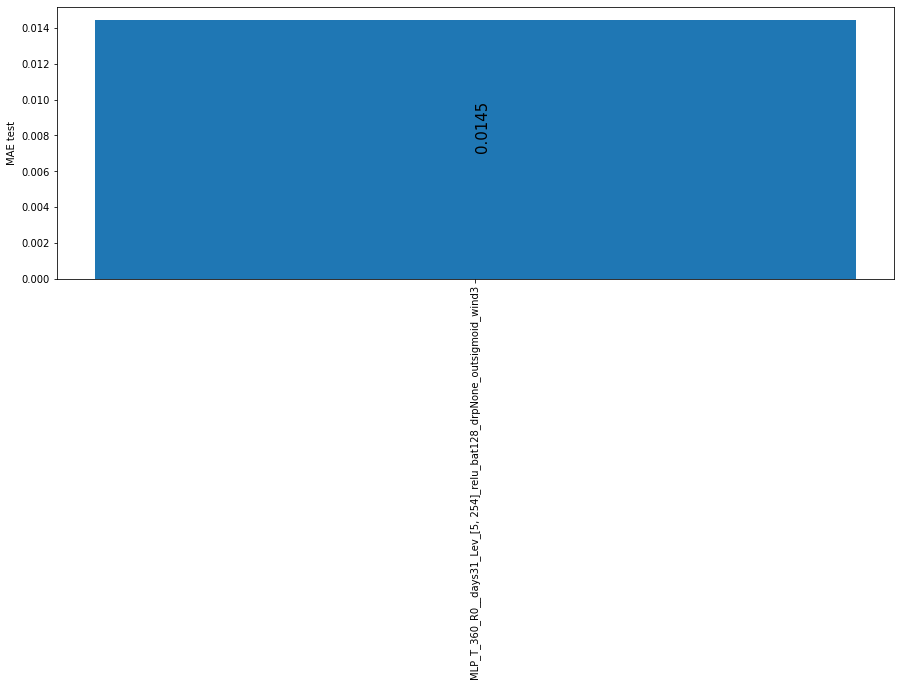

In [ ]:
# MLP-T 360 
agiliza = False

tests_results = {}
dic_tests_results = {}

for use_levs in ['Lev']:
  for rain_dry in [0]:
    # for use_levs in ['NoL']:
    
    dic_var_levels_exclude_examples, dic_var_levels_exclude_targets = get_dic_levels_excluded_dt360_lv28(use_levs)

    if not agiliza:
    
      days_test = 31  # para producao

      normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets,\
      all_min_values, all_max_values = get_data_for_test_rainy_dry(all_examples, all_targets, rain_dry=rain_dry, normalize_targets=True, days_test=days_test)
      
      normalized_training_examples = get_df_col_k(normalized_training_examples, k_inicial, k_final, dic_var_levels_exclude_examples)
      normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final, dic_var_levels_exclude_targets)
      normalized_validation_examples = get_df_col_k(normalized_validation_examples, k_inicial, k_final, dic_var_levels_exclude_examples)
      normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final, dic_var_levels_exclude_targets)

      arr_input_train_1 = normalized_training_examples.to_numpy()
      arr_output_train_1 = normalized_training_targets.to_numpy()
      arr_input_val_1 = normalized_validation_examples.to_numpy()
      arr_output_val_1 = normalized_validation_targets.to_numpy()

      # del normalized_training_examples, normalized_training_targets
      agiliza = True


    # Train model parameters
    #
    loss_type = 'mse'
    epochs=200
    splits=1
    drop_first=False
    batch_size=128
    dropout=None
    
    # batch_norm='no_activation'
    batch_norm=True

    # arr_layers = [ [648, 648, 648, 648, 648],  [432, 432, 432, 432], [432, 432, 432, 432, 432] ]
    # arr_layarr_layers  = [ [648, 648, 648, 648, 648] ]
    
    arr_layers = [ 
                     [5, 254]
                 ]
    timesteps_window_arr = [3]

    # dic de testes
    for hidden_layers in arr_layers:
      for activation in ['relu']:  # sigmoid, softmax, relu (melhor), selu    
        # for dropout in [ None, 0.1, 0.5, 0.3]:
        for timesteps_window in timesteps_window_arr:
          for out_activation in [ 'sigmoid' ]:  #, 'tanh']:
            if activation == 'tanh':
              kernel_initializer = 'zeros'
            else:
              kernel_initializer = "glorot_uniform"
            test_par_name="_days{}_{}_{}_{}_bat{}_drp{}_out{}_wind{}".format(days_test, use_levs, hidden_layers, activation, batch_size, dropout, out_activation, timesteps_window)
            test_name = "MLP_T_360_R{}_{}".format(rain_dry, test_par_name)
            model_name = "MLP_T_360_{}".format(test_par_name)
            tiny_name = "R{}_{}_{}".format(rain_dry, hidden_layers, out_activation)

            drive_logs_test_dir = get_drive_test_log_dir(test_name)

            if os.path.exists(drive_logs_test_dir): 
              log_msg(" Teste existente, pulando: {}".format(test_name))
              continue

            drive_logs_test_dir = create_drive_test_log_dir(test_name)

            log_msg(" =========== Executando teste {} ==================".format(test_name))

            try:
              print("getting window train")
              arr_input_train = get_arr_input_windowed(arr_input_train_1, timesteps_window)
              print("getting window val")
              arr_input_val = get_arr_input_windowed(arr_input_val_1, timesteps_window)

              # # TRAIN
              new_samples=int(arr_input_train.shape[0]/timesteps_window)
              arr_input_train = arr_input_train[0:new_samples*timesteps_window,:]
              arr_input_train = arr_input_train.reshape(new_samples, timesteps_window, arr_input_train.shape[1])
              arr_output_train = arr_output_train_1[timesteps_window-1:,:]  # inicia pelo ultimo usado na janela do treino

              # # VALIDATION
              new_samples = int(arr_input_val.shape[0]/timesteps_window)
              arr_input_val = arr_input_val[0:new_samples*timesteps_window,:]
              arr_input_val = arr_input_val.reshape(new_samples, timesteps_window, arr_input_val.shape[1])
              arr_output_val = arr_output_val_1[timesteps_window-1:,:]  # inicia pelo ultimo usado na janela do treino

              n_inputs = arr_input_train.shape[2]  # 448
              n_outputs = arr_output_train.shape[1]  # 394
            except Exception as e:
              print("erro obtendo janela. Continuando ... " + str(e))
              continue

            model_dir = get_mode_var_name_dir(model_name, n_inputs, hidden_layers, n_outputs, epochs, 'ALL_VARS')
            if os.path.exists(model_dir):
                model = load_model((model_dir + '/tmp_model.h5'))
                model.summary(print_fn=log_msg)
            else:
              # Train model
              model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type, dropout=dropout,drop_only_first=drop_first,
                      batch_norm=batch_norm, activation=activation, kernel_initializer=kernel_initializer, out_activation=out_activation, timesteps_window=timesteps_window) 
              
              model.summary(print_fn=log_msg)
              # try:
              with tf.device('/device:GPU:0') as gpu:
                train_model(model,  arr_input_train, arr_output_train, log_dir_var, epochs=epochs, mode='split',
                                n_splits=splits, batch_size=batch_size, shuffle=False)
              # except Exception as e:
                # print("erro Treinando. Continuando ... " + str(e))
                # continue
              # try:
              save_model_and_logs(model, test_name, model_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir)
              # except Exception as e:
              #   print("erro Salvando modelo. Continuando ... " + str(e))
              #   continue

            # res = validate_model(model, normalized_validation_examples, normalized_validation_targets, batch_size)
            validate_model_cnn_timesteps(model, arr_input_val, arr_output_val)

            tests_results[test_name] = res

            dic_var_default_values = dic_var_default_values_dt360_lv28()
            
            calc_skill_C(normalized_validation_examples, normalized_validation_targets, all_min_values, all_max_values, 
                        dic_var_default_values, arr_input_val_timesteps=arr_input_val, arr_output_val_timesteps=arr_output_val, normalize_targets=False)


    dic_tests_results['Architecture'] = tests_results
    plot_all_metrics(dic_tests_results)

In [ ]:
# MLPT old
for use_levs in ['Lev']:
  for rain_dry in [0, 1]:
    
    if use_levs == 'Lev':
      dic_var_levels_exclude_examples = { \
        # 'sl': range(1,29),                          
        'ni': list(range(1,11)) + list(range(20,29)),
        'ns': list(range(1,5)) + list(range(22,29)),
        'nr': range(14,29),
        'ng': range(22,29),
        'NC': list(range(1,7)) + list(range(14,29))
      }
      dic_var_levels_exclude_targets = { \
        'qc': list(range(1,7)) + list(range(14,29)),
        'qr': range(14,29),
        'qi': list(range(1,11)) + list(range(20,29)),
        'qs': list(range(1,5)) + list(range(22,29)),
        'qg': [1] + list(range(22,29)),
        'ni': list(range(1,11)) + list(range(20,29)),
        'ns': list(range(1,5)) + list(range(22,29)),
        'nr': range(14,29),
        'ng': [1] + list(range(22,29)),
        'NC': list(range(1,7)) + list(range(14,29))
      }
    else:
      dic_var_levels_exclude_examples, dic_var_levels_exclude_targets = None, None

    normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets, all_min_values, all_max_values = get_data_for_test_rainy_dry(all_examples, all_targets, rain_dry=rain_dry)

    normalized_training_examples = get_df_col_k(normalized_training_examples, k_inicial, k_final, dic_var_levels_exclude_examples)
    normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final, dic_var_levels_exclude_targets)
    normalized_validation_examples = get_df_col_k(normalized_validation_examples, k_inicial, k_final, dic_var_levels_exclude_examples)
    normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final, dic_var_levels_exclude_targets)

    arr_input_train_1 = normalized_training_examples.to_numpy()
    arr_output_train_1 = normalized_training_targets.to_numpy()
    arr_input_val_1 = normalized_validation_examples.to_numpy()
    arr_output_val_1 = normalized_validation_targets.to_numpy()

    del normalized_training_examples, normalized_training_targets

    # Train model parameters
    #
    loss_type = 'mse'
    epochs=200
    splits=5
    dropout=None
    batch_norm=True

    arr_layers = [  [648, 648, 648, 648, 648] ]
    timesteps_window_arr = [3]

    for batch_size in [64]:  # 64, 96, 128, 160, 192 
      for hidden_layers in arr_layers:
        for activation in ['relu']:  # sigmoid, softmax
          for timesteps_window in timesteps_window_arr:
            
            test_name = "MLP_T_{}_{}_{}_{}_bat{}_time{}".format(rain_dry, use_levs, hidden_layers, activation, batch_size, timesteps_window)
            model_name = "MLP_T_RAINDRY_{}_{}_{}_bat{}_time{}".format(use_levs, hidden_layers, activation, batch_size, timesteps_window)

            drive_logs_test_dir = get_drive_test_log_dir(test_name)
            if os.path.exists(drive_logs_test_dir): 
              log_msg(" Teste existente, pulando: {}".format(test_name))
              continue
            drive_logs_test_dir = create_drive_test_log_dir(test_name)

            try:
              print("getting window train")
              arr_input_train = get_arr_input_windowed(arr_input_train_1, timesteps_window)
              print("getting window val")
              arr_input_val = get_arr_input_windowed(arr_input_val_1, timesteps_window)

              # # TRAIN
              new_samples=int(arr_input_train.shape[0]/timesteps_window)
              arr_input_train = arr_input_train[0:new_samples*timesteps_window,:]
              arr_input_train = arr_input_train.reshape(new_samples, timesteps_window, arr_input_train.shape[1])
              arr_output_train = arr_output_train_1[timesteps_window-1:,:]  # inicia pelo ultimo usado na janela do treino

              # # VALIDATION
              new_samples = int(arr_input_val.shape[0]/timesteps_window)
              arr_input_val = arr_input_val[0:new_samples*timesteps_window,:]
              arr_input_val = arr_input_val.reshape(new_samples, timesteps_window, arr_input_val.shape[1])
              arr_output_val = arr_output_val_1[timesteps_window-1:,:]  # inicia pelo ultimo usado na janela do treino

              n_inputs = arr_input_train.shape[2]  # 448
              n_outputs = arr_output_train.shape[1]  # 394
            except Exception as e:
              print("erro obtendo janela. Continuando ... " + str(e))
              continue

            try:
              model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type, dropout=dropout, batch_norm=batch_norm, activation=activation, timesteps_window=timesteps_window) 
              model.summary(print_fn=log_msg)
            except Exception as e:
              print("erro obtendo MLP. Continuando ... " + str(e))
              continue

            log_msg( "Input  train size/window/variables = {}/{}/{}".format(arr_input_train.shape[0], arr_input_train.shape[1], arr_input_train.shape[2]))
            log_msg( "Output train size/variables = {}/{}".format(arr_output_train.shape[0], arr_output_train.shape[1]))

            model_dir = get_mode_var_name_dir(model_name, n_inputs, hidden_layers, n_outputs, epochs, 'ALL_VARS')

            # Train model
            log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs)
            

            try:
              model = load_model((model_dir + '/tmp_model.h5'))
            except Exception as e:

              try:
                with tf.device('/device:GPU:0') as gpu:
                  train_model(model, arr_input_train, arr_output_train, log_dir_var, epochs=epochs, n_splits=splits, batch_size=batch_size, shuffle=True)
              except Exception as e:
                print("erro Treinando. Continuando ... " + str(e))
                continue
              try:
                save_model_and_logs(model, test_name, model_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir)
              except Exception as e:
                print("erro Salvando modelo. Continuando ... " + str(e))
                continue

            del arr_input_train, arr_output_train


            try:
              # ********* agilizando ...
              # use trained model
              # model = load_model((model_dir + '/tmp_model.h5'))
              validate_model_cnn_timesteps(model, arr_input_val, arr_output_val)
              dic_var_default_values = { \
                'qc': 0.0,
                'qr': 0.0,
                'qi': 0.0,
                'qs': 0.0,
                'ni': 0.0,
                'ns': 0.0,
                'nr': 0.0,
                'NG': 0.0,
                'NC': 0.0,
                'EFFCS': 0.749263,
                'EFFIS': 0.100275	
              }
            except Exception as e:
              print("erro Validando cnn. Continuando ... " + str(e))
              continue

            try:
              calc_skill_C(normalized_validation_examples, normalized_validation_targets, all_min_values, all_max_values, dic_var_default_values, arr_input_val, arr_output_val)
              del arr_input_val, arr_output_val
              del model
            except Exception as e:
              log_msg("Erro calculando skill " + str(e))



  all minmax values: 
{'k': [-4.4, 33.4], 'si': [-0.195597072768092, 1.199266178794682], 'Tc': [14.4111837508, 358.05423266919996], 'qv': [-0.0032517155872040003, 0.019530782912984], 'qc': [-8.152933864900001e-05, 0.000489176031894], 'qr': [-0.0001688621731468, 0.0010131730388807999], 'qi': [-2.9744539003200002e-05, 0.00017846723401919998], 'qs': [-0.000325782881516, 0.0019546972890959998], 'qg': [-7.763461422280002e-05, 0.00046580768533680005], 'ni': [-229018.88708000001, 1374113.32248], 'ns': [-588453.308328, 3530719.849968], 'nr': [-304311.313978, 1825867.883868], 'NG': [-1207.701001962, 7246.206011772], 'NC': [-7098915.02352, 42593490.14112], 'tke': [-1.2000000000000002, 7.2], 'kzh': [-59.964000000000006, 359.994], 'omega': [-1.4007154571420002, 0.865595832352], 'EFFCS': [-4.316398510180001, 32.898391061080005], 'EFFIS': [-10.400000000000002, 153.4], 'LSRAIN': [-3.26281254548e-05, 0.00019576875272879997], 'LSSNOW': [-1.809745453412e-11, 1.0858472720471999e-10]}
train size = 403202

(115199, 3, 388)

(28800, 3, 388)

(115199, 254)

(28800, 254)

Epoch 1/200
1800/1800 [==============================] - 25s 6ms/step - loss: 0.0227 - root_mean_squared_error: 0.2030
Epoch 2/200
1800/1800 [==============================] - 10s 5ms/step - loss: 0.0013 - root_mean_squared_error: 0.0707
Epoch 3/200
1800/1800 [==============================] - 10s 5ms/step - loss: 0.0011 - root_mean_squared_error: 0.0572
Epoch 4/200
1800/1800 [==============================] - 10s 5ms/step - loss: 8.2491e-04 - root_mean_squared_error: 0.0508
Epoch 5/200
1800/1800 [==============================] - 10s 5ms/step - loss: 6.5378e-04 - root_mean_squared_error: 0.0463
Epoch 6/200
1800/1800 [==============================] - 10s 5ms/step - loss: 5.8646e-04 - root_mean_squared_error: 0.0430
Epoch 7/200
1800/1800 [==============================] - 10s 5ms/step - loss: 3.6291e-04 - root_mean_squared_error: 0.0404
Epoch 8/200
1800/1800 [==============================] - 10s 5ms/step - loss: 3.0795e-04 - root_mean_squared_error: 0.0381
Epoch 9/200
1800/1800 [=====

(115199, 3, 388)

(28800, 3, 388)

(115199, 254)

(28800, 254)

Epoch 1/200
1800/1800 [==============================] - 10s 5ms/step - loss: 3.1195e-05 - root_mean_squared_error: 0.0107
Epoch 2/200
1800/1800 [==============================] - 10s 6ms/step - loss: 3.2870e-05 - root_mean_squared_error: 0.0106
Epoch 3/200
1800/1800 [==============================] - 10s 5ms/step - loss: 3.2638e-05 - root_mean_squared_error: 0.0106
Epoch 4/200
1800/1800 [==============================] - 10s 5ms/step - loss: 3.2814e-05 - root_mean_squared_error: 0.0106
Epoch 5/200
1800/1800 [==============================] - 10s 5ms/step - loss: 3.2158e-05 - root_mean_squared_error: 0.0106
Epoch 6/200
1800/1800 [==============================] - 10s 5ms/step - loss: 3.1730e-05 - root_mean_squared_error: 0.0106
Epoch 7/200
1800/1800 [==============================] - 10s 5ms/step - loss: 3.1844e-05 - root_mean_squared_error: 0.0105
Epoch 8/200
1800/1800 [==============================] - 10s 5ms/step - loss: 3.1367e-05 - root_mean_squared_error: 0.0105
Epoch 9/200
1800

(115199, 3, 388)

(28800, 3, 388)

(115199, 254)

(28800, 254)

Epoch 1/200
1800/1800 [==============================] - 10s 6ms/step - loss: 2.4241e-05 - root_mean_squared_error: 0.0084
Epoch 2/200
1800/1800 [==============================] - 10s 5ms/step - loss: 2.3606e-05 - root_mean_squared_error: 0.0084
Epoch 3/200
1800/1800 [==============================] - 10s 5ms/step - loss: 2.4195e-05 - root_mean_squared_error: 0.0084
Epoch 4/200
1800/1800 [==============================] - 10s 5ms/step - loss: 2.4382e-05 - root_mean_squared_error: 0.0084
Epoch 5/200
1800/1800 [==============================] - 10s 5ms/step - loss: 2.3315e-05 - root_mean_squared_error: 0.0084
Epoch 6/200
1800/1800 [==============================] - 10s 5ms/step - loss: 2.3461e-05 - root_mean_squared_error: 0.0084
Epoch 7/200
1800/1800 [==============================] - 10s 5ms/step - loss: 2.3771e-05 - root_mean_squared_error: 0.0084
Epoch 8/200
1800/1800 [==============================] - 10s 5ms/step - loss: 2.4112e-05 - root_mean_squared_error: 0.0083
Epoch 9/200
1800

(115199, 3, 388)

(28800, 3, 388)

(115199, 254)

(28800, 254)

Epoch 1/200
1800/1800 [==============================] - 10s 6ms/step - loss: 2.1893e-05 - root_mean_squared_error: 0.0077
Epoch 2/200
1800/1800 [==============================] - 10s 5ms/step - loss: 2.1466e-05 - root_mean_squared_error: 0.0077
Epoch 3/200
1800/1800 [==============================] - 10s 5ms/step - loss: 2.1258e-05 - root_mean_squared_error: 0.0077
Epoch 4/200
1800/1800 [==============================] - 10s 5ms/step - loss: 2.1346e-05 - root_mean_squared_error: 0.0077
Epoch 5/200
1800/1800 [==============================] - 10s 5ms/step - loss: 2.1238e-05 - root_mean_squared_error: 0.0077
Epoch 6/200
1800/1800 [==============================] - 10s 5ms/step - loss: 2.1846e-05 - root_mean_squared_error: 0.0077
Epoch 7/200
1800/1800 [==============================] - 10s 6ms/step - loss: 2.1145e-05 - root_mean_squared_error: 0.0077
Epoch 8/200
1800/1800 [==============================] - 10s 5ms/step - loss: 2.0724e-05 - root_mean_squared_error: 0.0077
Epoch 9/200
1800

(115199, 3, 388)

(28800, 3, 388)

(115199, 254)

(28800, 254)

Epoch 1/200
1800/1800 [==============================] - 10s 6ms/step - loss: 2.0252e-05 - root_mean_squared_error: 0.0074
Epoch 2/200
1800/1800 [==============================] - 10s 5ms/step - loss: 2.0059e-05 - root_mean_squared_error: 0.0074
Epoch 3/200
1800/1800 [==============================] - 10s 5ms/step - loss: 2.0347e-05 - root_mean_squared_error: 0.0074
Epoch 4/200
1800/1800 [==============================] - 10s 5ms/step - loss: 2.0255e-05 - root_mean_squared_error: 0.0074
Epoch 5/200
1800/1800 [==============================] - 10s 5ms/step - loss: 1.9786e-05 - root_mean_squared_error: 0.0074
Epoch 6/200
1800/1800 [==============================] - 10s 5ms/step - loss: 2.0015e-05 - root_mean_squared_error: 0.0074
Epoch 7/200
1800/1800 [==============================] - 10s 5ms/step - loss: 1.9802e-05 - root_mean_squared_error: 0.0074
Epoch 8/200
1800/1800 [==============================] - 10s 5ms/step - loss: 2.0517e-05 - root_mean_squared_error: 0.0073
Epoch 9/200
1800

(115199, 3, 388)

(28800, 3, 388)

(115199, 254)

(28800, 254)

Epoch 1/200
1800/1800 [==============================] - 12s 6ms/step - loss: 0.0222 - root_mean_squared_error: 0.2003
Epoch 2/200
1800/1800 [==============================] - 10s 5ms/step - loss: 0.0016 - root_mean_squared_error: 0.0706
Epoch 3/200
1800/1800 [==============================] - 10s 6ms/step - loss: 0.0011 - root_mean_squared_error: 0.0576
Epoch 4/200
1800/1800 [==============================] - 10s 5ms/step - loss: 8.1683e-04 - root_mean_squared_error: 0.0508
Epoch 5/200
1800/1800 [==============================] - 10s 5ms/step - loss: 5.2593e-04 - root_mean_squared_error: 0.0463
Epoch 6/200
1800/1800 [==============================] - 10s 5ms/step - loss: 4.2581e-04 - root_mean_squared_error: 0.0427
Epoch 7/200
1800/1800 [==============================] - 10s 5ms/step - loss: 5.5904e-04 - root_mean_squared_error: 0.0400
Epoch 8/200
1800/1800 [==============================] - 10s 5ms/step - loss: 2.8307e-04 - root_mean_squared_error: 0.0379
Epoch 9/200
1800/1800 [=====

(115199, 3, 388)

(28800, 3, 388)

(115199, 254)

(28800, 254)

Epoch 1/200
1800/1800 [==============================] - 10s 6ms/step - loss: 4.3193e-05 - root_mean_squared_error: 0.0146
Epoch 2/200
1800/1800 [==============================] - 10s 5ms/step - loss: 4.4021e-05 - root_mean_squared_error: 0.0145
Epoch 3/200
1800/1800 [==============================] - 10s 5ms/step - loss: 4.2145e-05 - root_mean_squared_error: 0.0144
Epoch 4/200
1800/1800 [==============================] - 10s 5ms/step - loss: 4.2277e-05 - root_mean_squared_error: 0.0144
Epoch 5/200
1800/1800 [==============================] - 10s 5ms/step - loss: 4.9411e-05 - root_mean_squared_error: 0.0143
Epoch 6/200
1800/1800 [==============================] - 10s 6ms/step - loss: 4.1230e-05 - root_mean_squared_error: 0.0143
Epoch 7/200
1800/1800 [==============================] - 10s 5ms/step - loss: 4.0922e-05 - root_mean_squared_error: 0.0142
Epoch 8/200
1800/1800 [==============================] - 10s 5ms/step - loss: 4.0690e-05 - root_mean_squared_error: 0.0142
Epoch 9/200
1800

(115199, 3, 388)

(28800, 3, 388)

(115199, 254)

(28800, 254)

Epoch 1/200
1800/1800 [==============================] - 10s 6ms/step - loss: 2.7648e-05 - root_mean_squared_error: 0.0107
Epoch 2/200
1800/1800 [==============================] - 10s 6ms/step - loss: 2.7645e-05 - root_mean_squared_error: 0.0107
Epoch 3/200
1800/1800 [==============================] - 10s 5ms/step - loss: 2.7406e-05 - root_mean_squared_error: 0.0107
Epoch 4/200
1800/1800 [==============================] - 10s 5ms/step - loss: 2.6975e-05 - root_mean_squared_error: 0.0107
Epoch 5/200
1800/1800 [==============================] - 10s 5ms/step - loss: 2.6814e-05 - root_mean_squared_error: 0.0106
Epoch 6/200
1800/1800 [==============================] - 10s 5ms/step - loss: 2.8383e-05 - root_mean_squared_error: 0.0106
Epoch 7/200
1800/1800 [==============================] - 10s 5ms/step - loss: 2.6655e-05 - root_mean_squared_error: 0.0106
Epoch 8/200
1800/1800 [==============================] - 10s 5ms/step - loss: 2.6649e-05 - root_mean_squared_error: 0.0106
Epoch 9/200
1800

(115199, 3, 388)

(28800, 3, 388)

(115199, 254)

(28800, 254)

Epoch 1/200
1800/1800 [==============================] - 10s 6ms/step - loss: 2.0044e-05 - root_mean_squared_error: 0.0084
Epoch 2/200
1800/1800 [==============================] - 10s 5ms/step - loss: 1.9818e-05 - root_mean_squared_error: 0.0084
Epoch 3/200
1800/1800 [==============================] - 10s 5ms/step - loss: 2.0712e-05 - root_mean_squared_error: 0.0084
Epoch 4/200
1800/1800 [==============================] - 10s 5ms/step - loss: 1.9832e-05 - root_mean_squared_error: 0.0084
Epoch 5/200
1800/1800 [==============================] - 10s 5ms/step - loss: 2.0735e-05 - root_mean_squared_error: 0.0083
Epoch 6/200
1800/1800 [==============================] - 10s 5ms/step - loss: 1.9329e-05 - root_mean_squared_error: 0.0083
Epoch 7/200
1800/1800 [==============================] - 10s 6ms/step - loss: 2.0252e-05 - root_mean_squared_error: 0.0083
Epoch 8/200
1800/1800 [==============================] - 10s 5ms/step - loss: 1.9650e-05 - root_mean_squared_error: 0.0083
Epoch 9/200
1800

(115199, 3, 388)

(28800, 3, 388)

(115199, 254)

(28800, 254)

Epoch 1/200
1800/1800 [==============================] - 10s 6ms/step - loss: 1.8649e-05 - root_mean_squared_error: 0.0078
Epoch 2/200
1800/1800 [==============================] - 10s 5ms/step - loss: 1.8869e-05 - root_mean_squared_error: 0.0078
Epoch 3/200
1800/1800 [==============================] - 10s 5ms/step - loss: 1.8994e-05 - root_mean_squared_error: 0.0078
Epoch 4/200
1800/1800 [==============================] - 10s 5ms/step - loss: 1.8463e-05 - root_mean_squared_error: 0.0078
Epoch 5/200
1800/1800 [==============================] - 10s 5ms/step - loss: 1.9085e-05 - root_mean_squared_error: 0.0078
Epoch 6/200
1800/1800 [==============================] - 10s 5ms/step - loss: 1.9152e-05 - root_mean_squared_error: 0.0077
Epoch 7/200
1800/1800 [==============================] - 10s 5ms/step - loss: 1.8324e-05 - root_mean_squared_error: 0.0077
Epoch 8/200
1800/1800 [==============================] - 10s 5ms/step - loss: 1.8436e-05 - root_mean_squared_error: 0.0077
Epoch 9/200
1800

(115199, 3, 388)

(28800, 3, 388)

(115199, 254)

(28800, 254)

Epoch 1/200
1800/1800 [==============================] - 11s 5ms/step - loss: 0.0219 - root_mean_squared_error: 0.1993
Epoch 2/200
1800/1800 [==============================] - 9s 5ms/step - loss: 0.0014 - root_mean_squared_error: 0.0704
Epoch 3/200
1800/1800 [==============================] - 9s 5ms/step - loss: 0.0011 - root_mean_squared_error: 0.0571
Epoch 4/200
1800/1800 [==============================] - 9s 5ms/step - loss: 8.1596e-04 - root_mean_squared_error: 0.0504
Epoch 5/200
1800/1800 [==============================] - 9s 5ms/step - loss: 6.2832e-04 - root_mean_squared_error: 0.0460
Epoch 6/200
1800/1800 [==============================] - 9s 5ms/step - loss: 4.8588e-04 - root_mean_squared_error: 0.0426
Epoch 7/200
1800/1800 [==============================] - 9s 5ms/step - loss: 3.7804e-04 - root_mean_squared_error: 0.0400
Epoch 8/200
1800/1800 [==============================] - 9s 5ms/step - loss: 3.0132e-04 - root_mean_squared_error: 0.0377
Epoch 9/200
1800/1800 [============

(115199, 3, 388)

(28800, 3, 388)

(115199, 254)

(28800, 254)

Epoch 1/200
1800/1800 [==============================] - 9s 5ms/step - loss: 3.3070e-05 - root_mean_squared_error: 0.0104
Epoch 2/200
1800/1800 [==============================] - 9s 5ms/step - loss: 3.3371e-05 - root_mean_squared_error: 0.0104
Epoch 3/200
1800/1800 [==============================] - 9s 5ms/step - loss: 3.4537e-05 - root_mean_squared_error: 0.0104
Epoch 4/200
1800/1800 [==============================] - 9s 5ms/step - loss: 3.3317e-05 - root_mean_squared_error: 0.0104
Epoch 5/200
1800/1800 [==============================] - 9s 5ms/step - loss: 3.4328e-05 - root_mean_squared_error: 0.0103
Epoch 6/200
1800/1800 [==============================] - 9s 5ms/step - loss: 3.2814e-05 - root_mean_squared_error: 0.0103
Epoch 7/200
1800/1800 [==============================] - 9s 5ms/step - loss: 3.3938e-05 - root_mean_squared_error: 0.0103
Epoch 8/200
1800/1800 [==============================] - 8s 5ms/step - loss: 3.2190e-05 - root_mean_squared_error: 0.0103
Epoch 9/200
1800/1800 [=

(115199, 3, 388)

(28800, 3, 388)

(115199, 254)

(28800, 254)

Epoch 1/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.6789e-05 - root_mean_squared_error: 0.0087
Epoch 2/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.8248e-05 - root_mean_squared_error: 0.0087
Epoch 3/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.6460e-05 - root_mean_squared_error: 0.0087
Epoch 4/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.7804e-05 - root_mean_squared_error: 0.0087
Epoch 5/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.6995e-05 - root_mean_squared_error: 0.0087
Epoch 6/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.7065e-05 - root_mean_squared_error: 0.0087
Epoch 7/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.7037e-05 - root_mean_squared_error: 0.0087
Epoch 8/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.7508e-05 - root_mean_squared_error: 0.0087
Epoch 9/200
1800/1800 [=

(115199, 3, 388)

(28800, 3, 388)

(115199, 254)

(28800, 254)

Epoch 1/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.8206e-05 - root_mean_squared_error: 0.0084
Epoch 2/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.5554e-05 - root_mean_squared_error: 0.0084
Epoch 3/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.5685e-05 - root_mean_squared_error: 0.0084
Epoch 4/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.5373e-05 - root_mean_squared_error: 0.0084
Epoch 5/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.5620e-05 - root_mean_squared_error: 0.0084
Epoch 6/200
1800/1800 [==============================] - 9s 5ms/step - loss: 3.5869e-05 - root_mean_squared_error: 0.0084
Epoch 7/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.7087e-05 - root_mean_squared_error: 0.0084
Epoch 8/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.5434e-05 - root_mean_squared_error: 0.0084
Epoch 9/200
1800/1800 [=

(115199, 3, 388)

(28800, 3, 388)

(115199, 254)

(28800, 254)

Epoch 1/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.4897e-05 - root_mean_squared_error: 0.0080
Epoch 2/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.5737e-05 - root_mean_squared_error: 0.0080
Epoch 3/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.4454e-05 - root_mean_squared_error: 0.0080
Epoch 4/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.5045e-05 - root_mean_squared_error: 0.0080
Epoch 5/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.5328e-05 - root_mean_squared_error: 0.0080
Epoch 6/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.3661e-05 - root_mean_squared_error: 0.0080
Epoch 7/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.5897e-05 - root_mean_squared_error: 0.0080
Epoch 8/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.3892e-05 - root_mean_squared_error: 0.0080
Epoch 9/200
1800/1800 [=

(115199, 3, 388)

(28800, 3, 388)

(115199, 254)

(28800, 254)

Epoch 1/200
1800/1800 [==============================] - 11s 5ms/step - loss: 0.0216 - root_mean_squared_error: 0.1976
Epoch 2/200
1800/1800 [==============================] - 9s 5ms/step - loss: 0.0014 - root_mean_squared_error: 0.0703
Epoch 3/200
1800/1800 [==============================] - 8s 5ms/step - loss: 0.0011 - root_mean_squared_error: 0.0571
Epoch 4/200
1800/1800 [==============================] - 9s 5ms/step - loss: 0.0013 - root_mean_squared_error: 0.0519
Epoch 5/200
1800/1800 [==============================] - 9s 5ms/step - loss: 6.3846e-04 - root_mean_squared_error: 0.0473
Epoch 6/200
1800/1800 [==============================] - 9s 5ms/step - loss: 5.0949e-04 - root_mean_squared_error: 0.0438
Epoch 7/200
1800/1800 [==============================] - 8s 5ms/step - loss: 4.1984e-04 - root_mean_squared_error: 0.0410
Epoch 8/200
1800/1800 [==============================] - 8s 5ms/step - loss: 3.6816e-04 - root_mean_squared_error: 0.0388
Epoch 9/200
1800/1800 [================

(115199, 3, 388)

(28800, 3, 388)

(115199, 254)

(28800, 254)

Epoch 1/200
1800/1800 [==============================] - 9s 5ms/step - loss: 3.3668e-05 - root_mean_squared_error: 0.0128
Epoch 2/200
1800/1800 [==============================] - 9s 5ms/step - loss: 3.4730e-05 - root_mean_squared_error: 0.0128
Epoch 3/200
1800/1800 [==============================] - 9s 5ms/step - loss: 3.3717e-05 - root_mean_squared_error: 0.0127
Epoch 4/200
1800/1800 [==============================] - 9s 5ms/step - loss: 3.3200e-05 - root_mean_squared_error: 0.0127
Epoch 5/200
1800/1800 [==============================] - 9s 5ms/step - loss: 3.3245e-05 - root_mean_squared_error: 0.0127
Epoch 6/200
1800/1800 [==============================] - 9s 5ms/step - loss: 3.3777e-05 - root_mean_squared_error: 0.0127
Epoch 7/200
1800/1800 [==============================] - 9s 5ms/step - loss: 3.2989e-05 - root_mean_squared_error: 0.0126
Epoch 8/200
1800/1800 [==============================] - 9s 5ms/step - loss: 3.4333e-05 - root_mean_squared_error: 0.0126
Epoch 9/200
1800/1800 [=

(115199, 3, 388)

(28800, 3, 388)

(115199, 254)

(28800, 254)

Epoch 1/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.8388e-05 - root_mean_squared_error: 0.0098
Epoch 2/200
1800/1800 [==============================] - 9s 5ms/step - loss: 3.2418e-05 - root_mean_squared_error: 0.0098
Epoch 3/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.5933e-05 - root_mean_squared_error: 0.0098
Epoch 4/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.5792e-05 - root_mean_squared_error: 0.0098
Epoch 5/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.6061e-05 - root_mean_squared_error: 0.0098
Epoch 6/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.6769e-05 - root_mean_squared_error: 0.0098
Epoch 7/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.5666e-05 - root_mean_squared_error: 0.0098
Epoch 8/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.6074e-05 - root_mean_squared_error: 0.0098
Epoch 9/200
1800/1800 [=

(115199, 3, 388)

(28800, 3, 388)

(115199, 254)

(28800, 254)

Epoch 1/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.1753e-05 - root_mean_squared_error: 0.0085
Epoch 2/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.1588e-05 - root_mean_squared_error: 0.0085
Epoch 3/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.1213e-05 - root_mean_squared_error: 0.0085
Epoch 4/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.3624e-05 - root_mean_squared_error: 0.0085
Epoch 5/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.1381e-05 - root_mean_squared_error: 0.0085
Epoch 6/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.1417e-05 - root_mean_squared_error: 0.0085
Epoch 7/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.2406e-05 - root_mean_squared_error: 0.0085
Epoch 8/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.1800e-05 - root_mean_squared_error: 0.0085
Epoch 9/200
1800/1800 [=

(115199, 3, 388)

(28800, 3, 388)

(115199, 254)

(28800, 254)

Epoch 1/200
1800/1800 [==============================] - 9s 5ms/step - loss: 1.9166e-05 - root_mean_squared_error: 0.0078
Epoch 2/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.0258e-05 - root_mean_squared_error: 0.0078
Epoch 3/200
1800/1800 [==============================] - 9s 5ms/step - loss: 1.9150e-05 - root_mean_squared_error: 0.0078
Epoch 4/200
1800/1800 [==============================] - 9s 5ms/step - loss: 1.9584e-05 - root_mean_squared_error: 0.0078
Epoch 5/200
1800/1800 [==============================] - 9s 5ms/step - loss: 1.9440e-05 - root_mean_squared_error: 0.0078
Epoch 6/200
1800/1800 [==============================] - 9s 5ms/step - loss: 1.9159e-05 - root_mean_squared_error: 0.0078
Epoch 7/200
1800/1800 [==============================] - 9s 5ms/step - loss: 1.9287e-05 - root_mean_squared_error: 0.0078
Epoch 8/200
1800/1800 [==============================] - 9s 5ms/step - loss: 1.9476e-05 - root_mean_squared_error: 0.0078
Epoch 9/200
1800/1800 [=

Testes utilizando CNNs

### Teste CNN com Levels



  all minmax values: 
{'k': [1, 28], 'si': [0.0036691060265900003, 1.0], 'Tc': [63.503047882, 308.96236853799996], 'qv': [2.92705568e-06, 0.0162761402701], 'qc': [0.0, 0.000407646693245], 'qr': [0.0, 0.0008443108657339999], 'qi': [0.0, 0.000148722695016], 'qs': [0.0, 0.0016289144075799999], 'qg': [0.0, 0.00038817307111400006], 'ni': [0.0, 1145094.4354], 'ns': [0.0, 2942266.54164], 'nr': [0.0, 1521556.56989], 'NG': [0.0, 6038.50500981], 'NC': [0.0, 35494575.1176], 'tke': [0.0, 6.0], 'kzh': [0.03, 300.0], 'omega': [-1.0769567015000001, 0.5418370767099999], 'EFFCS': [1.0, 27.5819925509], 'EFFIS': [13.0, 130.0], 'LSRAIN': [-1.0830010430299997e-24, 0.00016314062727399998], 'LSSNOW': [-1.0475281590399999e-28, 9.048727267059999e-11]}
train size = 4032028
valid size = 416640
Index(['k', 'si', 'Tc', 'qv', 'qc', 'qr', 'qi', 'qs', 'qg', 'ni', 'ns', 'nr',
       'NG', 'NC', 'tke', 'kzh', 'omega'],
      dtype='object')
Index(['k', 'Tc', 'qv', 'qc', 'qr', 'qi', 'qs', 'qg', 'ni', 'ns', 'nr', 'NG',


(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 10s 5ms/step - loss: 0.1146 - root_mean_squared_error: 0.4596
Epoch 2/200
1800/1800 [==============================] - 8s 5ms/step - loss: 0.0051 - root_mean_squared_error: 0.1454
Epoch 3/200
1800/1800 [==============================] - 8s 5ms/step - loss: 0.0030 - root_mean_squared_error: 0.1158
Epoch 4/200
1800/1800 [==============================] - 8s 5ms/step - loss: 0.0017 - root_mean_squared_error: 0.0999
Epoch 5/200
1800/1800 [==============================] - 8s 5ms/step - loss: 0.0011 - root_mean_squared_error: 0.0893
Epoch 6/200
1800/1800 [==============================] - 8s 5ms/step - loss: 0.0011 - root_mean_squared_error: 0.0815
Epoch 7/200
1800/1800 [==============================] - 8s 5ms/step - loss: 7.8471e-04 - root_mean_squared_error: 0.0756
Epoch 8/200
1800/1800 [==============================] - 8s 5ms/step - loss: 7.5396e-04 - root_mean_squared_error: 0.0709
Epoch 9/200
1800/1800 [========================

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 9s 5ms/step - loss: 4.2897e-04 - root_mean_squared_error: 0.0253
Epoch 2/200
1800/1800 [==============================] - 8s 5ms/step - loss: 4.2842e-04 - root_mean_squared_error: 0.0252
Epoch 3/200
1800/1800 [==============================] - 8s 5ms/step - loss: 4.2733e-04 - root_mean_squared_error: 0.0252
Epoch 4/200
1800/1800 [==============================] - 8s 5ms/step - loss: 4.2733e-04 - root_mean_squared_error: 0.0252
Epoch 5/200
1800/1800 [==============================] - 8s 5ms/step - loss: 4.2713e-04 - root_mean_squared_error: 0.0252
Epoch 6/200
1800/1800 [==============================] - 8s 5ms/step - loss: 4.2741e-04 - root_mean_squared_error: 0.0252
Epoch 7/200
1800/1800 [==============================] - 8s 5ms/step - loss: 4.2674e-04 - root_mean_squared_error: 0.0251
Epoch 8/200
1800/1800 [==============================] - 8s 5ms/step - loss: 4.2771e-04 - root_mean_squared_error: 0.0251
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 9s 5ms/step - loss: 4.0876e-04 - root_mean_squared_error: 0.0234
Epoch 2/200
1800/1800 [==============================] - 8s 5ms/step - loss: 4.0972e-04 - root_mean_squared_error: 0.0234
Epoch 3/200
1800/1800 [==============================] - 8s 5ms/step - loss: 4.0853e-04 - root_mean_squared_error: 0.0234
Epoch 4/200
1800/1800 [==============================] - 8s 5ms/step - loss: 4.0916e-04 - root_mean_squared_error: 0.0234
Epoch 5/200
1800/1800 [==============================] - 8s 5ms/step - loss: 4.1076e-04 - root_mean_squared_error: 0.0234
Epoch 6/200
1800/1800 [==============================] - 8s 5ms/step - loss: 4.0864e-04 - root_mean_squared_error: 0.0233
Epoch 7/200
1800/1800 [==============================] - 9s 5ms/step - loss: 4.1055e-04 - root_mean_squared_error: 0.0233
Epoch 8/200
1800/1800 [==============================] - 8s 5ms/step - loss: 4.0970e-04 - root_mean_squared_error: 0.0233
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 9s 5ms/step - loss: 3.9897e-04 - root_mean_squared_error: 0.0226
Epoch 2/200
1800/1800 [==============================] - 8s 5ms/step - loss: 4.0111e-04 - root_mean_squared_error: 0.0226
Epoch 3/200
1800/1800 [==============================] - 8s 5ms/step - loss: 4.0026e-04 - root_mean_squared_error: 0.0226
Epoch 4/200
1800/1800 [==============================] - 8s 5ms/step - loss: 4.3605e-04 - root_mean_squared_error: 0.0226
Epoch 5/200
1800/1800 [==============================] - 8s 5ms/step - loss: 4.0383e-04 - root_mean_squared_error: 0.0226
Epoch 6/200
1800/1800 [==============================] - 8s 5ms/step - loss: 4.6792e-04 - root_mean_squared_error: 0.0226
Epoch 7/200
1800/1800 [==============================] - 8s 5ms/step - loss: 4.4366e-04 - root_mean_squared_error: 0.0226
Epoch 8/200
1800/1800 [==============================] - 8s 5ms/step - loss: 4.2262e-04 - root_mean_squared_error: 0.0226
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 9s 5ms/step - loss: 4.0039e-04 - root_mean_squared_error: 0.0225
Epoch 2/200
1800/1800 [==============================] - 8s 5ms/step - loss: 4.0045e-04 - root_mean_squared_error: 0.0225
Epoch 3/200
1800/1800 [==============================] - 8s 5ms/step - loss: 4.1019e-04 - root_mean_squared_error: 0.0225
Epoch 4/200
1800/1800 [==============================] - 8s 5ms/step - loss: 3.9852e-04 - root_mean_squared_error: 0.0225
Epoch 5/200
1800/1800 [==============================] - 8s 5ms/step - loss: 3.9672e-04 - root_mean_squared_error: 0.0225
Epoch 6/200
1800/1800 [==============================] - 8s 5ms/step - loss: 4.0623e-04 - root_mean_squared_error: 0.0225
Epoch 7/200
1800/1800 [==============================] - 8s 5ms/step - loss: 3.9806e-04 - root_mean_squared_error: 0.0225
Epoch 8/200
1800/1800 [==============================] - 8s 5ms/step - loss: 4.7155e-04 - root_mean_squared_error: 0.0225
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 8s 4ms/step - loss: 0.0343 - root_mean_squared_error: 0.2507
Epoch 2/200
1800/1800 [==============================] - 6s 4ms/step - loss: 0.0018 - root_mean_squared_error: 0.0841
Epoch 3/200
1800/1800 [==============================] - 6s 3ms/step - loss: 0.0014 - root_mean_squared_error: 0.0678
Epoch 4/200
1800/1800 [==============================] - 6s 3ms/step - loss: 0.0011 - root_mean_squared_error: 0.0596
Epoch 5/200
1800/1800 [==============================] - 6s 3ms/step - loss: 9.5101e-04 - root_mean_squared_error: 0.0544
Epoch 6/200
1800/1800 [==============================] - 6s 3ms/step - loss: 8.4178e-04 - root_mean_squared_error: 0.0506
Epoch 7/200
1800/1800 [==============================] - 6s 4ms/step - loss: 8.0806e-04 - root_mean_squared_error: 0.0478
Epoch 8/200
1800/1800 [==============================] - 6s 4ms/step - loss: 7.5730e-04 - root_mean_squared_error: 0.0455
Epoch 9/200
1800/1800 [=================

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.7374e-04 - root_mean_squared_error: 0.0241
Epoch 2/200
1800/1800 [==============================] - 6s 4ms/step - loss: 4.7376e-04 - root_mean_squared_error: 0.0241
Epoch 3/200
1800/1800 [==============================] - 6s 4ms/step - loss: 4.7457e-04 - root_mean_squared_error: 0.0241
Epoch 4/200
1800/1800 [==============================] - 6s 4ms/step - loss: 4.7454e-04 - root_mean_squared_error: 0.0241
Epoch 5/200
1800/1800 [==============================] - 6s 4ms/step - loss: 4.7301e-04 - root_mean_squared_error: 0.0240
Epoch 6/200
1800/1800 [==============================] - 6s 4ms/step - loss: 4.7353e-04 - root_mean_squared_error: 0.0240
Epoch 7/200
1800/1800 [==============================] - 6s 4ms/step - loss: 4.7243e-04 - root_mean_squared_error: 0.0240
Epoch 8/200
1800/1800 [==============================] - 6s 4ms/step - loss: 4.7338e-04 - root_mean_squared_error: 0.0240
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.6472e-04 - root_mean_squared_error: 0.0235
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.6766e-04 - root_mean_squared_error: 0.0235
Epoch 3/200
1800/1800 [==============================] - 6s 4ms/step - loss: 4.6994e-04 - root_mean_squared_error: 0.0235
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.6574e-04 - root_mean_squared_error: 0.0235
Epoch 5/200
1800/1800 [==============================] - 6s 4ms/step - loss: 4.6370e-04 - root_mean_squared_error: 0.0235
Epoch 6/200
1800/1800 [==============================] - 6s 4ms/step - loss: 4.7345e-04 - root_mean_squared_error: 0.0235
Epoch 7/200
1800/1800 [==============================] - 6s 4ms/step - loss: 4.6540e-04 - root_mean_squared_error: 0.0235
Epoch 8/200
1800/1800 [==============================] - 6s 4ms/step - loss: 4.6363e-04 - root_mean_squared_error: 0.0234
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 7s 4ms/step - loss: 5.0373e-04 - root_mean_squared_error: 0.0233
Epoch 2/200
1800/1800 [==============================] - 6s 4ms/step - loss: 5.0347e-04 - root_mean_squared_error: 0.0233
Epoch 3/200
1800/1800 [==============================] - 6s 4ms/step - loss: 5.0238e-04 - root_mean_squared_error: 0.0233
Epoch 4/200
1800/1800 [==============================] - 6s 4ms/step - loss: 5.0182e-04 - root_mean_squared_error: 0.0233
Epoch 5/200
1800/1800 [==============================] - 6s 4ms/step - loss: 5.0187e-04 - root_mean_squared_error: 0.0233
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 5.0160e-04 - root_mean_squared_error: 0.0233
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 5.0002e-04 - root_mean_squared_error: 0.0232
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 5.0030e-04 - root_mean_squared_error: 0.0232
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.3807e-04 - root_mean_squared_error: 0.0225
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.4363e-04 - root_mean_squared_error: 0.0225
Epoch 3/200
1800/1800 [==============================] - 6s 4ms/step - loss: 4.2804e-04 - root_mean_squared_error: 0.0225
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.2914e-04 - root_mean_squared_error: 0.0225
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.3260e-04 - root_mean_squared_error: 0.0225
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.2736e-04 - root_mean_squared_error: 0.0225
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.3240e-04 - root_mean_squared_error: 0.0225
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.3167e-04 - root_mean_squared_error: 0.0225
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 10s 5ms/step - loss: 0.0801 - root_mean_squared_error: 0.3843
Epoch 2/200
1800/1800 [==============================] - 9s 5ms/step - loss: 0.0032 - root_mean_squared_error: 0.1217
Epoch 3/200
1800/1800 [==============================] - 9s 5ms/step - loss: 0.0024 - root_mean_squared_error: 0.0968
Epoch 4/200
1800/1800 [==============================] - 9s 5ms/step - loss: 0.0014 - root_mean_squared_error: 0.0837
Epoch 5/200
1800/1800 [==============================] - 9s 5ms/step - loss: 9.6491e-04 - root_mean_squared_error: 0.0750
Epoch 6/200
1800/1800 [==============================] - 9s 5ms/step - loss: 8.1247e-04 - root_mean_squared_error: 0.0687
Epoch 7/200
1800/1800 [==============================] - 9s 5ms/step - loss: 7.1953e-04 - root_mean_squared_error: 0.0639
Epoch 8/200
1800/1800 [==============================] - 9s 5ms/step - loss: 6.7008e-04 - root_mean_squared_error: 0.0602
Epoch 9/200
1800/1800 [================

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 9s 5ms/step - loss: 3.7031e-04 - root_mean_squared_error: 0.0228
Epoch 2/200
1800/1800 [==============================] - 9s 5ms/step - loss: 3.6779e-04 - root_mean_squared_error: 0.0228
Epoch 3/200
1800/1800 [==============================] - 9s 5ms/step - loss: 3.6516e-04 - root_mean_squared_error: 0.0227
Epoch 4/200
1800/1800 [==============================] - 9s 5ms/step - loss: 3.6229e-04 - root_mean_squared_error: 0.0227
Epoch 5/200
1800/1800 [==============================] - 9s 5ms/step - loss: 3.6117e-04 - root_mean_squared_error: 0.0227
Epoch 6/200
1800/1800 [==============================] - 9s 5ms/step - loss: 3.5835e-04 - root_mean_squared_error: 0.0227
Epoch 7/200
1800/1800 [==============================] - 9s 5ms/step - loss: 3.5829e-04 - root_mean_squared_error: 0.0227
Epoch 8/200
1800/1800 [==============================] - 9s 5ms/step - loss: 3.5638e-04 - root_mean_squared_error: 0.0226
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 9s 5ms/step - loss: 4.6759e-04 - root_mean_squared_error: 0.0216
Epoch 2/200
1800/1800 [==============================] - 9s 5ms/step - loss: 4.6657e-04 - root_mean_squared_error: 0.0216
Epoch 3/200
1800/1800 [==============================] - 9s 5ms/step - loss: 4.6410e-04 - root_mean_squared_error: 0.0216
Epoch 4/200
1800/1800 [==============================] - 9s 5ms/step - loss: 4.6136e-04 - root_mean_squared_error: 0.0216
Epoch 5/200
1800/1800 [==============================] - 9s 5ms/step - loss: 4.6012e-04 - root_mean_squared_error: 0.0216
Epoch 6/200
1800/1800 [==============================] - 9s 5ms/step - loss: 4.5900e-04 - root_mean_squared_error: 0.0216
Epoch 7/200
1800/1800 [==============================] - 9s 5ms/step - loss: 4.5654e-04 - root_mean_squared_error: 0.0216
Epoch 8/200
1800/1800 [==============================] - 9s 5ms/step - loss: 4.5589e-04 - root_mean_squared_error: 0.0216
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 9s 5ms/step - loss: 4.2786e-04 - root_mean_squared_error: 0.0213
Epoch 2/200
1800/1800 [==============================] - 9s 5ms/step - loss: 4.3030e-04 - root_mean_squared_error: 0.0213
Epoch 3/200
1800/1800 [==============================] - 9s 5ms/step - loss: 4.2223e-04 - root_mean_squared_error: 0.0213
Epoch 4/200
1800/1800 [==============================] - 9s 5ms/step - loss: 4.2231e-04 - root_mean_squared_error: 0.0213
Epoch 5/200
1800/1800 [==============================] - 9s 5ms/step - loss: 4.1695e-04 - root_mean_squared_error: 0.0213
Epoch 6/200
1800/1800 [==============================] - 9s 5ms/step - loss: 4.1446e-04 - root_mean_squared_error: 0.0213
Epoch 7/200
1800/1800 [==============================] - 9s 5ms/step - loss: 4.2975e-04 - root_mean_squared_error: 0.0213
Epoch 8/200
1800/1800 [==============================] - 9s 5ms/step - loss: 4.2169e-04 - root_mean_squared_error: 0.0213
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 9s 5ms/step - loss: 4.2832e-04 - root_mean_squared_error: 0.0214
Epoch 2/200
1800/1800 [==============================] - 9s 5ms/step - loss: 4.2678e-04 - root_mean_squared_error: 0.0214
Epoch 3/200
1800/1800 [==============================] - 9s 5ms/step - loss: 4.2639e-04 - root_mean_squared_error: 0.0214
Epoch 4/200
1800/1800 [==============================] - 9s 5ms/step - loss: 4.3120e-04 - root_mean_squared_error: 0.0214
Epoch 5/200
1800/1800 [==============================] - 9s 5ms/step - loss: 4.2434e-04 - root_mean_squared_error: 0.0214
Epoch 6/200
1800/1800 [==============================] - 9s 5ms/step - loss: 4.3833e-04 - root_mean_squared_error: 0.0214
Epoch 7/200
1800/1800 [==============================] - 9s 5ms/step - loss: 4.1711e-04 - root_mean_squared_error: 0.0214
Epoch 8/200
1800/1800 [==============================] - 9s 5ms/step - loss: 4.4471e-04 - root_mean_squared_error: 0.0214
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 9s 4ms/step - loss: 0.0335 - root_mean_squared_error: 0.2480
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0817
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 0.0014 - root_mean_squared_error: 0.0659
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 0.0011 - root_mean_squared_error: 0.0580
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 8.8231e-04 - root_mean_squared_error: 0.0529
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 7.9926e-04 - root_mean_squared_error: 0.0493
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 7.3593e-04 - root_mean_squared_error: 0.0465
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 7.0419e-04 - root_mean_squared_error: 0.0443
Epoch 9/200
1800/1800 [=================

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 8s 4ms/step - loss: 3.3200e-04 - root_mean_squared_error: 0.0208
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.3170e-04 - root_mean_squared_error: 0.0208
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.2846e-04 - root_mean_squared_error: 0.0208
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.3134e-04 - root_mean_squared_error: 0.0208
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.3083e-04 - root_mean_squared_error: 0.0208
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.2971e-04 - root_mean_squared_error: 0.0208
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.4579e-04 - root_mean_squared_error: 0.0207
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.4260e-04 - root_mean_squared_error: 0.0207
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 8s 4ms/step - loss: 3.3571e-04 - root_mean_squared_error: 0.0206
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.3489e-04 - root_mean_squared_error: 0.0206
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.3777e-04 - root_mean_squared_error: 0.0205
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.3344e-04 - root_mean_squared_error: 0.0205
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.3387e-04 - root_mean_squared_error: 0.0205
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.3782e-04 - root_mean_squared_error: 0.0205
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.3770e-04 - root_mean_squared_error: 0.0205
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.3314e-04 - root_mean_squared_error: 0.0205
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.1198e-04 - root_mean_squared_error: 0.0194
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.1445e-04 - root_mean_squared_error: 0.0194
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.1539e-04 - root_mean_squared_error: 0.0194
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.1705e-04 - root_mean_squared_error: 0.0194
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.1862e-04 - root_mean_squared_error: 0.0194
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.1110e-04 - root_mean_squared_error: 0.0194
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.1317e-04 - root_mean_squared_error: 0.0194
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.0793e-04 - root_mean_squared_error: 0.0194
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.1917e-04 - root_mean_squared_error: 0.0192
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.0396e-04 - root_mean_squared_error: 0.0192
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.1518e-04 - root_mean_squared_error: 0.0192
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.0491e-04 - root_mean_squared_error: 0.0192
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.1098e-04 - root_mean_squared_error: 0.0192
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.1619e-04 - root_mean_squared_error: 0.0192
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.0942e-04 - root_mean_squared_error: 0.0192
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.1090e-04 - root_mean_squared_error: 0.0192
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 10s 5ms/step - loss: 0.0365 - root_mean_squared_error: 0.2583
Epoch 2/200
1800/1800 [==============================] - 8s 4ms/step - loss: 0.0020 - root_mean_squared_error: 0.0861
Epoch 3/200
1800/1800 [==============================] - 8s 4ms/step - loss: 0.0014 - root_mean_squared_error: 0.0696
Epoch 4/200
1800/1800 [==============================] - 8s 4ms/step - loss: 0.0011 - root_mean_squared_error: 0.0610
Epoch 5/200
1800/1800 [==============================] - 8s 4ms/step - loss: 8.9500e-04 - root_mean_squared_error: 0.0554
Epoch 6/200
1800/1800 [==============================] - 8s 4ms/step - loss: 7.5542e-04 - root_mean_squared_error: 0.0513
Epoch 7/200
1800/1800 [==============================] - 8s 4ms/step - loss: 7.0217e-04 - root_mean_squared_error: 0.0482
Epoch 8/200
1800/1800 [==============================] - 8s 4ms/step - loss: 6.7355e-04 - root_mean_squared_error: 0.0458
Epoch 9/200
1800/1800 [================

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 8s 5ms/step - loss: 4.3329e-04 - root_mean_squared_error: 0.0230
Epoch 2/200
1800/1800 [==============================] - 8s 4ms/step - loss: 4.3849e-04 - root_mean_squared_error: 0.0230
Epoch 3/200
1800/1800 [==============================] - 8s 4ms/step - loss: 4.2188e-04 - root_mean_squared_error: 0.0230
Epoch 4/200
1800/1800 [==============================] - 8s 4ms/step - loss: 4.2103e-04 - root_mean_squared_error: 0.0230
Epoch 5/200
1800/1800 [==============================] - 8s 4ms/step - loss: 4.2478e-04 - root_mean_squared_error: 0.0230
Epoch 6/200
1800/1800 [==============================] - 8s 4ms/step - loss: 4.2477e-04 - root_mean_squared_error: 0.0230
Epoch 7/200
1800/1800 [==============================] - 8s 4ms/step - loss: 4.2282e-04 - root_mean_squared_error: 0.0230
Epoch 8/200
1800/1800 [==============================] - 8s 4ms/step - loss: 4.1770e-04 - root_mean_squared_error: 0.0230
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 8s 5ms/step - loss: 4.0542e-04 - root_mean_squared_error: 0.0220
Epoch 2/200
1800/1800 [==============================] - 8s 4ms/step - loss: 4.0471e-04 - root_mean_squared_error: 0.0220
Epoch 3/200
1800/1800 [==============================] - 8s 4ms/step - loss: 4.0506e-04 - root_mean_squared_error: 0.0220
Epoch 4/200
1800/1800 [==============================] - 8s 4ms/step - loss: 4.0303e-04 - root_mean_squared_error: 0.0220
Epoch 5/200
1800/1800 [==============================] - 8s 4ms/step - loss: 4.0399e-04 - root_mean_squared_error: 0.0220
Epoch 6/200
1800/1800 [==============================] - 8s 4ms/step - loss: 4.0997e-04 - root_mean_squared_error: 0.0220
Epoch 7/200
1800/1800 [==============================] - 8s 4ms/step - loss: 4.0192e-04 - root_mean_squared_error: 0.0220
Epoch 8/200
1800/1800 [==============================] - 8s 4ms/step - loss: 4.0436e-04 - root_mean_squared_error: 0.0220
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 8s 5ms/step - loss: 3.9902e-04 - root_mean_squared_error: 0.0217
Epoch 2/200
1800/1800 [==============================] - 8s 4ms/step - loss: 3.9651e-04 - root_mean_squared_error: 0.0217
Epoch 3/200
1800/1800 [==============================] - 8s 4ms/step - loss: 3.9735e-04 - root_mean_squared_error: 0.0217
Epoch 4/200
1800/1800 [==============================] - 8s 4ms/step - loss: 4.0018e-04 - root_mean_squared_error: 0.0217
Epoch 5/200
1800/1800 [==============================] - 8s 4ms/step - loss: 3.9618e-04 - root_mean_squared_error: 0.0217
Epoch 6/200
1800/1800 [==============================] - 8s 4ms/step - loss: 3.9885e-04 - root_mean_squared_error: 0.0217
Epoch 7/200
1800/1800 [==============================] - 8s 4ms/step - loss: 3.9572e-04 - root_mean_squared_error: 0.0217
Epoch 8/200
1800/1800 [==============================] - 8s 4ms/step - loss: 4.0056e-04 - root_mean_squared_error: 0.0217
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 8s 5ms/step - loss: 3.9330e-04 - root_mean_squared_error: 0.0214
Epoch 2/200
1800/1800 [==============================] - 8s 4ms/step - loss: 3.9182e-04 - root_mean_squared_error: 0.0214
Epoch 3/200
1800/1800 [==============================] - 8s 4ms/step - loss: 4.1631e-04 - root_mean_squared_error: 0.0214
Epoch 4/200
1800/1800 [==============================] - 8s 4ms/step - loss: 4.0806e-04 - root_mean_squared_error: 0.0214
Epoch 5/200
1800/1800 [==============================] - 8s 4ms/step - loss: 3.9835e-04 - root_mean_squared_error: 0.0214
Epoch 6/200
1800/1800 [==============================] - 8s 4ms/step - loss: 3.8978e-04 - root_mean_squared_error: 0.0214
Epoch 7/200
1800/1800 [==============================] - 8s 4ms/step - loss: 3.9734e-04 - root_mean_squared_error: 0.0214
Epoch 8/200
1800/1800 [==============================] - 8s 4ms/step - loss: 3.8853e-04 - root_mean_squared_error: 0.0214
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 9s 4ms/step - loss: 0.0133 - root_mean_squared_error: 0.1543
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 0.0016 - root_mean_squared_error: 0.0598
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 0.0014 - root_mean_squared_error: 0.0512
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 0.0013 - root_mean_squared_error: 0.0472
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 0.0013 - root_mean_squared_error: 0.0449
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 0.0013 - root_mean_squared_error: 0.0434
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 0.0013 - root_mean_squared_error: 0.0422
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 0.0012 - root_mean_squared_error: 0.0412
Epoch 9/200
1800/1800 [==============================] -

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 7s 4ms/step - loss: 6.2558e-04 - root_mean_squared_error: 0.0271
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 6.2565e-04 - root_mean_squared_error: 0.0271
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 6.2463e-04 - root_mean_squared_error: 0.0271
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 6.2451e-04 - root_mean_squared_error: 0.0271
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 6.2252e-04 - root_mean_squared_error: 0.0271
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 6.2381e-04 - root_mean_squared_error: 0.0271
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 6.2456e-04 - root_mean_squared_error: 0.0270
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 6.2403e-04 - root_mean_squared_error: 0.0270
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 7s 4ms/step - loss: 5.8765e-04 - root_mean_squared_error: 0.0258
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 5.8587e-04 - root_mean_squared_error: 0.0258
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 5.8731e-04 - root_mean_squared_error: 0.0258
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 5.8592e-04 - root_mean_squared_error: 0.0258
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 5.8367e-04 - root_mean_squared_error: 0.0258
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 5.8727e-04 - root_mean_squared_error: 0.0258
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 5.8414e-04 - root_mean_squared_error: 0.0258
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 5.8546e-04 - root_mean_squared_error: 0.0258
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 7s 4ms/step - loss: 5.7049e-04 - root_mean_squared_error: 0.0254
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 5.6971e-04 - root_mean_squared_error: 0.0254
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 5.7115e-04 - root_mean_squared_error: 0.0254
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 5.7129e-04 - root_mean_squared_error: 0.0254
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 5.7209e-04 - root_mean_squared_error: 0.0254
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 5.6935e-04 - root_mean_squared_error: 0.0254
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 5.6913e-04 - root_mean_squared_error: 0.0254
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 5.7073e-04 - root_mean_squared_error: 0.0254
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 8s 4ms/step - loss: 5.6677e-04 - root_mean_squared_error: 0.0253
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 5.6894e-04 - root_mean_squared_error: 0.0253
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 5.6759e-04 - root_mean_squared_error: 0.0253
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 5.6821e-04 - root_mean_squared_error: 0.0253
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 5.6712e-04 - root_mean_squared_error: 0.0253
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 5.6655e-04 - root_mean_squared_error: 0.0253
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 5.6679e-04 - root_mean_squared_error: 0.0253
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 5.6691e-04 - root_mean_squared_error: 0.0253
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 9s 4ms/step - loss: 0.0091 - root_mean_squared_error: 0.1273
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 0.0012 - root_mean_squared_error: 0.0513
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 0.0011 - root_mean_squared_error: 0.0440
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 0.0010 - root_mean_squared_error: 0.0407
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 0.0010 - root_mean_squared_error: 0.0388
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 9.8480e-04 - root_mean_squared_error: 0.0375
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 9.4007e-04 - root_mean_squared_error: 0.0366
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 9.0501e-04 - root_mean_squared_error: 0.0358
Epoch 9/200
1800/1800 [=====================

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 8s 4ms/step - loss: 2.9080e-04 - root_mean_squared_error: 0.0204
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.8997e-04 - root_mean_squared_error: 0.0203
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.9110e-04 - root_mean_squared_error: 0.0203
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.9163e-04 - root_mean_squared_error: 0.0203
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.8997e-04 - root_mean_squared_error: 0.0203
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.8631e-04 - root_mean_squared_error: 0.0203
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.8585e-04 - root_mean_squared_error: 0.0203
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.8649e-04 - root_mean_squared_error: 0.0202
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 8s 4ms/step - loss: 2.4834e-04 - root_mean_squared_error: 0.0224
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.5163e-04 - root_mean_squared_error: 0.0224
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.4501e-04 - root_mean_squared_error: 0.0224
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.4926e-04 - root_mean_squared_error: 0.0223
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.4945e-04 - root_mean_squared_error: 0.0223
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.5812e-04 - root_mean_squared_error: 0.0223
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.4850e-04 - root_mean_squared_error: 0.0223
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.5024e-04 - root_mean_squared_error: 0.0223
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.5180e-04 - root_mean_squared_error: 0.0215
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.4284e-04 - root_mean_squared_error: 0.0214
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.4075e-04 - root_mean_squared_error: 0.0214
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.4247e-04 - root_mean_squared_error: 0.0214
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.4053e-04 - root_mean_squared_error: 0.0214
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.4037e-04 - root_mean_squared_error: 0.0214
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.4098e-04 - root_mean_squared_error: 0.0214
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.4222e-04 - root_mean_squared_error: 0.0214
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.3887e-04 - root_mean_squared_error: 0.0211
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.3298e-04 - root_mean_squared_error: 0.0211
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.2063e-04 - root_mean_squared_error: 0.0211
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.1721e-04 - root_mean_squared_error: 0.0211
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.1307e-04 - root_mean_squared_error: 0.0211
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.0686e-04 - root_mean_squared_error: 0.0211
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.0290e-04 - root_mean_squared_error: 0.0211
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.1208e-04 - root_mean_squared_error: 0.0211
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 9s 4ms/step - loss: 0.0124 - root_mean_squared_error: 0.1495
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 0.0014 - root_mean_squared_error: 0.0573
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 0.0012 - root_mean_squared_error: 0.0486
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 0.0011 - root_mean_squared_error: 0.0445
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 0.0011 - root_mean_squared_error: 0.0421
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 0.0011 - root_mean_squared_error: 0.0405
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 0.0010 - root_mean_squared_error: 0.0393
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 0.0010 - root_mean_squared_error: 0.0384
Epoch 9/200
1800/1800 [==============================] -

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 8s 4ms/step - loss: 4.6217e-04 - root_mean_squared_error: 0.0242
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.7170e-04 - root_mean_squared_error: 0.0242
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.6065e-04 - root_mean_squared_error: 0.0242
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.6145e-04 - root_mean_squared_error: 0.0241
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.6647e-04 - root_mean_squared_error: 0.0241
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.6355e-04 - root_mean_squared_error: 0.0241
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.5952e-04 - root_mean_squared_error: 0.0241
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.6076e-04 - root_mean_squared_error: 0.0241
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 8s 4ms/step - loss: 4.3938e-04 - root_mean_squared_error: 0.0233
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.3602e-04 - root_mean_squared_error: 0.0233
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.3581e-04 - root_mean_squared_error: 0.0233
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.4089e-04 - root_mean_squared_error: 0.0233
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.3622e-04 - root_mean_squared_error: 0.0232
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.3548e-04 - root_mean_squared_error: 0.0232
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.3520e-04 - root_mean_squared_error: 0.0232
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.3488e-04 - root_mean_squared_error: 0.0232
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 8s 4ms/step - loss: 4.1680e-04 - root_mean_squared_error: 0.0224
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.1622e-04 - root_mean_squared_error: 0.0224
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.1563e-04 - root_mean_squared_error: 0.0224
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.1829e-04 - root_mean_squared_error: 0.0224
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.1422e-04 - root_mean_squared_error: 0.0224
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.2247e-04 - root_mean_squared_error: 0.0224
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.1662e-04 - root_mean_squared_error: 0.0223
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.1515e-04 - root_mean_squared_error: 0.0223
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 8s 4ms/step - loss: 4.1548e-04 - root_mean_squared_error: 0.0221
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.0938e-04 - root_mean_squared_error: 0.0221
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.0870e-04 - root_mean_squared_error: 0.0221
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.1334e-04 - root_mean_squared_error: 0.0221
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.0835e-04 - root_mean_squared_error: 0.0221
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.1121e-04 - root_mean_squared_error: 0.0221
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.1141e-04 - root_mean_squared_error: 0.0221
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.1369e-04 - root_mean_squared_error: 0.0221
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 9s 4ms/step - loss: 0.0072 - root_mean_squared_error: 0.1121
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 0.0011 - root_mean_squared_error: 0.0475
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 9.3993e-04 - root_mean_squared_error: 0.0410
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 8.6768e-04 - root_mean_squared_error: 0.0379
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 8.2445e-04 - root_mean_squared_error: 0.0360
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 8.1074e-04 - root_mean_squared_error: 0.0347
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 7.9042e-04 - root_mean_squared_error: 0.0338
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 7.5410e-04 - root_mean_squared_error: 0.0330
Epoch 9/200
1800/1800 [=========

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 8s 4ms/step - loss: 1.6827e-04 - root_mean_squared_error: 0.0172
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 1.7055e-04 - root_mean_squared_error: 0.0172
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 1.9559e-04 - root_mean_squared_error: 0.0171
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.5711e-04 - root_mean_squared_error: 0.0171
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 1.7002e-04 - root_mean_squared_error: 0.0171
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 1.7156e-04 - root_mean_squared_error: 0.0171
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 1.6871e-04 - root_mean_squared_error: 0.0171
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 1.6955e-04 - root_mean_squared_error: 0.0171
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 7s 4ms/step - loss: 1.5072e-04 - root_mean_squared_error: 0.0154
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 1.5176e-04 - root_mean_squared_error: 0.0154
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 1.5207e-04 - root_mean_squared_error: 0.0154
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 1.4959e-04 - root_mean_squared_error: 0.0154
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 1.5134e-04 - root_mean_squared_error: 0.0153
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 1.5075e-04 - root_mean_squared_error: 0.0153
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 1.4905e-04 - root_mean_squared_error: 0.0153
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 1.5100e-04 - root_mean_squared_error: 0.0153
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 8s 4ms/step - loss: 1.4649e-04 - root_mean_squared_error: 0.0149
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 1.4246e-04 - root_mean_squared_error: 0.0149
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 1.4454e-04 - root_mean_squared_error: 0.0149
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 1.4653e-04 - root_mean_squared_error: 0.0149
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 1.4846e-04 - root_mean_squared_error: 0.0148
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 1.4377e-04 - root_mean_squared_error: 0.0148
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 1.4653e-04 - root_mean_squared_error: 0.0148
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 1.4393e-04 - root_mean_squared_error: 0.0148
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 8s 4ms/step - loss: 2.2946e-04 - root_mean_squared_error: 0.0148
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.2317e-04 - root_mean_squared_error: 0.0148
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.1975e-04 - root_mean_squared_error: 0.0148
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.1293e-04 - root_mean_squared_error: 0.0148
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.1055e-04 - root_mean_squared_error: 0.0148
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.0743e-04 - root_mean_squared_error: 0.0148
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.0436e-04 - root_mean_squared_error: 0.0148
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.0054e-04 - root_mean_squared_error: 0.0148
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 10s 5ms/step - loss: 0.0100 - root_mean_squared_error: 0.1338
Epoch 2/200
1800/1800 [==============================] - 8s 4ms/step - loss: 0.0011 - root_mean_squared_error: 0.0529
Epoch 3/200
1800/1800 [==============================] - 8s 4ms/step - loss: 0.0010 - root_mean_squared_error: 0.0449
Epoch 4/200
1800/1800 [==============================] - 8s 4ms/step - loss: 9.7669e-04 - root_mean_squared_error: 0.0413
Epoch 5/200
1800/1800 [==============================] - 8s 4ms/step - loss: 9.4597e-04 - root_mean_squared_error: 0.0391
Epoch 6/200
1800/1800 [==============================] - 8s 4ms/step - loss: 9.1918e-04 - root_mean_squared_error: 0.0376
Epoch 7/200
1800/1800 [==============================] - 8s 4ms/step - loss: 8.8386e-04 - root_mean_squared_error: 0.0366
Epoch 8/200
1800/1800 [==============================] - 8s 4ms/step - loss: 8.5160e-04 - root_mean_squared_error: 0.0357
Epoch 9/200
1800/1800 [============

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 8s 4ms/step - loss: 2.6645e-04 - root_mean_squared_error: 0.0197
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.6829e-04 - root_mean_squared_error: 0.0197
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.6311e-04 - root_mean_squared_error: 0.0196
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.6058e-04 - root_mean_squared_error: 0.0196
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.5637e-04 - root_mean_squared_error: 0.0196
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.6755e-04 - root_mean_squared_error: 0.0196
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.5729e-04 - root_mean_squared_error: 0.0196
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.5532e-04 - root_mean_squared_error: 0.0196
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 8s 4ms/step - loss: 2.4581e-04 - root_mean_squared_error: 0.0186
Epoch 2/200
1800/1800 [==============================] - 8s 4ms/step - loss: 2.5136e-04 - root_mean_squared_error: 0.0186
Epoch 3/200
1800/1800 [==============================] - 8s 4ms/step - loss: 2.5647e-04 - root_mean_squared_error: 0.0186
Epoch 4/200
1800/1800 [==============================] - 8s 4ms/step - loss: 2.4244e-04 - root_mean_squared_error: 0.0186
Epoch 5/200
1800/1800 [==============================] - 8s 4ms/step - loss: 2.4990e-04 - root_mean_squared_error: 0.0186
Epoch 6/200
1800/1800 [==============================] - 8s 4ms/step - loss: 2.5018e-04 - root_mean_squared_error: 0.0186
Epoch 7/200
1800/1800 [==============================] - 8s 4ms/step - loss: 2.5140e-04 - root_mean_squared_error: 0.0186
Epoch 8/200
1800/1800 [==============================] - 8s 4ms/step - loss: 2.4055e-04 - root_mean_squared_error: 0.0186
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 8s 4ms/step - loss: 2.4221e-04 - root_mean_squared_error: 0.0179
Epoch 2/200
1800/1800 [==============================] - 8s 4ms/step - loss: 2.6008e-04 - root_mean_squared_error: 0.0179
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.3531e-04 - root_mean_squared_error: 0.0179
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.4553e-04 - root_mean_squared_error: 0.0179
Epoch 5/200
1800/1800 [==============================] - 8s 4ms/step - loss: 2.4165e-04 - root_mean_squared_error: 0.0179
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.4481e-04 - root_mean_squared_error: 0.0179
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.4494e-04 - root_mean_squared_error: 0.0179
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.3254e-04 - root_mean_squared_error: 0.0179
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 8s 4ms/step - loss: 2.4353e-04 - root_mean_squared_error: 0.0177
Epoch 2/200
1800/1800 [==============================] - 8s 4ms/step - loss: 2.3369e-04 - root_mean_squared_error: 0.0177
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.4125e-04 - root_mean_squared_error: 0.0177
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.3772e-04 - root_mean_squared_error: 0.0177
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.3319e-04 - root_mean_squared_error: 0.0177
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.3193e-04 - root_mean_squared_error: 0.0177
Epoch 7/200
1800/1800 [==============================] - 8s 4ms/step - loss: 2.3968e-04 - root_mean_squared_error: 0.0177
Epoch 8/200
1800/1800 [==============================] - 8s 4ms/step - loss: 2.3989e-04 - root_mean_squared_error: 0.0177
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 10s 5ms/step - loss: 0.0083 - root_mean_squared_error: 0.1212
Epoch 2/200
1800/1800 [==============================] - 8s 4ms/step - loss: 9.9906e-04 - root_mean_squared_error: 0.0486
Epoch 3/200
1800/1800 [==============================] - 8s 4ms/step - loss: 8.9132e-04 - root_mean_squared_error: 0.0414
Epoch 4/200
1800/1800 [==============================] - 8s 4ms/step - loss: 8.2494e-04 - root_mean_squared_error: 0.0380
Epoch 5/200
1800/1800 [==============================] - 8s 4ms/step - loss: 7.7610e-04 - root_mean_squared_error: 0.0360
Epoch 6/200
1800/1800 [==============================] - 8s 4ms/step - loss: 7.2854e-04 - root_mean_squared_error: 0.0345
Epoch 7/200
1800/1800 [==============================] - 8s 4ms/step - loss: 6.9171e-04 - root_mean_squared_error: 0.0333
Epoch 8/200
1800/1800 [==============================] - 8s 4ms/step - loss: 6.3963e-04 - root_mean_squared_error: 0.0324
Epoch 9/200
1800/1800 [====

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 8s 4ms/step - loss: 3.0694e-04 - root_mean_squared_error: 0.0194
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.0678e-04 - root_mean_squared_error: 0.0194
Epoch 3/200
1800/1800 [==============================] - 8s 4ms/step - loss: 3.0415e-04 - root_mean_squared_error: 0.0194
Epoch 4/200
1800/1800 [==============================] - 8s 4ms/step - loss: 3.0275e-04 - root_mean_squared_error: 0.0194
Epoch 5/200
1800/1800 [==============================] - 8s 4ms/step - loss: 3.0179e-04 - root_mean_squared_error: 0.0194
Epoch 6/200
1800/1800 [==============================] - 8s 4ms/step - loss: 3.0077e-04 - root_mean_squared_error: 0.0194
Epoch 7/200
1800/1800 [==============================] - 8s 4ms/step - loss: 2.9899e-04 - root_mean_squared_error: 0.0194
Epoch 8/200
1800/1800 [==============================] - 8s 4ms/step - loss: 2.9757e-04 - root_mean_squared_error: 0.0194
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 8s 5ms/step - loss: 1.9496e-04 - root_mean_squared_error: 0.0170
Epoch 2/200
1800/1800 [==============================] - 8s 4ms/step - loss: 1.9578e-04 - root_mean_squared_error: 0.0170
Epoch 3/200
1800/1800 [==============================] - 8s 4ms/step - loss: 1.9290e-04 - root_mean_squared_error: 0.0170
Epoch 4/200
1800/1800 [==============================] - 8s 4ms/step - loss: 2.0298e-04 - root_mean_squared_error: 0.0170
Epoch 5/200
1800/1800 [==============================] - 8s 4ms/step - loss: 1.9763e-04 - root_mean_squared_error: 0.0170
Epoch 6/200
1800/1800 [==============================] - 8s 4ms/step - loss: 1.9555e-04 - root_mean_squared_error: 0.0170
Epoch 7/200
1800/1800 [==============================] - 8s 4ms/step - loss: 1.9383e-04 - root_mean_squared_error: 0.0170
Epoch 8/200
1800/1800 [==============================] - 8s 4ms/step - loss: 1.9286e-04 - root_mean_squared_error: 0.0170
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 8s 5ms/step - loss: 1.8009e-04 - root_mean_squared_error: 0.0163
Epoch 2/200
1800/1800 [==============================] - 8s 4ms/step - loss: 1.7758e-04 - root_mean_squared_error: 0.0163
Epoch 3/200
1800/1800 [==============================] - 8s 4ms/step - loss: 1.7823e-04 - root_mean_squared_error: 0.0163
Epoch 4/200
1800/1800 [==============================] - 8s 4ms/step - loss: 2.1208e-04 - root_mean_squared_error: 0.0163
Epoch 5/200
1800/1800 [==============================] - 8s 4ms/step - loss: 1.7917e-04 - root_mean_squared_error: 0.0163
Epoch 6/200
1800/1800 [==============================] - 8s 4ms/step - loss: 1.7517e-04 - root_mean_squared_error: 0.0163
Epoch 7/200
1800/1800 [==============================] - 8s 4ms/step - loss: 1.7566e-04 - root_mean_squared_error: 0.0163
Epoch 8/200
1800/1800 [==============================] - 8s 4ms/step - loss: 1.8023e-04 - root_mean_squared_error: 0.0162
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 8s 5ms/step - loss: 1.7637e-04 - root_mean_squared_error: 0.0161
Epoch 2/200
1800/1800 [==============================] - 8s 4ms/step - loss: 1.7550e-04 - root_mean_squared_error: 0.0161
Epoch 3/200
1800/1800 [==============================] - 8s 4ms/step - loss: 1.7764e-04 - root_mean_squared_error: 0.0161
Epoch 4/200
1800/1800 [==============================] - 8s 4ms/step - loss: 1.7263e-04 - root_mean_squared_error: 0.0161
Epoch 5/200
1800/1800 [==============================] - 8s 4ms/step - loss: 1.7613e-04 - root_mean_squared_error: 0.0161
Epoch 6/200
1800/1800 [==============================] - 8s 4ms/step - loss: 1.7977e-04 - root_mean_squared_error: 0.0161
Epoch 7/200
1800/1800 [==============================] - 8s 4ms/step - loss: 1.7372e-04 - root_mean_squared_error: 0.0161
Epoch 8/200
1800/1800 [==============================] - 8s 4ms/step - loss: 1.7178e-04 - root_mean_squared_error: 0.0161
Epoch 9/200
1800/1800 [=

### Teste CNN com timesteps
- 448 features de entrada
- n timesteps onde ocorre a conv1D


In [ ]:
agiliza = False


  all minmax values: 
{'k': [-4.4, 33.4], 'si': [-0.195597072768092, 1.199266178794682], 'Tc': [15.220173164359991, 357.53129264994], 'qv': [-0.003269345231324, 0.019636560777704], 'qc': [-0.000163184529402, 0.000979107176412], 'qr': [-0.00013115062696360003, 0.0007869037617816001], 'qi': [-2.2366721992e-05, 0.000134200331952], 'qs': [-0.00035093684764400006, 0.002105621085864], 'qg': [-4.3089182903400006e-05, 0.00025853509742040004], 'ni': [-229018.10266800004, 1374108.616008], 'ns': [-582565.157522, 3495390.945132], 'nr': [-904409.787664, 5426458.725984], 'NG': [-2248.61953514, 13491.717210840001], 'NC': [-16725000.826820001, 100350004.96092], 'tke': [-1.2000000000000002, 7.2], 'kzh': [-59.964000000000006, 359.994], 'omega': [-1.4027027492816002, 0.8775195851896], 'EFFCS': [-5.8909090909, 42.3454545454], 'EFFIS': [-10.400000000000002, 153.4], 'LSRAIN': [-5.8353242093e-05, 0.00035011945255799995], 'LSSNOW': [-7.1336178553e-11, 4.28017071318e-10]}

  all minmax values: 
{'k': [-4.4, 3

(71279, 3, 382)

(720, 3, 382)

(71279, 254)

(720, 254)

Epoch 1/200
1003/1003 [==============================] - 9s 7ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - root_mean_squared_error: 0.0901 - mean_absolute_error: 0.0396 - val_loss: 0.0014 - val_mean_squared_error: 0.0014 - val_root_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.0154
Epoch 2/200
1003/1003 [==============================] - 7s 7ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - root_mean_squared_error: 0.0355 - mean_absolute_error: 0.0135 - val_loss: 0.0011 - val_mean_squared_error: 0.0011 - val_root_mean_squared_error: 0.0335 - val_mean_absolute_error: 0.0120
Epoch 3/200
1003/1003 [==============================] - 7s 7ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - root_mean_squared_error: 0.0322 - mean_absolute_error: 0.0107 - val_loss: 0.0010 - val_mean_squared_error: 0.0010 - val_root_mean_squared_error: 0.0321 - val_mean_absolute_error: 0.0104
Epoch 4/200
1003/1003 [==============================] - 7s 7ms/step - loss: 8.9199e-04 - mean_sq

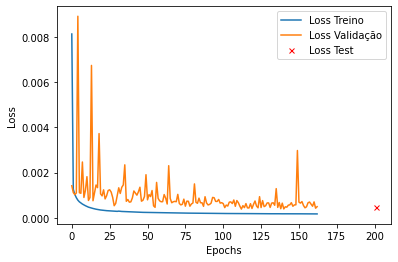

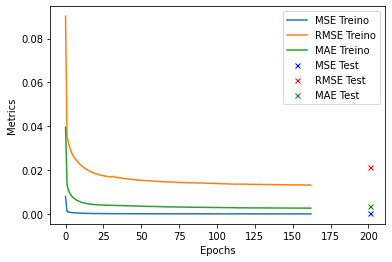

Training finished in 1169.7026789188385 seconds
All training mse losses/rmse metric all spits: 
 {'MSE train': 0.00047734149848110974, 'RMSE train': 0.021848147734999657, 'MAE train': 0.003748067654669285}
======> Test on TRAINING set: [ Loss, metric(mse, rmse, mae)]=[0.00047734149848110974, 0.00047734149848110974, 0.021848147734999657, 0.003748067654669285]
======> Test on TEST     set: [ Loss, metric(mse, rmse, mae)]=[0.00046398292761296034, 0.00046398292761296034, 0.021540263667702675, 0.0036581847816705704]
Saving model in /content/drive/My Drive/Colab Notebooks/saved_models/CNN_T_RAINDRY_Lev_wind3_fKer[[64, 2, True, None], [64, 2, True, None]]_hid[128, 128]_bat64_382-inputs_[128, 128]-layers_254-outputs_200-epochs__ALL_VARS ...
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/saved_models/CNN_T_RAINDRY_Lev_wind3_fKer[[64, 2, True, None], [64, 2, True, None]]_hid[128, 128]_bat64_382-inputs_[128, 128]-layers_254-outputs_200-epochs__ALL_VARS/assets
test_dir_

In [ ]:
for rain_dry in [0]:
  for use_levs in ['Lev']:
    
    dic_var_levels_exclude_examples, dic_var_levels_exclude_targets = get_dic_levels_excluded_dt360_lv28(use_levs)

    normalized_training_examples, normalized_training_targets,\
    normalized_validation_examples, normalized_validation_targets,\
    all_min_values, all_max_values = get_data_for_test_rainy_dry(all_examples, all_targets, rain_dry=rain_dry)

    normalized_training_examples = get_df_col_k(normalized_training_examples, k_inicial, k_final, dic_var_levels_exclude_examples)
    normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final, dic_var_levels_exclude_targets)
    
    normalized_validation_examples = get_df_col_k(normalized_validation_examples, k_inicial, k_final, dic_var_levels_exclude_examples)
    normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final, dic_var_levels_exclude_targets)

    arr_input_train_1 = normalized_training_examples.to_numpy()
    arr_output_train_1 = normalized_training_targets.to_numpy()
    arr_input_val_1 = normalized_validation_examples.to_numpy()
    arr_output_val_1 = normalized_validation_targets.to_numpy()

    del normalized_training_examples, normalized_training_targets


    # Train model parameters
    #
    loss_type = 'mse'
    epochs=200
    splits=1

    dropout = None

    # hidden_layers_arr = [ [108], [216], [108, 108] ]  #, [108, 108]]
    hidden_layers_arr = [ [128, 128] ]  #, [108, 108]]

    # batch_norm_arr_1 = [True, None]
    # batch_norm_arr_2 = [True, None]
    batch_norm_arr_1 = [True]
    batch_norm_arr_2 = [True]

    # max_pooling_arr_1 = [None, 2, 3]
    # max_pooling_arr_2 = [2, 3]
    max_pooling_arr_1 = [None, 2]
    max_pooling_arr_2 = [None, 2, 3]

    # n_filters_1 = [32, 64] 
    # n_filters_2 = [32, 64] 
    n_filters_1 = [64] 
    n_filters_2 = [64] 

    # n_kernels_1 = [5, 3, 2]
    # n_kernels_2 = [5, 3, 2]
    n_kernels_1 = [3]
    n_kernels_2 = [3]

    timesteps_window_arr = [6]
    # timesteps_window_arr = [9]

    batch_size_arr=[64]
    # TODO escolher o melhor batch size de MLP



    # for batch_size in batch_size_arr:
    #   for batch_norm_1 in batch_norm_arr_1:        
    #     for batch_norm_2 in batch_norm_arr_2:        
    #       # for max_pooling in max_pooling_arr:
    #       for max_pooling_1 in max_pooling_arr_1:
    #         for max_pooling_2 in max_pooling_arr_2:  
    #           # for nf in n_filters:
    #           for nf_1 in n_filters_1:
    #             for nf_2 in n_filters_2:
    #                 # for nk in n_kernels:
    #                 for nk_1 in n_kernels_1:
    #                   for nk_2 in n_kernels_2:
                        # for arr_convs in [ [[nf_1, nk_1, batch_norm_1, max_pooling_1], [nf_2, nk_2, batch_norm_2, max_pooling_2]] ]:
                          # for timesteps_window in timesteps_window_arr:
                          #   for hidden_layers in hidden_layers_arr:

                              # if nk_1 > timesteps_window or nk_2 > timesteps_window: continue

    batch_size=64
    timesteps_window=3
    hidden_layers=[128, 128]
    # for arr_convs in [ [[128, 2, True, None]] ]:
    for arr_convs in [ [[64, 2, True, None], [64, 2, True, None]]]:

          test_name = "CNN_T_{}_{}_wind{}_fKer{}_hid{}_bat{}".format(rain_dry, use_levs, timesteps_window, arr_convs, hidden_layers, batch_size) 
          model_name = "CNN_T_RAINDRY_{}_wind{}_fKer{}_hid{}_bat{}".format(use_levs, timesteps_window, arr_convs, hidden_layers, batch_size) 

          drive_logs_test_dir = get_drive_test_log_dir(test_name)
          if os.path.exists(drive_logs_test_dir): 
            log_msg(" Teste existente, pulando: {}".format(test_name))
            continue

          drive_logs_test_dir = create_drive_test_log_dir(test_name)
          log_msg(" =========== Executando teste {} ==================".format(test_name))

          try:
            print("getting window train")
            arr_input_train = get_arr_input_windowed(arr_input_train_1, timesteps_window)
            print("getting window val")
            arr_input_val = get_arr_input_windowed(arr_input_val_1, timesteps_window)

            # # TRAIN
            new_samples=int(arr_input_train.shape[0]/timesteps_window)
            arr_input_train = arr_input_train[0:new_samples*timesteps_window,:]
            arr_input_train = arr_input_train.reshape(new_samples, timesteps_window, arr_input_train.shape[1])
            arr_output_train = arr_output_train_1[timesteps_window-1:,:]  # inicia pelo ultimo usado na janela do treino

            # # VALIDATION
            new_samples = int(arr_input_val.shape[0]/timesteps_window)
            arr_input_val = arr_input_val[0:new_samples*timesteps_window,:]
            arr_input_val = arr_input_val.reshape(new_samples, timesteps_window, arr_input_val.shape[1])
            arr_output_val = arr_output_val_1[timesteps_window-1:,:]  # inicia pelo ultimo usado na janela do treino

            n_inputs = arr_input_train.shape[2]  # 448
            n_outputs = arr_output_train.shape[1]  # 394
          except Exception as e:
            print("erro obtendo janela. Continuando ... " + str(e))
            continue


          log_msg( "Input  train size/window/variables = {}/{}/{}".format(arr_input_train.shape[0], arr_input_train.shape[1], arr_input_train.shape[2]))
          log_msg( "Output train size/variables = {}/{}".format(arr_output_train.shape[0], arr_output_train.shape[1]))

          model_dir = get_mode_var_name_dir(model_name, n_inputs, hidden_layers, n_outputs, epochs, 'ALL_VARS')

          # Train model
          log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs)
          
          if os.path.exists(model_dir):
            model = load_model((model_dir + '/tmp_model.h5'))
          else:
            try:
              model = get_cnn_model(n_inputs, n_outputs, arr_convs, hidden_layers, dropout, loss=loss_type, timesteps_window=timesteps_window) 
              model.summary(print_fn=log_msg)
            except Exception as e:
              print("erro obtendo CNN. Continuando ... " + str(e))
              continue
            # try:
            #   with tf.device('/device:GPU:0') as gpu:
            train_model(model, arr_input_train, arr_output_train, log_dir_var, epochs=epochs, n_splits=splits, 
                        batch_size=batch_size, shuffle=True)
            # except Exception as e:
            #   print("erro Treinando. Continuando ... " + str(e))
            #   continue
            try:
              save_model_and_logs(model, test_name, model_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir)
            except Exception as e:
              print("erro Salvando modelo. Continuando ... " + str(e))
              continue
          del arr_input_train, arr_output_train


          try:
            validate_model_cnn_timesteps(model, arr_input_val, arr_output_val)
            dic_var_default_values = dic_var_default_values_dt360_lv28()
          except Exception as e:
            print("erro Validando cnn. Continuando ... " + str(e))
            continue

          try:
            calc_skill_C(normalized_validation_examples, normalized_validation_targets, all_min_values, all_max_values, dic_var_default_values, arr_input_val, arr_output_val)
            del arr_input_val, arr_output_val
            del model
          except Exception as e:
            log_msg("Erro calculando skill " + str(e))

### Teste CNN 2D
- 448 features de entrada
- n timesteps x 448 features, onde ocorre a conv2D


In [ ]:
agiliza = False

In [ ]:
# TODO
# all_spin_examples, all_spin_targets, no_spinup_size = get_no_spinup_examples_and_targets(levels, delta_t, spin_hours, pre_process=True)    
# normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets, all_min_values, all_max_values = \
# get_data_for_test(all_spin_examples, all_spin_targets)


use_levs = 'NoLv'

# usando 90% da base com Colab PRo por motivos de memoria 
# ########################################################
if not agiliza:
  normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets, all_min_values, all_max_values = \
  get_data_for_test(all_examples, all_targets, 0.9)
  
  dic_var_levels_exclude_examples, dic_var_levels_exclude_targets = get_dic_levels_excluded_dt360_lv28(use_levs)

  normalized_training_examples = get_df_col_k(normalized_training_examples, k_inicial, k_final, dic_var_levels_exclude)
  normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final, dic_var_levels_exclude)
  normalized_validation_examples = get_df_col_k(normalized_validation_examples, k_inicial, k_final, dic_var_levels_exclude)
  normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final, dic_var_levels_exclude)

  arr_input_train_1 = normalized_training_examples.to_numpy()
  arr_output_train_1 = normalized_training_targets.to_numpy()
  arr_input_val_1 = normalized_validation_examples.to_numpy()
  arr_output_val_1 = normalized_validation_targets.to_numpy()


  del normalized_training_examples, normalized_training_targets

  agiliza = True
  # ********* fim agilizando ...


# Train model parameters
#
loss_type = 'mse'
epochs=100
n_splits=1

dropout = None
# hidden_layers_arr = [ [108, 108] ]  #, [108, 108]]
# batch_norm_arr_1 = [True, None]
# batch_norm_arr_2 = [True, None]
# max_pooling_arr_1 = [None, 2, 3]
# max_pooling_arr_2 = [2, 3]
# n_filters_1 = [32, 64] 
# n_filters_2 = [32, 64] 
# n_kernels_1 = [2, 3, 5, 7]
# n_kernels_2 = [2, 3, 5, 7]
# timesteps_window_arr = [2, 3, 6, 9]

hidden_layers_arr = [ [108, 108] ]  #, [108, 108]]
batch_norm_arr_1 = [True]
batch_norm_arr_2 = [True]
max_pooling_arr_1 = [None]
max_pooling_arr_2 = [2]
n_filters_1 = [64] 
n_filters_2 = [64] 
n_kernels_1 = [5]
n_kernels_2 = [5]
timesteps_window_arr = [9]


# for arr_convs in [ [[nf, nk]], [[nf, nk], [nf, nk]], [[nf, nk], [nf, nk], [nf, nk]] ]:
for batch_norm_1 in batch_norm_arr_1:        
  for batch_norm_2 in batch_norm_arr_2:        
    # for max_pooling in max_pooling_arr:
    for max_pooling_1 in max_pooling_arr_1:
      for max_pooling_2 in max_pooling_arr_2:  
        # for nf in n_filters:
        for nf_1 in n_filters_1:
          for nf_2 in n_filters_2:
              # for nk in n_kernels:
              for nk_1 in n_kernels_1:
                for nk_2 in n_kernels_2:
                  # for arr_convs in [ [[nf, nk]] ]:
                  for arr_convs in [ [[nf_1, nk_1, batch_norm_1, max_pooling_1], [nf_2, nk_2, batch_norm_2, max_pooling_2]] ]:
                    for timesteps_window in timesteps_window_arr:
                      for hidden_layers in hidden_layers_arr:
                        if nk_1 > timesteps_window or nk_2 > timesteps_window: continue

                        
                        test_name = "CNN2_T_{}_wind{}_fKer{}_hid{}_drp{}".format(use_levs, timesteps_window, arr_convs, hidden_layers, dropout) 
                        drive_logs_test_dir = get_drive_test_log_dir(test_name)
                        if os.path.exists(drive_logs_test_dir): 
                          log_msg(" Teste existente, pulando: {}".format(test_name))
                          continue

                        drive_logs_test_dir = create_drive_test_log_dir(test_name)
                        log_msg(" =========== Executando teste {} ==================".format(test_name))

                        try:
                          print("getting window train")
                          arr_input_train = get_arr_input_windowed(arr_input_train_1, timesteps_window)
                          print("getting window val")
                          arr_input_val = get_arr_input_windowed(arr_input_val_1, timesteps_window)

                          # # TRAIN
                          new_samples=int(arr_input_train.shape[0]/timesteps_window)
                          arr_input_train = arr_input_train[0:new_samples*timesteps_window,:]
                          arr_input_train = arr_input_train.reshape(new_samples, timesteps_window, arr_input_train.shape[1])
                          arr_output_train = arr_output_train_1[timesteps_window-1:,:]  # inicia pelo ultimo usado na janela do treino

                          # # VALIDATION
                          new_samples = int(arr_input_val.shape[0]/timesteps_window)
                          arr_input_val = arr_input_val[0:new_samples*timesteps_window,:]
                          arr_input_val = arr_input_val.reshape(new_samples, timesteps_window, arr_input_val.shape[1])
                          arr_output_val = arr_output_val_1[timesteps_window-1:,:]  # inicia pelo ultimo usado na janela do treino

                          n_inputs = arr_input_train.shape[2]  # 448
                          n_outputs = arr_output_train.shape[1]  # 394
                        except Exception as e:
                          print("erro obtendo janela. Continuando ... " + str(e))
                          continue


                        try:
                          model = get_cnn_model(n_inputs, n_outputs, arr_convs, hidden_layers, dropout, loss=loss_type, timesteps_window=timesteps_window, is_CNN2D=True) 
                          model.summary(print_fn=log_msg)
                        except Exception as e:
                          print("erro obtendo CNN. Continuando ... " + str(e))
                          continue

                        log_msg( "Input  train size/window/variables = {}/{}/{}".format(arr_input_train.shape[0], arr_input_train.shape[1], arr_input_train.shape[2]))
                        log_msg( "Output train size/variables = {}/{}".format(arr_output_train.shape[0], arr_output_train.shape[1]))

                        model_dir = get_mode_var_name_dir(test_name, n_inputs, hidden_layers, n_outputs, epochs, 'ALL_VARS')

                        # Train model
                        log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs)
                        # ********* agilizando ...
                        
                        try:
                          with tf.device('/device:GPU:0') as gpu:
                            train_model(model, arr_input_train, arr_output_train, log_dir_var, epochs=epochs, n_splits=n_splits)
                        except Exception as e:
                          print("erro Treinando. Continuando ... " + str(e))
                          continue

                        del arr_input_train, arr_output_train

                        try:
                          save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir)
                        except Exception as e:
                          print("erro Salvando modelo. Continuando ... " + str(e))
                          continue

                        try:
                          # ********* agilizando ...
                          # use trained model
                          # model = load_model((model_dir + '/tmp_model.h5'))
                          validate_model_cnn_timesteps(model, arr_input_val, arr_output_val)
                          dic_var_default_values = dic_var_default_values_dt360_lv28()
                        except Exception as e:
                          print("erro Validando cnn. Continuando ... " + str(e))
                          continue

                        try:
                          calc_skill_C(normalized_validation_examples, normalized_validation_targets, all_min_values, all_max_values, dic_var_default_values, arr_input_val, arr_output_val)
                          del arr_input_val, arr_output_val
                          del model
                        except Exception as e:
                          log_msg("Erro calculando skill " + str(e))

 =========== Executando teste CNN2_T_NoLv_wind9_fKer[[64, 5, True, None], [64, 5, True, 2]]_hid[108, 108]_drpNone ==================
getting window train
getting window val
erro obtendo CNN. Continuando ... Input 0 of layer conv2d is incompatible with the layer: : expected min_ndim=4, found ndim=3. Full shape received: (None, 9, 448)


# Resultados

### Grafico melhores

====================================== a ==========================================


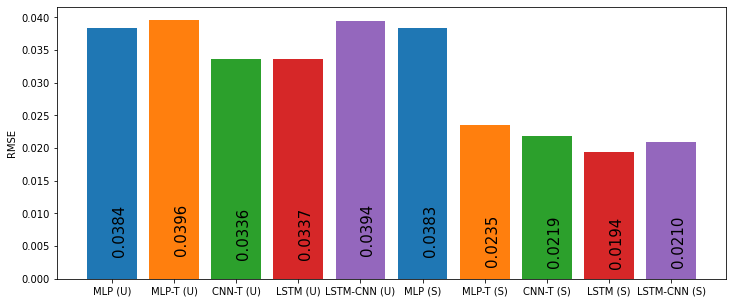

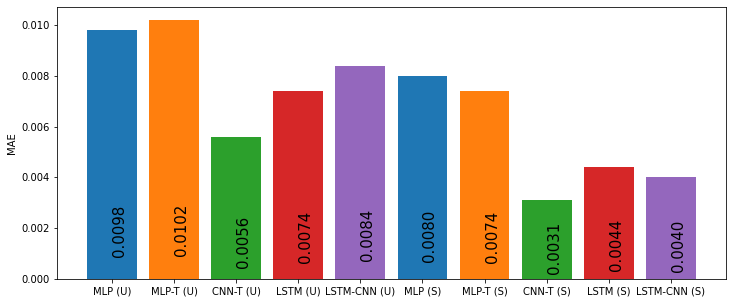

In [ ]:
def plot_metrics(metric_analyz, tests_results, tit):
  plt.figure(figsize=(12, 5))
  d = {}
  for k, v in tests_results.items():
    d[k] = v[metric_analyz]
  
  plt.ylabel(metric_analyz)
  plt.bar(range(len(d)), list(d.values()), align='center', color=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple'])

  for index, value in enumerate(d.values()):
    # plt.text(index, value-(value/2), "{:.4f}".format(value), fontsize=15, rotation=90)
    plt.text(index, value/10, "{:.4f}".format(value), fontsize=15, rotation=90)
  plt.xticks(range(len(d)), list(d.keys()))
  # plt.title("Período {}".format(periodo))
  # plt.title(tit)
  plt.show()

def plot_all_metrics(dic_tests_results, tit):
  for k, v in dic_tests_results.items():
    print("====================================== {} ==========================================".format(k))
    # plot_metrics('MSE test', v)
    plot_metrics('RMSE', v, tit)
    plot_metrics('MAE', v, tit)

tests = {}

results = {}
results['RMSE'] = 0.0384
results['MAE'] = 0.0098
tests['MLP (U)'] = results

results = {}
results['RMSE'] = 0.0396
results['MAE'] = 0.0102
tests['MLP-T (U)'] = results

results = {}
results['RMSE'] = 0.0336
results['MAE'] = 0.0056
tests['CNN-T (U)'] = results
dic_tests_results = {'a': tests}

results = {}
results['RMSE'] = 0.0337
results['MAE'] = 0.0074
tests['LSTM (U)'] = results

results = {}
results['RMSE'] = 0.0394
results['MAE'] = 0.0084
tests['LSTM-CNN (U)'] = results



results = {}
results['RMSE'] = 0.0383
results['MAE'] = 0.0080
tests['MLP (S)'] = results

results = {}
results['RMSE'] = 0.0235
results['MAE'] = 0.0074
tests['MLP-T (S)'] = results

results = {}
results['RMSE'] = 0.02188
results['MAE'] = 0.0031
tests['CNN-T (S)'] = results
dic_tests_results = {'a': tests}

results = {}
results['RMSE'] = 0.0194
results['MAE'] = 0.0044
tests['LSTM (S)'] = results

results = {}
results['RMSE'] = 0.0210
results['MAE'] = 0.004
tests['LSTM-CNN (S)'] = results


plot_all_metrics(dic_tests_results, "RMSE")


### Matriz de erro

Tc       0.015434
qv       0.023797
qc       0.039826
qr       0.029441
qi       0.033845
qs       0.042089
qg       0.022794
ni       0.039926
ns       0.053712
nr       0.024900
NG       0.017747
NC       0.017091
EFFCS    0.075008
EFFIS    0.252369
LSRAIN   0.029634
LSSNOW   0.006681
dtype: float64


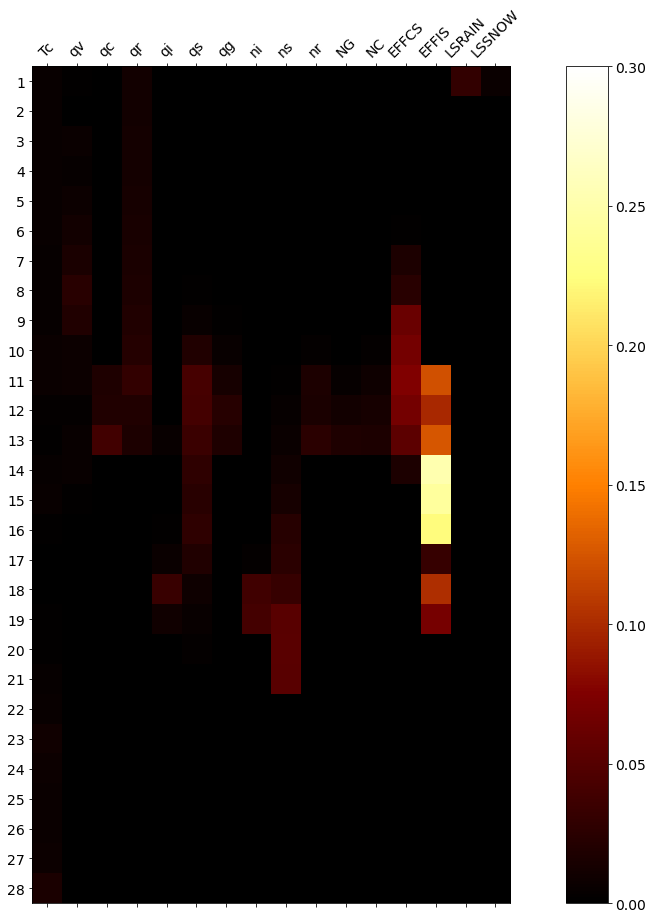

In [ ]:
def plot_error_colored_matrix():
  # https://stackoverflow.com/questions/40887753/display-matrix-values-and-colormap

  # fig, ax = plt.subplots()
  # fig, ax = plt.subplots(figsize=(20,10))
  # min_val, max_val = 0, 15   # X.shape
  # min_val, max_val =
  # fig.figsize=(30,30)
  # intersection_matrix = np.random.randint(0, 10, size=(max_val, max_val))

  # intersection_matrix = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/logs/MLP_T_360_R0__days31_Lev_[5, 254]_relu_bat128_drpNone_outsigmoid_wind3/log_rmse.csv', sep=',')
  # intersection_matrix = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/logs/MLP_T_360_R0__days31_Lev_[5, 254]_relu_bat128_drpNone_outsigmoid_wind3/log_rmse.csv', sep=',')
  # intersection_matrix = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/logs/CNN_T_0_Lev_wind3_fKer[[64, 2, True, None], [64, 2, True, None]]_hid[128, 128]_bat64/log_rmse.csv', sep=',')
  intersection_matrix.drop(columns=['Unnamed: 0'], inplace=True)
  
  # display.display(intersection_matrix)
  
  
  # ax.matshow(intersection_matrix)



  print(intersection_matrix.max())
  f = plt.figure(figsize=(20, 15))
  plt.matshow(intersection_matrix, fignum=f.number, vmin=0.0, vmax=0.3, cmap='afmhot')
  plt.xticks(range(intersection_matrix.shape[1]), intersection_matrix.columns, fontsize=14, rotation=45)
  plt.yticks(range(intersection_matrix.shape[0]), range(1, intersection_matrix.shape[0] + 1), fontsize=14)
  cb = plt.colorbar()
  cb.ax.tick_params(labelsize=14)
  # plt.title('RMSE', fontsize=16);

  # for i in xrange(15):
  #     for j in xrange(15):
  #         c = intersection_matrix[j,i]
  #         ax.text(i, j, str(c), va='center', ha='center')



plot_error_colored_matrix()

### Gráficos de erro por nível

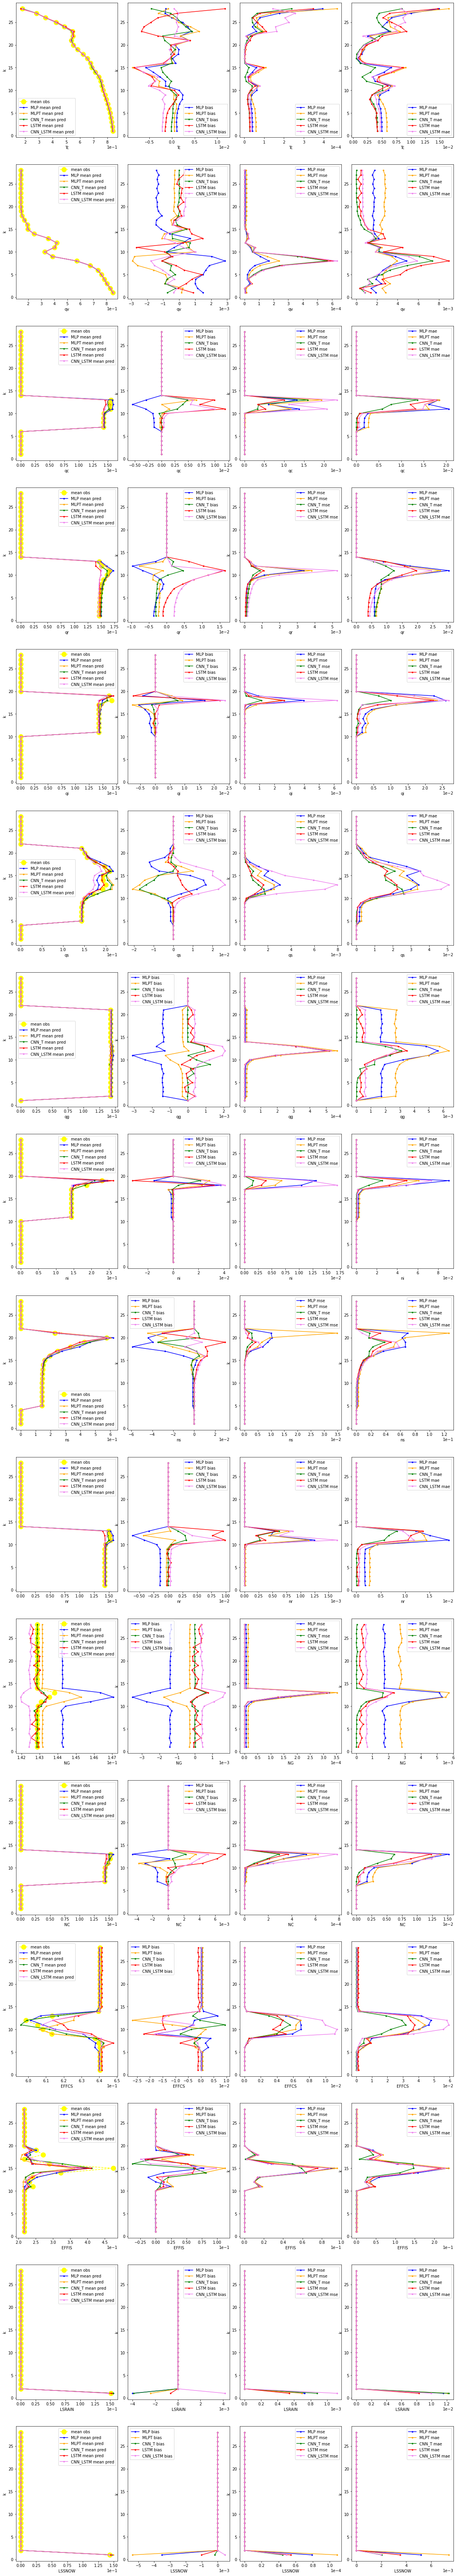

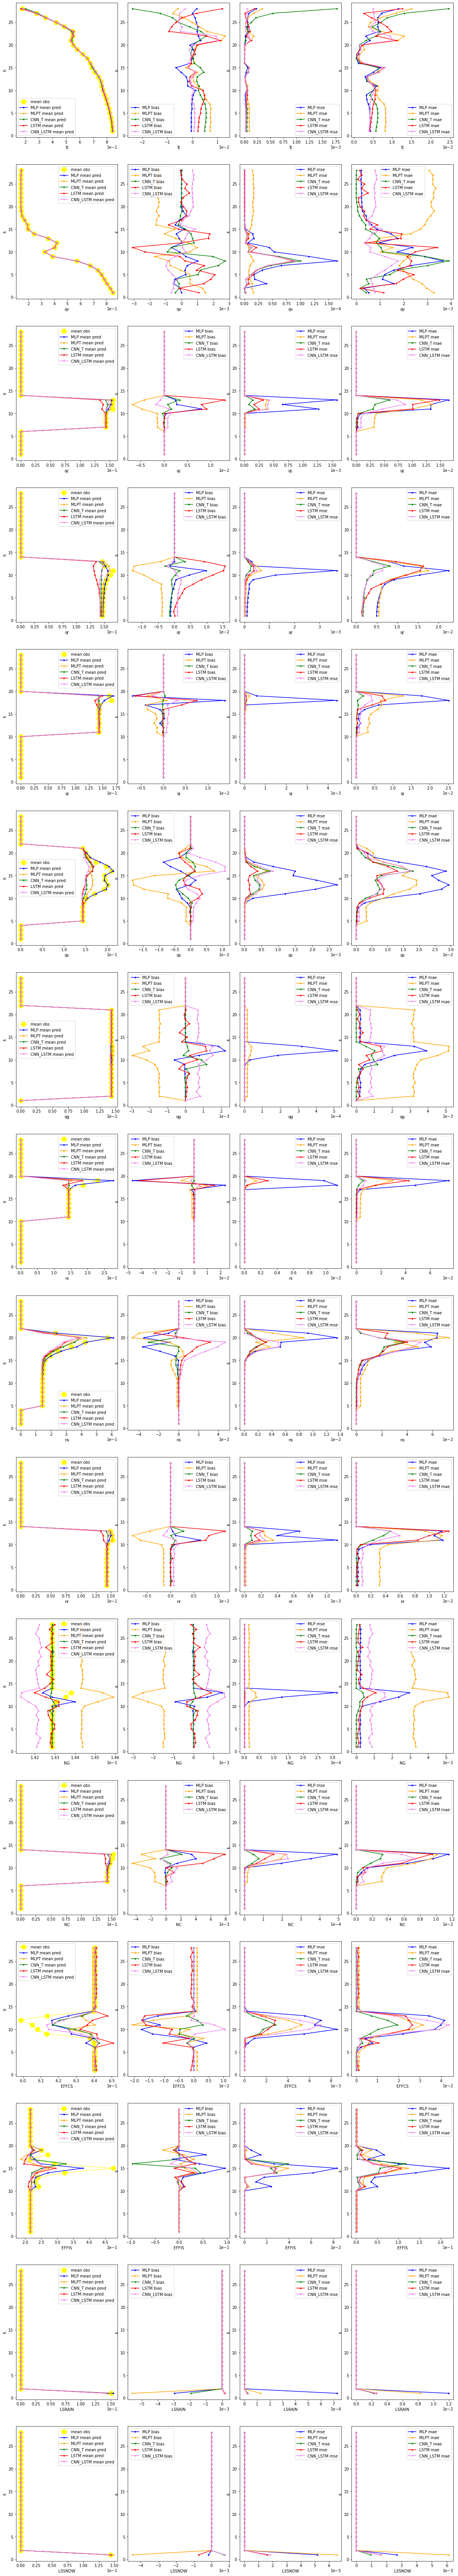

In [ ]:
def generate_skill_graphic(skill, skill_fname, key, arr_test, arr_markers, arr_colors, arr_labels, plot_sci_numbers=True):
  for test, mark, color, label in zip(arr_test, arr_markers, arr_colors, arr_labels):
    path = '{}/{}/{}'.format(exp1_dir, test, skill_fname)  
    df_skill = pd.read_csv(path)
    skill_values = df_skill[key].values
    plt.plot(skill_values, range(1, len(skill_values)+1), label=label + ' ' + skill, marker=mark, color=color)
  if plot_sci_numbers:
    plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
  plt.legend()


def generate_subplot(ncols, nskills, idx_plot, key):
  plt.subplot(ncols, nskills, idx_plot)
  plt.ylabel("k")
  plt.xlabel(key)


def generate_all_graphics(arr_test, cols, obs_file_name, pred_file_name, arr_skills, arr_skill_filenames, arr_markers, arr_colors, arr_labels, plot_sci_numbers=True):
  idx_plot = 1
  plt.figure(figsize=(20, 120))
  for key in cols:
      if key == 'Unnamed: 0': 
        continue
      generate_subplot(len(cols)-1, len(arr_skills)+1, idx_plot, key)

      mean_obs_path = '{}/{}/{}'.format(exp1_dir, arr_test[0], obs_file_name)
      df_mean_obs = pd.read_csv(mean_obs_path)
      obs_values = df_mean_obs[key].values
      plt.plot(obs_values, range(1, len(obs_values)+1), label='mean obs',  marker='o', linestyle='dashed', color='yellow', markersize=12)
      
      generate_skill_graphic('mean pred', pred_file_name, key, arr_test, arr_markers, arr_colors, arr_labels, plot_sci_numbers)
      idx_plot += 1

      for skill, skill_fname in zip(arr_skills, arr_skill_filenames):
        generate_subplot(len(cols)-1, len(arr_skills)+1, idx_plot, key)
        generate_skill_graphic(skill, skill_fname, key, arr_test, arr_markers, arr_colors, arr_labels, plot_sci_numbers)
        idx_plot += 1
  
  plt.subplots_adjust(hspace=0.2, wspace=0.1)
  plt.show()


# exp1_dir = '/content/drive/My Drive/Colab Notebooks/logs_models_rttmg_dt60'
exp1_dir = '/content/drive/My Drive/Colab Notebooks/logs'
# exp1_dir = tb_logdir_base

# arr_test = [ 'MLP_TEST_0_Lev_[648, 648, 648, 648, 648]_relu_bat128', 'MLP_TEST_1_Lev_[648, 648, 648, 648, 648]_relu_bat128']
# arr_markers = ['D', 'D']
# arr_colors = ['blue', 'green']
# arr_labels = [ 'MLP_0_180', 'MLP_1_180']
# dummy_path = '{}/{}/{}'.format(exp1_dir, 'MLP_TEST_0_Lev_[648, 648, 648, 648, 648]_relu_bat128', 'log_mean_obs.csv')
# dummy_df = pd.read_csv(dummy_path)
# arr_skills = ['bias', 'mse', 'mae']
# obs_file_name = 'log_mean_obs.csv'
# pred_file_name = 'log_mean_pred.csv'
# arr_skill_filenames = ['log_bias.csv', 'log_mse.csv', 'log_mae.csv']
# generate_all_graphics(arr_test, dummy_df.columns.to_list(), obs_file_name, pred_file_name, arr_skills, arr_skill_filenames, arr_markers, arr_colors, arr_labels)


# arr_test = [ 'MLP_360_0_Lev_[432, 432, 432, 432]_relu_bat128', 'MLP_360_1_Lev_[432, 432, 432, 432]_relu_bat128', 'MLP_360_testdays3_0_Lev_[432, 432, 432, 432]_relu_bat128', 'MLP_360_testdays3_1_Lev_[432, 432, 432, 432]_relu_bat128']

for rainDry in ['0', '1']:
  arr_test = [ 
              f'MLP_360_R{rainDry}__days31_Lev_[5, 254]_relu_bat128_drpNone_outsigmoid', 
              f'MLP_T_360_R{rainDry}__days31_Lev_[5, 254]_relu_bat128_drpNone_outsigmoid_wind3',
              f'CNN_T_{rainDry}_Lev_wind3_fKer[[64, 2, True, None], [64, 2, True, None]]_hid[128, 128]_bat64', 
              f'LSTM_360_R{rainDry}_v2_days31_Lev_unitNone_steps6_stride1_bat128',
              f'LSTM_360_R{rainDry}_v2_CNN_days31_Lev_unitNone_steps10_stride1_bat128']

  arr_markers = [ '.', '.', '.', '.', '.']
  arr_colors = ['blue', 'orange', 'green', 'red', 'violet']
  arr_labels = [ 'MLP', 'MLPT', 'CNN_T', 'LSTM', 'CNN_LSTM' ]
  dummy_path = '{}/{}/{}'.format(exp1_dir, f'MLP_360_R{rainDry}__days31_Lev_[5, 254]_relu_bat128_drpNone_outsigmoid', 'log_mean_obs.csv')
  dummy_df = pd.read_csv(dummy_path)
  arr_skills = ['bias', 'mse', 'mae']
  obs_file_name = 'log_mean_obs.csv'
  pred_file_name = 'log_mean_pred.csv'
  arr_skill_filenames = ['log_bias.csv', 'log_mse.csv', 'log_mae.csv']
  generate_all_graphics(arr_test, dummy_df.columns.to_list(), obs_file_name, pred_file_name, arr_skills, arr_skill_filenames, arr_markers, arr_colors, arr_labels)
